In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

import argparse
from collections import deque


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Dataset class
class SpectrogramDataset(Dataset):
    def __init__(self, root_dir, folds, csv_file, transform=None, use_augmentations=True):
        self.root_dir = root_dir
        self.transform = transform
        self.use_augmentations = use_augmentations

        # Read the CSV file with the spectrogram information
        self.annotations = pd.read_csv(csv_file)

        # Handle single or multiple folds
        if isinstance(folds, int):
            folds = [folds]

        # Filter by folds
        self.file_list = self.annotations[self.annotations['fold'].isin(folds)]

        # Filter out augmentations if specified
        if not use_augmentations:
            self.file_list = self.file_list[self.file_list['augmentation'] == 'original']

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        # Get the file path
        img_name = self.file_list.iloc[idx]['spec_file_name']
        fold = self.file_list.iloc[idx]['fold']
        label = self.file_list.iloc[idx]['classID']

        # Construct the full path to the image
        img_path = os.path.join(self.root_dir, f'fold{fold}', img_name)

        # Load the image
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            if self.use_augmentations:
                # For MoCo, we need two differently augmented views of the same image
                q = self.transform(image)  # query
                k = self.transform(image)  # key
                return q, k, label
            else:
                # Always apply transform for validation
                image = self.transform(image)

        return image, label

# MLP for projection head
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=2048, hidden_dim=2048, output_dim=128):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
      return self.layers(x)
def mixup_data(x1, x2, y1, y2, alpha=0.4):

    # Sample lambda from a beta distribution
    lambda_ = torch.distributions.Beta(alpha, alpha).sample().item()

    # Mix the images and labels
    mixed_x = lambda_ * x1 + (1 - lambda_) * x2
    mixed_y = lambda_ * y1 + (1 - lambda_) * y2

    return mixed_x, mixed_y, lambda_

def train_with_mixup(moco, contrastive_criterion, im_q, im_k, labels, alpha=0.4):
    """
    MoCo training with MixUp on query and key images.

    Args:
    - moco: MoCo model
    - contrastive_criterion: Loss function
    - im_q: Query image batch
    - im_k: Key image batch
    - labels: Ground truth labels
    - alpha: MixUp hyperparameter

    Returns:
    - moco_loss: Loss value after applying MixUp
    """
    # Apply MixUp to the query and key images, and their labels
    im_q, labels_q, lambda_q = mixup_data(im_q, im_k, labels, labels, alpha)
    im_k, labels_k, lambda_k = mixup_data(im_k, im_q, labels, labels, alpha)

    # Forward pass through the MoCo model
    logits, targets, q_feat = moco(im_q, im_k)

    # Compute the MoCo contrastive loss (similar to how it's done normally)
    moco_loss = contrastive_criterion(logits, targets)

    # Optionally, you can also apply the weighted loss based on lambda
    # Note: MoCo loss typically uses a contrastive approach, so this is optional
    moco_loss = lambda_q * moco_loss

    return moco_loss

# MoCo model components
class MoCo(nn.Module):
    def __init__(self, backbone=None, dim=128, K=4096, m=0.999, T=0.07):
        super().__init__()
        """
        backbone: base encoder network (default: ResNet50)
        dim: feature dimension (default: 128)
        K: queue size (default: 4096)
        m: moco momentum of updating key encoder (default: 0.999)
        T: softmax temperature (default: 0.07)
        """
        self.K = K
        self.m = m
        self.T = T

        # Create backbone if not provided
        if backbone is None:
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
            backbone.fc = nn.Identity()  # Remove classification layer

        # Create encoder q (online network)
        self.encoder_q = backbone
        self.projection_q = ProjectionHead(input_dim=2048, output_dim=dim)

        # Create encoder k (momentum network) - no gradient
        self.encoder_k = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.encoder_k.fc = nn.Identity()
        self.projection_k = ProjectionHead(input_dim=2048, output_dim=dim)

        # Initialize the momentum network with the same parameters
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        for param_q, param_k in zip(self.projection_q.parameters(), self.projection_k.parameters()):
            param_k.data.copy_(param_q.data)
            param_k.requires_grad = False

        # Create the queue for negative samples
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = F.normalize(self.queue, dim=0)
        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """Momentum update of the key encoder"""
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

        for param_q, param_k in zip(self.projection_q.parameters(), self.projection_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        # Handle case where batch size doesn't divide queue size evenly
        if ptr + batch_size > self.K:
            # Split the batch to avoid overflow
            first_part = self.K - ptr
            self.queue[:, ptr:] = keys[:first_part].T
            self.queue[:, :batch_size-first_part] = keys[first_part:].T
            ptr = (batch_size - first_part) % self.K
        else:
            # Replace the keys at ptr (dequeue and enqueue)
            self.queue[:, ptr:ptr + batch_size] = keys.T
            ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def get_features(self, x):
        """Get features from the encoder_q for downstream tasks"""
        return self.encoder_q(x)

    def forward(self, im_q, im_k=None, get_features=False):
        """Forward pass for MoCo

        Args:
            im_q: a batch of query images
            im_k: a batch of key images (if None, only return features)
            get_features: if True, return features instead of contrastive loss
        """
        # Extract features for downstream tasks if requested
        if get_features:
            return self.get_features(im_q)

        # Compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q_proj = self.projection_q(q)  # projects: NxD
        q_proj = F.normalize(q_proj, dim=1)  # normalize

        # Compute key features
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()  # update the key encoder

            k = self.encoder_k(im_k)  # keys: NxC
            k_proj = self.projection_k(k)  # projects: NxD
            k_proj = F.normalize(k_proj, dim=1)  # normalize

        # Compute logits
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q_proj, k_proj]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q_proj, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positives are the 0th position
        labels = torch.zeros(logits.shape[0], dtype=torch.long, device=logits.device)

        # Dequeue and enqueue
        self._dequeue_and_enqueue(k_proj)

        return logits, labels, q

# Classifier for downstream task
class Classifier(nn.Module):
    def __init__(self, input_dim=2048, num_classes=14):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


# Training function
def train(fold, class_names, num_classes, batch_size=64, num_epochs=30, alpha=0.2):
    """
    Train the MoCo model with MixUp augmentation.

    Args:
        fold: Fold number to use as validation
        class_names: List of class names
        num_classes: Number of classes
        batch_size: Batch size
        num_epochs: Number of epochs
        alpha: MixUp parameter for Beta distribution
    """
    # Create timestamp for saving results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_dir = f"results_moco_{timestamp}"
    os.makedirs(results_dir, exist_ok=True)
    print(f"Results will be saved to {results_dir}")

    # Set up device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Define transformations for training
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Define transformations for validation (no augmentation)
    eval_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Data loaders
    train_folds = [f for f in range(1, 11) if f != fold]

    train_ds = SpectrogramDataset(
        './spectrograms',
        train_folds,
        './spectrograms_balanced.csv',
        transform,
        use_augmentations=True
    )

    val_ds = SpectrogramDataset(
        './spectrograms',
        [fold],
        './spectrograms_balanced.csv',
        eval_transform,
        use_augmentations=False
    )

    # Ensure batch size is compatible with queue size (for simplicity)
    moco_K = 4096  # Queue size
    if moco_K % batch_size != 0:
        new_batch_size = batch_size
        while moco_K % new_batch_size != 0:
            new_batch_size -= 1
        print(f"Adjusting batch size from {batch_size} to {new_batch_size} to be compatible with queue size {moco_K}")
        batch_size = new_batch_size

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    # Initialize models
    backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    backbone.fc = nn.Identity()

    moco = MoCo(backbone, K=moco_K).to(device)
    classifier = Classifier(input_dim=2048, num_classes=num_classes).to(device)

    if fold == 1:
      print("loading the first checkpoint ...")
      checkpoint = torch.load("/content/results_moco_20250405_050903/fold_1_model.pth")
      moco.load_state_dict(checkpoint['moco'])
      classifier.load_state_dict(checkpoint['classifier'])
      print("loaded the first checkpoint ...")
    else:

      # Optimizer
      optimizer = torch.optim.Adam(
          list(moco.parameters()) + list(classifier.parameters()),
          lr=3e-4
      )

      # Learning rate scheduler
      scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
          optimizer, T_max=num_epochs
      )

      # Classification loss
      classification_criterion = torch.nn.CrossEntropyLoss()
      contrastive_criterion = torch.nn.CrossEntropyLoss()

      # Metrics storage
      train_losses, val_losses = [], []
      val_accuracies, all_preds, all_labels = [], [], []

      for epoch in range(num_epochs):
          # TRAINING
          moco.train()
          classifier.train()
          epoch_train_loss = 0.0

          for batch_idx, (im_q, im_k, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
              im_q, im_k, labels = im_q.to(device), im_k.to(device), labels.to(device)

              # Apply MixUp to the spectrogram inputs and labels
              loss = train_with_mixup(moco, contrastive_criterion, im_q, im_k, labels, alpha=0.02)

              # Zero gradients
              optimizer.zero_grad()

              # Forward pass for MoCo with MixUp
              logits, targets, q_feat = moco(im_q, im_k)

              # MoCo contrastive loss
              moco_loss = contrastive_criterion(logits, targets)

              # Classification loss (using mixed features)
              with torch.no_grad():
                  features = moco.get_features(im_q)

              logits_cls = classifier(features.detach())
              cls_loss = classification_criterion(logits_cls, labels)

              # Total loss
              loss = moco_loss + cls_loss

              # Backward pass
              loss.backward()

              # Update parameters
              optimizer.step()

              # Track metrics
              epoch_train_loss += loss.item() * im_q.size(0)

              # Report training progress
              if batch_idx % 10 == 0:
                  print(f"  Batch {batch_idx}/{len(train_loader)}, "
                        f"MoCo Loss: {moco_loss.item():.4f}, "
                        f"Cls Loss: {cls_loss.item():.4f}, "
                        f"Total Loss: {loss.item():.4f}")

          # Calculate average training loss
          epoch_train_loss /= len(train_loader.dataset)
          train_losses.append(epoch_train_loss)

          # VALIDATION
          moco.eval()
          classifier.eval()
          val_loss = 0.0
          correct = 0
          total = 0
          epoch_preds = []
          epoch_labels = []

          with torch.no_grad():
              for images, labels in val_loader:
                  images, labels = images.to(device), labels.to(device)

                  # Extract features
                  features = moco.get_features(images)

                  # Make predictions
                  logits = classifier(features)
                  loss = classification_criterion(logits, labels)

                  # Track metrics
                  val_loss += loss.item() * images.size(0)

                  # Calculate accuracy
                  _, predictions = torch.max(logits, 1)
                  total += labels.size(0)
                  correct += (predictions == labels).sum().item()

                  # Store predictions and labels for confusion matrix
                  epoch_preds.extend(predictions.cpu().numpy())
                  epoch_labels.extend(labels.cpu().numpy())

          # Calculate validation metrics
          val_loss /= len(val_loader.dataset)
          val_accuracy = 100.0 * correct / total
          val_losses.append(val_loss)
          val_accuracies.append(val_accuracy)

          all_preds.append(epoch_preds)
          all_labels.append(epoch_labels)

          # Update learning rate
          scheduler.step()

          # Report epoch results
          print(f"Epoch {epoch+1}/{num_epochs}, "
                f"Train Loss: {epoch_train_loss:.4f}, "
                f"Val Loss: {val_loss:.4f}, "
                f"Val Accuracy: {val_accuracy:.2f}%")

          # Save model checkpoint
          torch.save({
              'epoch': epoch,
              'moco': moco.state_dict(),
              'classifier': classifier.state_dict(),
              'optimizer': optimizer.state_dict(),
              'scheduler': scheduler.state_dict(),
              'train_loss': epoch_train_loss,
              'val_loss': val_loss,
              'val_accuracy': val_accuracy
          }, f"{results_dir}/checkpoint_{epoch}.pth")

      # Save the final model
      torch.save({
          'moco': moco.state_dict(),
          'classifier': classifier.state_dict(),
          'val_accuracy': val_accuracies[-1],
          'class_names': class_names
      }, f"{results_dir}/fold_{fold}_model.pth")

      # Save loss and accuracy plots
      plt.figure(figsize=(12, 4))
      plt.subplot(1, 2, 1)
      plt.plot(range(1, num_epochs+1), train_losses, 'b-', label='Training Loss')
      plt.plot(range(1, num_epochs+1), val_losses, 'r-', label='Validation Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')
      plt.legend()
      plt.title(f'Loss Curve for Fold {fold}')

      plt.subplot(1, 2, 2)
      plt.plot(range(1, num_epochs+1), val_accuracies, 'g-')
      plt.xlabel('Epoch')
      plt.ylabel('Validation Accuracy (%)')
      plt.title(f'Accuracy Curve for Fold {fold}')

      plt.tight_layout()
      plt.savefig(f"{results_dir}/fold_{fold}_plots.png")

      # Generate confusion matrix for the final epoch
      final_cm = confusion_matrix(all_labels[-1], all_preds[-1])
      plt.figure(figsize=(10, 8))
      sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues',
                  xticklabels=class_names, yticklabels=class_names)
      plt.xlabel('Predicted')
      plt.ylabel('True')
      plt.title(f'Confusion Matrix for Fold {fold}')
      plt.tight_layout()
      plt.savefig(f"{results_dir}/fold_{fold}_confusion_matrix.png")

      # Print classification report
      print("\nClassification Report:")
      print(classification_report(all_labels[-1], all_preds[-1], target_names=class_names))

      return val_accuracy


def main(spec_csv, batch_size, epochs):
    """
    # Main function to start the training
    # """
    # parser = argparse.ArgumentParser(description='Train MoCo on spectrograms')
    # parser.add_argument('--fold', type=int, help='Fold to use as validation (1-10)', required=False)
    # parser.add_argument('--debug', action='store_true', help='Enable anomaly detection for debugging')
    # parser.add_argument('--batch_size', type=int, default=32, help='Batch size')
    # parser.add_argument('--epochs', type=int, default=30, help='Number of epochs')
    # args = parser.parse_args()

    # Enable anomaly detection if requested
    # if args.debug:
    #     print("Enabling anomaly detection for debugging")
    #     torch.autograd.set_detect_anomaly(True)

    # Set random seed
    set_seed(42)

    # Get class names and auto-detect num_classes
    print("Loading data from ./spectrograms_balanced.csv")
    full_annotations =spec_csv
    class_names = sorted(full_annotations['class'].unique())
    num_classes = len(class_names)
    print(f"Detected {num_classes} classes: {class_names}")

    num_folds = 4

    # # Train specific fold or all folds
    # if args.fold is not None:
    #     # Train only the specified fold
    #     fold = args.fold
    # print(f"\n=== Training Fold {fold}/{num_folds} ===")
    # train(fold, class_names, num_classes, args.debug, args.batch_size, args.epochs)
    #     # Train all folds one by one
    all_fold_accuracies = []

    for fold in range(1, num_folds+1):
      print(f"\n=== Training Fold {fold}/{num_folds} ===")

            # Clear GPU cache to prevent memory buildup between folds
    # if torch.cuda.is_available():
    #   torch.cuda.empty_cache()

      accuracy = train(fold, class_names, num_classes, batch_size, epochs)
      all_fold_accuracies.append(accuracy)

      # Report average accuracy
    avg_accuracy = np.mean(all_fold_accuracies)
    print(f"\nAverage accuracy across {num_folds} folds: {avg_accuracy:.2f}%")



Loading data from ./spectrograms_balanced.csv
Detected 13 classes: ['air_conditioner', 'ambulance', 'car_horn', 'children_playing', 'dog_bark', 'drilling', 'engine_idling', 'firetruck', 'gun_shot', 'jackhammer', 'police', 'street_music', 'traffic']

=== Training Fold 1/4 ===
Results will be saved to results_moco_20250405_074032
Using device: cuda:0
loading the first checkpoint ...
loaded the first checkpoint ...

=== Training Fold 2/4 ===
Results will be saved to results_moco_20250405_074033
Using device: cuda:0


Epoch 1/5:   0%|          | 1/522 [00:03<26:52,  3.10s/it]

  Batch 0/522, MoCo Loss: 3.8708, Cls Loss: 2.6653, Total Loss: 6.5361


Epoch 1/5:   2%|▏         | 11/522 [00:34<26:18,  3.09s/it]

  Batch 10/522, MoCo Loss: 6.5001, Cls Loss: 2.4848, Total Loss: 8.9848


Epoch 1/5:   4%|▍         | 21/522 [01:05<26:03,  3.12s/it]

  Batch 20/522, MoCo Loss: 6.9955, Cls Loss: 2.2803, Total Loss: 9.2758


Epoch 1/5:   6%|▌         | 31/522 [01:37<25:50,  3.16s/it]

  Batch 30/522, MoCo Loss: 6.5004, Cls Loss: 2.1885, Total Loss: 8.6889


Epoch 1/5:   8%|▊         | 41/522 [02:09<25:49,  3.22s/it]

  Batch 40/522, MoCo Loss: 6.4672, Cls Loss: 2.1275, Total Loss: 8.5946


Epoch 1/5:  10%|▉         | 51/522 [02:42<25:45,  3.28s/it]

  Batch 50/522, MoCo Loss: 6.3932, Cls Loss: 1.9651, Total Loss: 8.3583


Epoch 1/5:  12%|█▏        | 61/522 [03:14<24:33,  3.20s/it]

  Batch 60/522, MoCo Loss: 5.9648, Cls Loss: 1.9583, Total Loss: 7.9232


Epoch 1/5:  14%|█▎        | 71/522 [03:46<23:46,  3.16s/it]

  Batch 70/522, MoCo Loss: 6.0804, Cls Loss: 1.9016, Total Loss: 7.9820


Epoch 1/5:  16%|█▌        | 81/522 [04:17<23:14,  3.16s/it]

  Batch 80/522, MoCo Loss: 6.0587, Cls Loss: 1.7421, Total Loss: 7.8008


Epoch 1/5:  17%|█▋        | 91/522 [04:49<22:34,  3.14s/it]

  Batch 90/522, MoCo Loss: 5.9454, Cls Loss: 1.8543, Total Loss: 7.7998


Epoch 1/5:  19%|█▉        | 101/522 [05:21<22:26,  3.20s/it]

  Batch 100/522, MoCo Loss: 5.8739, Cls Loss: 1.6674, Total Loss: 7.5413


Epoch 1/5:  21%|██▏       | 111/522 [05:52<21:34,  3.15s/it]

  Batch 110/522, MoCo Loss: 5.8598, Cls Loss: 1.7708, Total Loss: 7.6307


Epoch 1/5:  23%|██▎       | 121/522 [06:24<21:36,  3.23s/it]

  Batch 120/522, MoCo Loss: 6.1844, Cls Loss: 1.6569, Total Loss: 7.8414


Epoch 1/5:  25%|██▌       | 131/522 [06:57<21:39,  3.32s/it]

  Batch 130/522, MoCo Loss: 5.6910, Cls Loss: 1.7888, Total Loss: 7.4798


Epoch 1/5:  27%|██▋       | 141/522 [07:30<20:30,  3.23s/it]

  Batch 140/522, MoCo Loss: 5.5829, Cls Loss: 1.5559, Total Loss: 7.1388


Epoch 1/5:  29%|██▉       | 151/522 [08:02<19:40,  3.18s/it]

  Batch 150/522, MoCo Loss: 5.9221, Cls Loss: 1.8075, Total Loss: 7.7296


Epoch 1/5:  31%|███       | 161/522 [08:33<18:57,  3.15s/it]

  Batch 160/522, MoCo Loss: 5.1025, Cls Loss: 1.6555, Total Loss: 6.7580


Epoch 1/5:  33%|███▎      | 171/522 [09:05<18:25,  3.15s/it]

  Batch 170/522, MoCo Loss: 5.6676, Cls Loss: 1.6955, Total Loss: 7.3630


Epoch 1/5:  35%|███▍      | 181/522 [09:36<18:01,  3.17s/it]

  Batch 180/522, MoCo Loss: 5.4072, Cls Loss: 1.7589, Total Loss: 7.1661


Epoch 1/5:  37%|███▋      | 191/522 [10:08<17:30,  3.17s/it]

  Batch 190/522, MoCo Loss: 5.5509, Cls Loss: 1.7830, Total Loss: 7.3338


Epoch 1/5:  39%|███▊      | 201/522 [10:41<17:27,  3.26s/it]

  Batch 200/522, MoCo Loss: 5.3313, Cls Loss: 1.7217, Total Loss: 7.0531


Epoch 1/5:  40%|████      | 211/522 [11:13<16:32,  3.19s/it]

  Batch 210/522, MoCo Loss: 5.3674, Cls Loss: 1.6156, Total Loss: 6.9830


Epoch 1/5:  42%|████▏     | 221/522 [11:45<15:58,  3.18s/it]

  Batch 220/522, MoCo Loss: 5.4775, Cls Loss: 1.8728, Total Loss: 7.3503


Epoch 1/5:  44%|████▍     | 231/522 [12:17<15:24,  3.18s/it]

  Batch 230/522, MoCo Loss: 5.2265, Cls Loss: 1.6803, Total Loss: 6.9068


Epoch 1/5:  46%|████▌     | 241/522 [12:48<14:57,  3.19s/it]

  Batch 240/522, MoCo Loss: 5.8259, Cls Loss: 1.6048, Total Loss: 7.4308


Epoch 1/5:  48%|████▊     | 251/522 [13:20<14:14,  3.15s/it]

  Batch 250/522, MoCo Loss: 5.3420, Cls Loss: 1.6093, Total Loss: 6.9513


Epoch 1/5:  50%|█████     | 261/522 [13:51<13:28,  3.10s/it]

  Batch 260/522, MoCo Loss: 5.3497, Cls Loss: 1.3967, Total Loss: 6.7464


Epoch 1/5:  52%|█████▏    | 271/522 [14:23<13:03,  3.12s/it]

  Batch 270/522, MoCo Loss: 5.1199, Cls Loss: 1.4618, Total Loss: 6.5817


Epoch 1/5:  54%|█████▍    | 281/522 [14:54<12:36,  3.14s/it]

  Batch 280/522, MoCo Loss: 5.0046, Cls Loss: 1.3577, Total Loss: 6.3623


Epoch 1/5:  56%|█████▌    | 291/522 [15:26<12:31,  3.25s/it]

  Batch 290/522, MoCo Loss: 5.4222, Cls Loss: 1.5901, Total Loss: 7.0122


Epoch 1/5:  58%|█████▊    | 301/522 [15:59<11:53,  3.23s/it]

  Batch 300/522, MoCo Loss: 5.1091, Cls Loss: 1.6738, Total Loss: 6.7829


Epoch 1/5:  60%|█████▉    | 311/522 [16:31<11:27,  3.26s/it]

  Batch 310/522, MoCo Loss: 5.0714, Cls Loss: 1.3043, Total Loss: 6.3757


Epoch 1/5:  61%|██████▏   | 321/522 [17:02<10:32,  3.15s/it]

  Batch 320/522, MoCo Loss: 4.9200, Cls Loss: 1.5323, Total Loss: 6.4523


Epoch 1/5:  63%|██████▎   | 331/522 [17:34<10:09,  3.19s/it]

  Batch 330/522, MoCo Loss: 5.4861, Cls Loss: 1.3967, Total Loss: 6.8828


Epoch 1/5:  65%|██████▌   | 341/522 [18:07<09:49,  3.26s/it]

  Batch 340/522, MoCo Loss: 4.9964, Cls Loss: 1.4125, Total Loss: 6.4089


Epoch 1/5:  67%|██████▋   | 351/522 [18:38<08:59,  3.15s/it]

  Batch 350/522, MoCo Loss: 4.9600, Cls Loss: 1.1846, Total Loss: 6.1446


Epoch 1/5:  69%|██████▉   | 361/522 [19:10<08:37,  3.21s/it]

  Batch 360/522, MoCo Loss: 4.7837, Cls Loss: 1.4211, Total Loss: 6.2048


Epoch 1/5:  71%|███████   | 371/522 [19:43<08:08,  3.24s/it]

  Batch 370/522, MoCo Loss: 5.2133, Cls Loss: 1.3710, Total Loss: 6.5844


Epoch 1/5:  73%|███████▎  | 381/522 [20:15<07:35,  3.23s/it]

  Batch 380/522, MoCo Loss: 4.8502, Cls Loss: 1.1668, Total Loss: 6.0171


Epoch 1/5:  75%|███████▍  | 391/522 [20:47<06:57,  3.19s/it]

  Batch 390/522, MoCo Loss: 4.6948, Cls Loss: 1.2990, Total Loss: 5.9938


Epoch 1/5:  77%|███████▋  | 401/522 [21:19<06:29,  3.22s/it]

  Batch 400/522, MoCo Loss: 5.0724, Cls Loss: 1.5204, Total Loss: 6.5928


Epoch 1/5:  79%|███████▊  | 411/522 [21:52<06:10,  3.34s/it]

  Batch 410/522, MoCo Loss: 4.7523, Cls Loss: 1.1891, Total Loss: 5.9414


Epoch 1/5:  81%|████████  | 421/522 [22:25<05:30,  3.27s/it]

  Batch 420/522, MoCo Loss: 5.1051, Cls Loss: 1.3858, Total Loss: 6.4909


Epoch 1/5:  83%|████████▎ | 431/522 [22:57<04:58,  3.28s/it]

  Batch 430/522, MoCo Loss: 5.2285, Cls Loss: 1.3912, Total Loss: 6.6197


Epoch 1/5:  84%|████████▍ | 441/522 [23:30<04:25,  3.27s/it]

  Batch 440/522, MoCo Loss: 5.2936, Cls Loss: 1.4357, Total Loss: 6.7293


Epoch 1/5:  86%|████████▋ | 451/522 [24:03<03:51,  3.26s/it]

  Batch 450/522, MoCo Loss: 4.6687, Cls Loss: 1.3527, Total Loss: 6.0215


Epoch 1/5:  88%|████████▊ | 461/522 [24:36<03:18,  3.26s/it]

  Batch 460/522, MoCo Loss: 4.9599, Cls Loss: 1.5475, Total Loss: 6.5074


Epoch 1/5:  90%|█████████ | 471/522 [25:08<02:45,  3.25s/it]

  Batch 470/522, MoCo Loss: 5.0348, Cls Loss: 1.2857, Total Loss: 6.3205


Epoch 1/5:  92%|█████████▏| 481/522 [25:41<02:12,  3.24s/it]

  Batch 480/522, MoCo Loss: 5.2534, Cls Loss: 1.3787, Total Loss: 6.6321


Epoch 1/5:  94%|█████████▍| 491/522 [26:13<01:39,  3.20s/it]

  Batch 490/522, MoCo Loss: 4.8872, Cls Loss: 1.2262, Total Loss: 6.1135


Epoch 1/5:  96%|█████████▌| 501/522 [26:47<01:10,  3.36s/it]

  Batch 500/522, MoCo Loss: 5.0803, Cls Loss: 1.6011, Total Loss: 6.6814


Epoch 1/5:  98%|█████████▊| 511/522 [27:19<00:35,  3.24s/it]

  Batch 510/522, MoCo Loss: 5.0104, Cls Loss: 1.5011, Total Loss: 6.5116


Epoch 1/5: 100%|█████████▉| 521/522 [27:52<00:03,  3.27s/it]

  Batch 520/522, MoCo Loss: 5.0854, Cls Loss: 1.2471, Total Loss: 6.3325


Epoch 1/5: 100%|██████████| 522/522 [27:53<00:00,  3.21s/it]


Epoch 1/5, Train Loss: 7.0890, Val Loss: 1.2753, Val Accuracy: 54.44%


Epoch 2/5:   0%|          | 1/522 [00:03<29:18,  3.38s/it]

  Batch 0/522, MoCo Loss: 5.0962, Cls Loss: 1.4706, Total Loss: 6.5668


Epoch 2/5:   2%|▏         | 11/522 [00:35<27:29,  3.23s/it]

  Batch 10/522, MoCo Loss: 4.6603, Cls Loss: 1.1241, Total Loss: 5.7844


Epoch 2/5:   4%|▍         | 21/522 [01:08<27:12,  3.26s/it]

  Batch 20/522, MoCo Loss: 5.0351, Cls Loss: 1.1775, Total Loss: 6.2126


Epoch 2/5:   6%|▌         | 31/522 [01:41<26:49,  3.28s/it]

  Batch 30/522, MoCo Loss: 5.3938, Cls Loss: 1.4921, Total Loss: 6.8859


Epoch 2/5:   8%|▊         | 41/522 [02:13<25:59,  3.24s/it]

  Batch 40/522, MoCo Loss: 5.0872, Cls Loss: 1.2176, Total Loss: 6.3049


Epoch 2/5:  10%|▉         | 51/522 [02:45<25:12,  3.21s/it]

  Batch 50/522, MoCo Loss: 4.9605, Cls Loss: 1.1586, Total Loss: 6.1191


Epoch 2/5:  12%|█▏        | 61/522 [03:18<24:55,  3.24s/it]

  Batch 60/522, MoCo Loss: 4.8986, Cls Loss: 1.2632, Total Loss: 6.1617


Epoch 2/5:  14%|█▎        | 71/522 [03:50<24:23,  3.24s/it]

  Batch 70/522, MoCo Loss: 4.8433, Cls Loss: 1.2636, Total Loss: 6.1070


Epoch 2/5:  16%|█▌        | 81/522 [04:23<23:51,  3.25s/it]

  Batch 80/522, MoCo Loss: 4.6187, Cls Loss: 1.0108, Total Loss: 5.6295


Epoch 2/5:  17%|█▋        | 91/522 [04:55<23:36,  3.29s/it]

  Batch 90/522, MoCo Loss: 4.8326, Cls Loss: 1.3272, Total Loss: 6.1598


Epoch 2/5:  19%|█▉        | 101/522 [05:27<22:49,  3.25s/it]

  Batch 100/522, MoCo Loss: 4.6526, Cls Loss: 1.3728, Total Loss: 6.0255


Epoch 2/5:  21%|██▏       | 111/522 [06:00<21:50,  3.19s/it]

  Batch 110/522, MoCo Loss: 4.5688, Cls Loss: 1.1344, Total Loss: 5.7032


Epoch 2/5:  23%|██▎       | 121/522 [06:32<21:45,  3.25s/it]

  Batch 120/522, MoCo Loss: 4.9532, Cls Loss: 1.0809, Total Loss: 6.0341


Epoch 2/5:  25%|██▌       | 131/522 [07:06<21:42,  3.33s/it]

  Batch 130/522, MoCo Loss: 4.9190, Cls Loss: 1.4235, Total Loss: 6.3424


Epoch 2/5:  27%|██▋       | 141/522 [07:39<20:59,  3.31s/it]

  Batch 140/522, MoCo Loss: 4.8393, Cls Loss: 1.1927, Total Loss: 6.0321


Epoch 2/5:  29%|██▉       | 151/522 [08:12<20:10,  3.26s/it]

  Batch 150/522, MoCo Loss: 4.3037, Cls Loss: 1.0555, Total Loss: 5.3592


Epoch 2/5:  31%|███       | 161/522 [08:44<19:43,  3.28s/it]

  Batch 160/522, MoCo Loss: 4.5018, Cls Loss: 1.3175, Total Loss: 5.8193


Epoch 2/5:  33%|███▎      | 171/522 [09:18<20:02,  3.43s/it]

  Batch 170/522, MoCo Loss: 4.8995, Cls Loss: 1.3979, Total Loss: 6.2973


Epoch 2/5:  35%|███▍      | 181/522 [09:51<18:49,  3.31s/it]

  Batch 180/522, MoCo Loss: 4.7329, Cls Loss: 1.2581, Total Loss: 5.9910


Epoch 2/5:  37%|███▋      | 191/522 [10:24<18:00,  3.26s/it]

  Batch 190/522, MoCo Loss: 4.8200, Cls Loss: 1.2118, Total Loss: 6.0318


Epoch 2/5:  39%|███▊      | 201/522 [10:58<18:09,  3.39s/it]

  Batch 200/522, MoCo Loss: 4.9655, Cls Loss: 1.4182, Total Loss: 6.3837


Epoch 2/5:  40%|████      | 211/522 [11:32<17:20,  3.35s/it]

  Batch 210/522, MoCo Loss: 4.9759, Cls Loss: 1.2150, Total Loss: 6.1908


Epoch 2/5:  42%|████▏     | 221/522 [12:05<16:43,  3.33s/it]

  Batch 220/522, MoCo Loss: 4.3369, Cls Loss: 1.0978, Total Loss: 5.4346


Epoch 2/5:  44%|████▍     | 231/522 [12:39<16:21,  3.37s/it]

  Batch 230/522, MoCo Loss: 4.1024, Cls Loss: 1.1846, Total Loss: 5.2870


Epoch 2/5:  46%|████▌     | 241/522 [13:13<15:44,  3.36s/it]

  Batch 240/522, MoCo Loss: 5.0220, Cls Loss: 1.3371, Total Loss: 6.3591


Epoch 2/5:  48%|████▊     | 251/522 [13:46<14:47,  3.28s/it]

  Batch 250/522, MoCo Loss: 4.5634, Cls Loss: 1.1794, Total Loss: 5.7427


Epoch 2/5:  50%|█████     | 261/522 [14:20<14:52,  3.42s/it]

  Batch 260/522, MoCo Loss: 4.8003, Cls Loss: 1.1062, Total Loss: 5.9065


Epoch 2/5:  52%|█████▏    | 271/522 [14:53<13:56,  3.33s/it]

  Batch 270/522, MoCo Loss: 4.7786, Cls Loss: 1.2223, Total Loss: 6.0009


Epoch 2/5:  54%|█████▍    | 281/522 [15:27<13:16,  3.30s/it]

  Batch 280/522, MoCo Loss: 4.8724, Cls Loss: 1.0525, Total Loss: 5.9249


Epoch 2/5:  56%|█████▌    | 291/522 [16:01<13:03,  3.39s/it]

  Batch 290/522, MoCo Loss: 4.3598, Cls Loss: 1.2342, Total Loss: 5.5940


Epoch 2/5:  58%|█████▊    | 301/522 [16:35<12:20,  3.35s/it]

  Batch 300/522, MoCo Loss: 4.9057, Cls Loss: 1.0509, Total Loss: 5.9567


Epoch 2/5:  60%|█████▉    | 311/522 [17:08<11:48,  3.36s/it]

  Batch 310/522, MoCo Loss: 4.5615, Cls Loss: 1.2568, Total Loss: 5.8184


Epoch 2/5:  61%|██████▏   | 321/522 [17:41<11:00,  3.29s/it]

  Batch 320/522, MoCo Loss: 4.7201, Cls Loss: 1.0926, Total Loss: 5.8127


Epoch 2/5:  63%|██████▎   | 331/522 [18:14<10:29,  3.30s/it]

  Batch 330/522, MoCo Loss: 4.8449, Cls Loss: 1.1329, Total Loss: 5.9778


Epoch 2/5:  65%|██████▌   | 341/522 [18:47<09:51,  3.27s/it]

  Batch 340/522, MoCo Loss: 4.3973, Cls Loss: 1.2904, Total Loss: 5.6877


Epoch 2/5:  67%|██████▋   | 351/522 [19:20<09:22,  3.29s/it]

  Batch 350/522, MoCo Loss: 4.1630, Cls Loss: 1.0607, Total Loss: 5.2238


Epoch 2/5:  69%|██████▉   | 361/522 [19:54<09:08,  3.41s/it]

  Batch 360/522, MoCo Loss: 4.6723, Cls Loss: 1.1969, Total Loss: 5.8692


Epoch 2/5:  71%|███████   | 371/522 [20:27<08:26,  3.36s/it]

  Batch 370/522, MoCo Loss: 4.6619, Cls Loss: 1.2477, Total Loss: 5.9096


Epoch 2/5:  73%|███████▎  | 381/522 [21:00<07:43,  3.29s/it]

  Batch 380/522, MoCo Loss: 4.5439, Cls Loss: 1.2368, Total Loss: 5.7807


Epoch 2/5:  75%|███████▍  | 391/522 [21:33<07:05,  3.25s/it]

  Batch 390/522, MoCo Loss: 4.4130, Cls Loss: 0.9536, Total Loss: 5.3666


Epoch 2/5:  77%|███████▋  | 401/522 [22:06<06:35,  3.27s/it]

  Batch 400/522, MoCo Loss: 4.5431, Cls Loss: 1.3252, Total Loss: 5.8684


Epoch 2/5:  79%|███████▊  | 411/522 [22:39<06:02,  3.27s/it]

  Batch 410/522, MoCo Loss: 4.5465, Cls Loss: 1.1565, Total Loss: 5.7030


Epoch 2/5:  81%|████████  | 421/522 [23:11<05:28,  3.26s/it]

  Batch 420/522, MoCo Loss: 4.2567, Cls Loss: 1.2216, Total Loss: 5.4783


Epoch 2/5:  83%|████████▎ | 431/522 [23:44<04:55,  3.24s/it]

  Batch 430/522, MoCo Loss: 4.3924, Cls Loss: 0.9790, Total Loss: 5.3714


Epoch 2/5:  84%|████████▍ | 441/522 [24:16<04:21,  3.22s/it]

  Batch 440/522, MoCo Loss: 4.4308, Cls Loss: 1.2074, Total Loss: 5.6382


Epoch 2/5:  86%|████████▋ | 451/522 [24:49<03:53,  3.29s/it]

  Batch 450/522, MoCo Loss: 4.7573, Cls Loss: 0.9872, Total Loss: 5.7445


Epoch 2/5:  88%|████████▊ | 461/522 [25:22<03:19,  3.27s/it]

  Batch 460/522, MoCo Loss: 4.3659, Cls Loss: 1.0922, Total Loss: 5.4581


Epoch 2/5:  90%|█████████ | 471/522 [25:55<02:47,  3.28s/it]

  Batch 470/522, MoCo Loss: 4.3135, Cls Loss: 1.2451, Total Loss: 5.5585


Epoch 2/5:  92%|█████████▏| 481/522 [26:28<02:16,  3.32s/it]

  Batch 480/522, MoCo Loss: 4.5705, Cls Loss: 1.0957, Total Loss: 5.6662


Epoch 2/5:  94%|█████████▍| 491/522 [27:00<01:41,  3.27s/it]

  Batch 490/522, MoCo Loss: 4.4769, Cls Loss: 1.1989, Total Loss: 5.6758


Epoch 2/5:  96%|█████████▌| 501/522 [27:33<01:08,  3.25s/it]

  Batch 500/522, MoCo Loss: 4.6736, Cls Loss: 1.1823, Total Loss: 5.8559


Epoch 2/5:  98%|█████████▊| 511/522 [28:06<00:36,  3.28s/it]

  Batch 510/522, MoCo Loss: 4.5121, Cls Loss: 1.1098, Total Loss: 5.6218


Epoch 2/5: 100%|█████████▉| 521/522 [28:38<00:03,  3.28s/it]

  Batch 520/522, MoCo Loss: 5.2936, Cls Loss: 1.3457, Total Loss: 6.6394


Epoch 2/5: 100%|██████████| 522/522 [28:39<00:00,  3.29s/it]


Epoch 2/5, Train Loss: 5.9189, Val Loss: 1.1619, Val Accuracy: 56.45%


Epoch 3/5:   0%|          | 1/522 [00:03<28:45,  3.31s/it]

  Batch 0/522, MoCo Loss: 4.5897, Cls Loss: 1.3291, Total Loss: 5.9188


Epoch 3/5:   2%|▏         | 11/522 [00:36<28:17,  3.32s/it]

  Batch 10/522, MoCo Loss: 4.7034, Cls Loss: 1.1265, Total Loss: 5.8299


Epoch 3/5:   4%|▍         | 21/522 [01:09<28:03,  3.36s/it]

  Batch 20/522, MoCo Loss: 4.1850, Cls Loss: 1.4607, Total Loss: 5.6457


Epoch 3/5:   6%|▌         | 31/522 [01:43<27:19,  3.34s/it]

  Batch 30/522, MoCo Loss: 4.4656, Cls Loss: 1.2599, Total Loss: 5.7255


Epoch 3/5:   8%|▊         | 41/522 [02:15<26:29,  3.30s/it]

  Batch 40/522, MoCo Loss: 4.3350, Cls Loss: 1.1026, Total Loss: 5.4376


Epoch 3/5:  10%|▉         | 51/522 [02:48<25:32,  3.25s/it]

  Batch 50/522, MoCo Loss: 4.3366, Cls Loss: 1.0868, Total Loss: 5.4233


Epoch 3/5:  12%|█▏        | 61/522 [03:21<25:03,  3.26s/it]

  Batch 60/522, MoCo Loss: 4.1972, Cls Loss: 1.1113, Total Loss: 5.3086


Epoch 3/5:  14%|█▎        | 71/522 [03:53<24:39,  3.28s/it]

  Batch 70/522, MoCo Loss: 4.6529, Cls Loss: 1.3332, Total Loss: 5.9861


Epoch 3/5:  16%|█▌        | 81/522 [04:26<24:10,  3.29s/it]

  Batch 80/522, MoCo Loss: 4.4467, Cls Loss: 1.1231, Total Loss: 5.5698


Epoch 3/5:  17%|█▋        | 91/522 [04:59<23:32,  3.28s/it]

  Batch 90/522, MoCo Loss: 4.5923, Cls Loss: 1.2303, Total Loss: 5.8226


Epoch 3/5:  19%|█▉        | 101/522 [05:33<23:34,  3.36s/it]

  Batch 100/522, MoCo Loss: 4.3413, Cls Loss: 0.9687, Total Loss: 5.3100


Epoch 3/5:  21%|██▏       | 111/522 [06:06<22:45,  3.32s/it]

  Batch 110/522, MoCo Loss: 4.3910, Cls Loss: 1.1759, Total Loss: 5.5668


Epoch 3/5:  23%|██▎       | 121/522 [06:39<22:23,  3.35s/it]

  Batch 120/522, MoCo Loss: 4.3686, Cls Loss: 0.8336, Total Loss: 5.2022


Epoch 3/5:  25%|██▌       | 131/522 [07:12<21:23,  3.28s/it]

  Batch 130/522, MoCo Loss: 4.7035, Cls Loss: 1.3230, Total Loss: 6.0265


Epoch 3/5:  27%|██▋       | 141/522 [07:45<20:41,  3.26s/it]

  Batch 140/522, MoCo Loss: 4.3196, Cls Loss: 0.9131, Total Loss: 5.2327


Epoch 3/5:  29%|██▉       | 151/522 [08:18<20:15,  3.28s/it]

  Batch 150/522, MoCo Loss: 4.2483, Cls Loss: 1.0297, Total Loss: 5.2779


Epoch 3/5:  31%|███       | 161/522 [08:51<20:05,  3.34s/it]

  Batch 160/522, MoCo Loss: 4.0696, Cls Loss: 1.1294, Total Loss: 5.1990


Epoch 3/5:  33%|███▎      | 171/522 [09:25<19:43,  3.37s/it]

  Batch 170/522, MoCo Loss: 4.0108, Cls Loss: 1.0947, Total Loss: 5.1055


Epoch 3/5:  35%|███▍      | 181/522 [09:59<18:51,  3.32s/it]

  Batch 180/522, MoCo Loss: 4.2205, Cls Loss: 1.1249, Total Loss: 5.3454


Epoch 3/5:  37%|███▋      | 191/522 [10:32<18:07,  3.29s/it]

  Batch 190/522, MoCo Loss: 4.2461, Cls Loss: 1.0793, Total Loss: 5.3254


Epoch 3/5:  39%|███▊      | 201/522 [11:05<17:25,  3.26s/it]

  Batch 200/522, MoCo Loss: 3.9427, Cls Loss: 0.9705, Total Loss: 4.9131


Epoch 3/5:  40%|████      | 211/522 [11:37<16:58,  3.27s/it]

  Batch 210/522, MoCo Loss: 3.7838, Cls Loss: 0.8512, Total Loss: 4.6350


Epoch 3/5:  42%|████▏     | 221/522 [12:10<16:34,  3.30s/it]

  Batch 220/522, MoCo Loss: 4.4079, Cls Loss: 1.1381, Total Loss: 5.5461


Epoch 3/5:  44%|████▍     | 231/522 [12:43<16:07,  3.32s/it]

  Batch 230/522, MoCo Loss: 3.7561, Cls Loss: 1.0732, Total Loss: 4.8293


Epoch 3/5:  46%|████▌     | 241/522 [13:16<15:30,  3.31s/it]

  Batch 240/522, MoCo Loss: 4.2743, Cls Loss: 1.0253, Total Loss: 5.2996


Epoch 3/5:  48%|████▊     | 251/522 [13:49<14:49,  3.28s/it]

  Batch 250/522, MoCo Loss: 4.8461, Cls Loss: 1.1903, Total Loss: 6.0364


Epoch 3/5:  50%|█████     | 261/522 [14:22<14:25,  3.31s/it]

  Batch 260/522, MoCo Loss: 4.1897, Cls Loss: 1.3635, Total Loss: 5.5533


Epoch 3/5:  52%|█████▏    | 271/522 [14:55<13:53,  3.32s/it]

  Batch 270/522, MoCo Loss: 4.2903, Cls Loss: 1.1430, Total Loss: 5.4333


Epoch 3/5:  54%|█████▍    | 281/522 [15:29<13:20,  3.32s/it]

  Batch 280/522, MoCo Loss: 4.2775, Cls Loss: 0.8921, Total Loss: 5.1696


Epoch 3/5:  56%|█████▌    | 291/522 [16:02<12:42,  3.30s/it]

  Batch 290/522, MoCo Loss: 3.6533, Cls Loss: 0.8936, Total Loss: 4.5469


Epoch 3/5:  58%|█████▊    | 301/522 [16:35<12:14,  3.32s/it]

  Batch 300/522, MoCo Loss: 4.6634, Cls Loss: 1.0819, Total Loss: 5.7453


Epoch 3/5:  60%|█████▉    | 311/522 [17:08<11:35,  3.30s/it]

  Batch 310/522, MoCo Loss: 4.1165, Cls Loss: 1.0961, Total Loss: 5.2126


Epoch 3/5:  61%|██████▏   | 321/522 [17:41<10:56,  3.27s/it]

  Batch 320/522, MoCo Loss: 4.2480, Cls Loss: 0.9285, Total Loss: 5.1766


Epoch 3/5:  63%|██████▎   | 331/522 [18:14<10:32,  3.31s/it]

  Batch 330/522, MoCo Loss: 4.1498, Cls Loss: 1.0115, Total Loss: 5.1614


Epoch 3/5:  65%|██████▌   | 341/522 [18:47<09:54,  3.28s/it]

  Batch 340/522, MoCo Loss: 3.8816, Cls Loss: 1.1050, Total Loss: 4.9867


Epoch 3/5:  67%|██████▋   | 351/522 [19:20<09:22,  3.29s/it]

  Batch 350/522, MoCo Loss: 4.1281, Cls Loss: 1.0788, Total Loss: 5.2069


Epoch 3/5:  69%|██████▉   | 361/522 [19:53<08:49,  3.29s/it]

  Batch 360/522, MoCo Loss: 4.2244, Cls Loss: 0.9792, Total Loss: 5.2036


Epoch 3/5:  71%|███████   | 371/522 [20:26<08:12,  3.26s/it]

  Batch 370/522, MoCo Loss: 4.0843, Cls Loss: 1.2644, Total Loss: 5.3486


Epoch 3/5:  73%|███████▎  | 381/522 [20:59<07:46,  3.31s/it]

  Batch 380/522, MoCo Loss: 4.0943, Cls Loss: 1.1432, Total Loss: 5.2375


Epoch 3/5:  75%|███████▍  | 391/522 [21:32<07:09,  3.28s/it]

  Batch 390/522, MoCo Loss: 4.0895, Cls Loss: 1.1912, Total Loss: 5.2808


Epoch 3/5:  77%|███████▋  | 401/522 [22:05<06:37,  3.29s/it]

  Batch 400/522, MoCo Loss: 3.9441, Cls Loss: 1.0940, Total Loss: 5.0382


Epoch 3/5:  79%|███████▊  | 411/522 [22:38<06:08,  3.32s/it]

  Batch 410/522, MoCo Loss: 4.0317, Cls Loss: 1.1856, Total Loss: 5.2173


Epoch 3/5:  81%|████████  | 421/522 [23:10<05:27,  3.24s/it]

  Batch 420/522, MoCo Loss: 4.3563, Cls Loss: 1.2546, Total Loss: 5.6109


Epoch 3/5:  83%|████████▎ | 431/522 [23:43<04:59,  3.29s/it]

  Batch 430/522, MoCo Loss: 3.6115, Cls Loss: 1.0915, Total Loss: 4.7030


Epoch 3/5:  84%|████████▍ | 441/522 [24:15<04:18,  3.19s/it]

  Batch 440/522, MoCo Loss: 4.0808, Cls Loss: 1.0577, Total Loss: 5.1385


Epoch 3/5:  86%|████████▋ | 451/522 [24:48<03:56,  3.33s/it]

  Batch 450/522, MoCo Loss: 4.4673, Cls Loss: 1.1485, Total Loss: 5.6159


Epoch 3/5:  88%|████████▊ | 461/522 [25:20<03:17,  3.24s/it]

  Batch 460/522, MoCo Loss: 4.3945, Cls Loss: 1.2139, Total Loss: 5.6085


Epoch 3/5:  90%|█████████ | 471/522 [25:53<02:46,  3.26s/it]

  Batch 470/522, MoCo Loss: 3.6113, Cls Loss: 0.8419, Total Loss: 4.4532


Epoch 3/5:  92%|█████████▏| 481/522 [26:25<02:13,  3.27s/it]

  Batch 480/522, MoCo Loss: 4.3961, Cls Loss: 1.1630, Total Loss: 5.5592


Epoch 3/5:  94%|█████████▍| 491/522 [26:58<01:41,  3.27s/it]

  Batch 490/522, MoCo Loss: 3.9948, Cls Loss: 1.0681, Total Loss: 5.0629


Epoch 3/5:  96%|█████████▌| 501/522 [27:30<01:08,  3.24s/it]

  Batch 500/522, MoCo Loss: 3.9864, Cls Loss: 0.9188, Total Loss: 4.9053


Epoch 3/5:  98%|█████████▊| 511/522 [28:03<00:35,  3.25s/it]

  Batch 510/522, MoCo Loss: 3.9268, Cls Loss: 1.3899, Total Loss: 5.3167


Epoch 3/5: 100%|█████████▉| 521/522 [28:35<00:03,  3.22s/it]

  Batch 520/522, MoCo Loss: 3.9903, Cls Loss: 0.9048, Total Loss: 4.8951


Epoch 3/5: 100%|██████████| 522/522 [28:37<00:00,  3.29s/it]


Epoch 3/5, Train Loss: 5.3296, Val Loss: 1.0340, Val Accuracy: 62.48%


Epoch 4/5:   0%|          | 1/522 [00:03<28:36,  3.29s/it]

  Batch 0/522, MoCo Loss: 3.4598, Cls Loss: 0.9928, Total Loss: 4.4525


Epoch 4/5:   2%|▏         | 11/522 [00:35<27:41,  3.25s/it]

  Batch 10/522, MoCo Loss: 3.6424, Cls Loss: 0.9403, Total Loss: 4.5827


Epoch 4/5:   4%|▍         | 21/522 [01:07<26:51,  3.22s/it]

  Batch 20/522, MoCo Loss: 3.8060, Cls Loss: 1.3458, Total Loss: 5.1518


Epoch 4/5:   6%|▌         | 31/522 [01:40<26:46,  3.27s/it]

  Batch 30/522, MoCo Loss: 4.2903, Cls Loss: 1.5984, Total Loss: 5.8887


Epoch 4/5:   8%|▊         | 41/522 [02:12<25:49,  3.22s/it]

  Batch 40/522, MoCo Loss: 3.5820, Cls Loss: 0.8697, Total Loss: 4.4518


Epoch 4/5:  10%|▉         | 51/522 [02:45<25:10,  3.21s/it]

  Batch 50/522, MoCo Loss: 3.8920, Cls Loss: 0.9575, Total Loss: 4.8495


Epoch 4/5:  12%|█▏        | 61/522 [03:17<25:03,  3.26s/it]

  Batch 60/522, MoCo Loss: 4.0049, Cls Loss: 1.1280, Total Loss: 5.1328


Epoch 4/5:  14%|█▎        | 71/522 [03:50<24:20,  3.24s/it]

  Batch 70/522, MoCo Loss: 3.6269, Cls Loss: 0.9869, Total Loss: 4.6138


Epoch 4/5:  16%|█▌        | 81/522 [04:22<24:00,  3.27s/it]

  Batch 80/522, MoCo Loss: 4.3391, Cls Loss: 0.8970, Total Loss: 5.2360


Epoch 4/5:  17%|█▋        | 91/522 [04:55<23:07,  3.22s/it]

  Batch 90/522, MoCo Loss: 3.5227, Cls Loss: 0.9840, Total Loss: 4.5068


Epoch 4/5:  19%|█▉        | 101/522 [05:26<22:12,  3.17s/it]

  Batch 100/522, MoCo Loss: 3.8061, Cls Loss: 0.9469, Total Loss: 4.7530


Epoch 4/5:  21%|██▏       | 111/522 [05:58<21:36,  3.16s/it]

  Batch 110/522, MoCo Loss: 3.8386, Cls Loss: 0.7928, Total Loss: 4.6314


Epoch 4/5:  23%|██▎       | 121/522 [06:30<21:52,  3.27s/it]

  Batch 120/522, MoCo Loss: 3.7188, Cls Loss: 1.1752, Total Loss: 4.8940


Epoch 4/5:  25%|██▌       | 131/522 [07:03<21:05,  3.24s/it]

  Batch 130/522, MoCo Loss: 3.8774, Cls Loss: 0.8038, Total Loss: 4.6812


Epoch 4/5:  27%|██▋       | 141/522 [07:34<19:58,  3.15s/it]

  Batch 140/522, MoCo Loss: 3.9727, Cls Loss: 0.9551, Total Loss: 4.9278


Epoch 4/5:  29%|██▉       | 151/522 [08:06<19:32,  3.16s/it]

  Batch 150/522, MoCo Loss: 3.8572, Cls Loss: 1.0851, Total Loss: 4.9423


Epoch 4/5:  31%|███       | 161/522 [08:38<18:56,  3.15s/it]

  Batch 160/522, MoCo Loss: 4.0174, Cls Loss: 0.8811, Total Loss: 4.8984


Epoch 4/5:  33%|███▎      | 171/522 [09:09<18:37,  3.18s/it]

  Batch 170/522, MoCo Loss: 4.3394, Cls Loss: 0.8485, Total Loss: 5.1880


Epoch 4/5:  35%|███▍      | 181/522 [09:41<17:53,  3.15s/it]

  Batch 180/522, MoCo Loss: 3.4819, Cls Loss: 0.9459, Total Loss: 4.4278


Epoch 4/5:  37%|███▋      | 191/522 [10:13<17:33,  3.18s/it]

  Batch 190/522, MoCo Loss: 4.0588, Cls Loss: 1.1887, Total Loss: 5.2474


Epoch 4/5:  39%|███▊      | 201/522 [10:45<17:18,  3.23s/it]

  Batch 200/522, MoCo Loss: 3.7741, Cls Loss: 1.0905, Total Loss: 4.8646


Epoch 4/5:  40%|████      | 211/522 [11:17<16:30,  3.19s/it]

  Batch 210/522, MoCo Loss: 3.7685, Cls Loss: 0.9609, Total Loss: 4.7294


Epoch 4/5:  42%|████▏     | 221/522 [11:49<15:49,  3.15s/it]

  Batch 220/522, MoCo Loss: 3.8529, Cls Loss: 1.2428, Total Loss: 5.0957


Epoch 4/5:  44%|████▍     | 231/522 [12:21<15:21,  3.17s/it]

  Batch 230/522, MoCo Loss: 3.6100, Cls Loss: 1.0511, Total Loss: 4.6611


Epoch 4/5:  46%|████▌     | 241/522 [12:52<14:33,  3.11s/it]

  Batch 240/522, MoCo Loss: 4.1163, Cls Loss: 1.0787, Total Loss: 5.1950


Epoch 4/5:  48%|████▊     | 251/522 [13:23<14:15,  3.16s/it]

  Batch 250/522, MoCo Loss: 3.7319, Cls Loss: 0.8760, Total Loss: 4.6079


Epoch 4/5:  50%|█████     | 261/522 [13:55<13:44,  3.16s/it]

  Batch 260/522, MoCo Loss: 4.2512, Cls Loss: 1.1082, Total Loss: 5.3594


Epoch 4/5:  52%|█████▏    | 271/522 [14:26<13:10,  3.15s/it]

  Batch 270/522, MoCo Loss: 4.2031, Cls Loss: 1.1876, Total Loss: 5.3907


Epoch 4/5:  54%|█████▍    | 281/522 [14:57<12:37,  3.14s/it]

  Batch 280/522, MoCo Loss: 3.6409, Cls Loss: 0.9151, Total Loss: 4.5561


Epoch 4/5:  56%|█████▌    | 291/522 [15:29<12:10,  3.16s/it]

  Batch 290/522, MoCo Loss: 2.9028, Cls Loss: 0.9363, Total Loss: 3.8390


Epoch 4/5:  58%|█████▊    | 301/522 [16:01<11:41,  3.18s/it]

  Batch 300/522, MoCo Loss: 3.6776, Cls Loss: 0.7568, Total Loss: 4.4344


Epoch 4/5:  60%|█████▉    | 311/522 [16:32<11:06,  3.16s/it]

  Batch 310/522, MoCo Loss: 3.7984, Cls Loss: 1.0938, Total Loss: 4.8922


Epoch 4/5:  61%|██████▏   | 321/522 [17:04<10:30,  3.14s/it]

  Batch 320/522, MoCo Loss: 3.7163, Cls Loss: 1.1802, Total Loss: 4.8965


Epoch 4/5:  63%|██████▎   | 331/522 [17:35<09:56,  3.13s/it]

  Batch 330/522, MoCo Loss: 3.6938, Cls Loss: 0.9320, Total Loss: 4.6258


Epoch 4/5:  65%|██████▌   | 341/522 [18:06<09:18,  3.09s/it]

  Batch 340/522, MoCo Loss: 3.8515, Cls Loss: 1.1025, Total Loss: 4.9540


Epoch 4/5:  67%|██████▋   | 351/522 [18:37<08:44,  3.07s/it]

  Batch 350/522, MoCo Loss: 3.8741, Cls Loss: 1.2907, Total Loss: 5.1648


Epoch 4/5:  69%|██████▉   | 361/522 [19:08<08:40,  3.23s/it]

  Batch 360/522, MoCo Loss: 4.1799, Cls Loss: 1.0185, Total Loss: 5.1984


Epoch 4/5:  71%|███████   | 371/522 [19:41<08:01,  3.19s/it]

  Batch 370/522, MoCo Loss: 3.7301, Cls Loss: 1.0292, Total Loss: 4.7593


Epoch 4/5:  73%|███████▎  | 381/522 [20:13<07:24,  3.15s/it]

  Batch 380/522, MoCo Loss: 3.6326, Cls Loss: 0.7848, Total Loss: 4.4174


Epoch 4/5:  75%|███████▍  | 391/522 [20:44<06:59,  3.20s/it]

  Batch 390/522, MoCo Loss: 3.5626, Cls Loss: 0.8031, Total Loss: 4.3657


Epoch 4/5:  77%|███████▋  | 401/522 [21:16<06:25,  3.19s/it]

  Batch 400/522, MoCo Loss: 3.6888, Cls Loss: 1.0969, Total Loss: 4.7857


Epoch 4/5:  79%|███████▊  | 411/522 [21:48<05:56,  3.21s/it]

  Batch 410/522, MoCo Loss: 3.9169, Cls Loss: 1.0795, Total Loss: 4.9963


Epoch 4/5:  81%|████████  | 421/522 [22:19<05:16,  3.13s/it]

  Batch 420/522, MoCo Loss: 3.7436, Cls Loss: 0.9591, Total Loss: 4.7027


Epoch 4/5:  83%|████████▎ | 431/522 [22:51<04:48,  3.17s/it]

  Batch 430/522, MoCo Loss: 3.2340, Cls Loss: 1.3666, Total Loss: 4.6007


Epoch 4/5:  84%|████████▍ | 441/522 [23:22<04:14,  3.14s/it]

  Batch 440/522, MoCo Loss: 4.2258, Cls Loss: 0.9327, Total Loss: 5.1585


Epoch 4/5:  86%|████████▋ | 451/522 [23:53<03:40,  3.11s/it]

  Batch 450/522, MoCo Loss: 3.2823, Cls Loss: 1.1338, Total Loss: 4.4161


Epoch 4/5:  88%|████████▊ | 461/522 [24:25<03:10,  3.12s/it]

  Batch 460/522, MoCo Loss: 3.4561, Cls Loss: 1.1907, Total Loss: 4.6467


Epoch 4/5:  90%|█████████ | 471/522 [24:56<02:38,  3.10s/it]

  Batch 470/522, MoCo Loss: 3.2279, Cls Loss: 0.8363, Total Loss: 4.0642


Epoch 4/5:  92%|█████████▏| 481/522 [25:27<02:08,  3.13s/it]

  Batch 480/522, MoCo Loss: 3.7121, Cls Loss: 0.9594, Total Loss: 4.6715


Epoch 4/5:  94%|█████████▍| 491/522 [25:58<01:39,  3.19s/it]

  Batch 490/522, MoCo Loss: 3.6005, Cls Loss: 0.9738, Total Loss: 4.5743


Epoch 4/5:  96%|█████████▌| 501/522 [26:29<01:05,  3.13s/it]

  Batch 500/522, MoCo Loss: 3.8753, Cls Loss: 1.0109, Total Loss: 4.8862


Epoch 4/5:  98%|█████████▊| 511/522 [27:01<00:34,  3.12s/it]

  Batch 510/522, MoCo Loss: 4.2520, Cls Loss: 1.1439, Total Loss: 5.3960


Epoch 4/5: 100%|█████████▉| 521/522 [27:32<00:03,  3.12s/it]

  Batch 520/522, MoCo Loss: 4.0986, Cls Loss: 0.9181, Total Loss: 5.0167


Epoch 4/5: 100%|██████████| 522/522 [27:33<00:00,  3.17s/it]


Epoch 4/5, Train Loss: 4.8327, Val Loss: 1.0697, Val Accuracy: 62.81%


Epoch 5/5:   0%|          | 1/522 [00:03<27:23,  3.16s/it]

  Batch 0/522, MoCo Loss: 3.6558, Cls Loss: 1.0478, Total Loss: 4.7037


Epoch 5/5:   2%|▏         | 11/522 [00:34<26:41,  3.13s/it]

  Batch 10/522, MoCo Loss: 3.0367, Cls Loss: 1.0430, Total Loss: 4.0796


Epoch 5/5:   4%|▍         | 21/522 [01:05<25:58,  3.11s/it]

  Batch 20/522, MoCo Loss: 3.6814, Cls Loss: 0.8276, Total Loss: 4.5090


Epoch 5/5:   6%|▌         | 31/522 [01:36<25:23,  3.10s/it]

  Batch 30/522, MoCo Loss: 3.5513, Cls Loss: 0.8631, Total Loss: 4.4144


Epoch 5/5:   8%|▊         | 41/522 [02:08<25:37,  3.20s/it]

  Batch 40/522, MoCo Loss: 3.8164, Cls Loss: 1.0659, Total Loss: 4.8824


Epoch 5/5:  10%|▉         | 51/522 [02:41<25:59,  3.31s/it]

  Batch 50/522, MoCo Loss: 4.1050, Cls Loss: 1.0033, Total Loss: 5.1083


Epoch 5/5:  12%|█▏        | 61/522 [03:14<25:06,  3.27s/it]

  Batch 60/522, MoCo Loss: 3.8784, Cls Loss: 0.8499, Total Loss: 4.7283


Epoch 5/5:  14%|█▎        | 71/522 [03:46<24:03,  3.20s/it]

  Batch 70/522, MoCo Loss: 3.5710, Cls Loss: 1.0966, Total Loss: 4.6676


Epoch 5/5:  16%|█▌        | 81/522 [04:17<23:11,  3.16s/it]

  Batch 80/522, MoCo Loss: 3.6118, Cls Loss: 0.8503, Total Loss: 4.4620


Epoch 5/5:  17%|█▋        | 91/522 [04:49<22:43,  3.16s/it]

  Batch 90/522, MoCo Loss: 3.5483, Cls Loss: 1.3329, Total Loss: 4.8812


Epoch 5/5:  19%|█▉        | 101/522 [05:21<22:20,  3.18s/it]

  Batch 100/522, MoCo Loss: 3.5431, Cls Loss: 1.0639, Total Loss: 4.6070


Epoch 5/5:  21%|██▏       | 111/522 [05:52<21:22,  3.12s/it]

  Batch 110/522, MoCo Loss: 3.6446, Cls Loss: 0.9526, Total Loss: 4.5971


Epoch 5/5:  23%|██▎       | 121/522 [06:23<20:59,  3.14s/it]

  Batch 120/522, MoCo Loss: 3.4572, Cls Loss: 1.1064, Total Loss: 4.5636


Epoch 5/5:  25%|██▌       | 131/522 [06:56<20:56,  3.21s/it]

  Batch 130/522, MoCo Loss: 3.2988, Cls Loss: 0.8591, Total Loss: 4.1579


Epoch 5/5:  27%|██▋       | 141/522 [07:28<20:36,  3.25s/it]

  Batch 140/522, MoCo Loss: 4.1746, Cls Loss: 1.0418, Total Loss: 5.2164


Epoch 5/5:  29%|██▉       | 151/522 [07:59<19:24,  3.14s/it]

  Batch 150/522, MoCo Loss: 2.9699, Cls Loss: 1.1169, Total Loss: 4.0869


Epoch 5/5:  31%|███       | 161/522 [08:31<19:03,  3.17s/it]

  Batch 160/522, MoCo Loss: 3.8621, Cls Loss: 0.8891, Total Loss: 4.7512


Epoch 5/5:  33%|███▎      | 171/522 [09:02<18:15,  3.12s/it]

  Batch 170/522, MoCo Loss: 3.5156, Cls Loss: 1.0832, Total Loss: 4.5988


Epoch 5/5:  35%|███▍      | 181/522 [09:34<17:50,  3.14s/it]

  Batch 180/522, MoCo Loss: 3.3187, Cls Loss: 1.0352, Total Loss: 4.3539


Epoch 5/5:  37%|███▋      | 191/522 [10:05<17:22,  3.15s/it]

  Batch 190/522, MoCo Loss: 3.4296, Cls Loss: 0.9720, Total Loss: 4.4016


Epoch 5/5:  39%|███▊      | 201/522 [10:37<17:10,  3.21s/it]

  Batch 200/522, MoCo Loss: 3.4067, Cls Loss: 1.0003, Total Loss: 4.4069


Epoch 5/5:  40%|████      | 211/522 [11:09<16:28,  3.18s/it]

  Batch 210/522, MoCo Loss: 3.7014, Cls Loss: 0.8922, Total Loss: 4.5937


Epoch 5/5:  42%|████▏     | 221/522 [11:40<15:37,  3.12s/it]

  Batch 220/522, MoCo Loss: 3.4761, Cls Loss: 1.3233, Total Loss: 4.7994


Epoch 5/5:  44%|████▍     | 231/522 [12:12<15:10,  3.13s/it]

  Batch 230/522, MoCo Loss: 3.9646, Cls Loss: 0.7976, Total Loss: 4.7622


Epoch 5/5:  46%|████▌     | 241/522 [12:43<14:46,  3.15s/it]

  Batch 240/522, MoCo Loss: 3.8641, Cls Loss: 1.0335, Total Loss: 4.8977


Epoch 5/5:  48%|████▊     | 251/522 [13:15<14:03,  3.11s/it]

  Batch 250/522, MoCo Loss: 3.2399, Cls Loss: 1.0455, Total Loss: 4.2854


Epoch 5/5:  50%|█████     | 261/522 [13:46<13:37,  3.13s/it]

  Batch 260/522, MoCo Loss: 3.5389, Cls Loss: 1.0488, Total Loss: 4.5877


Epoch 5/5:  52%|█████▏    | 271/522 [14:18<13:16,  3.17s/it]

  Batch 270/522, MoCo Loss: 3.0548, Cls Loss: 1.0445, Total Loss: 4.0993


Epoch 5/5:  54%|█████▍    | 281/522 [14:51<13:25,  3.34s/it]

  Batch 280/522, MoCo Loss: 3.3679, Cls Loss: 0.8643, Total Loss: 4.2322


Epoch 5/5:  56%|█████▌    | 291/522 [15:23<12:20,  3.20s/it]

  Batch 290/522, MoCo Loss: 3.6624, Cls Loss: 0.9655, Total Loss: 4.6279


Epoch 5/5:  58%|█████▊    | 301/522 [15:54<11:31,  3.13s/it]

  Batch 300/522, MoCo Loss: 3.3477, Cls Loss: 0.8707, Total Loss: 4.2183


Epoch 5/5:  60%|█████▉    | 311/522 [16:26<11:05,  3.15s/it]

  Batch 310/522, MoCo Loss: 3.1108, Cls Loss: 0.8002, Total Loss: 3.9111


Epoch 5/5:  61%|██████▏   | 321/522 [16:58<10:37,  3.17s/it]

  Batch 320/522, MoCo Loss: 3.7098, Cls Loss: 0.9211, Total Loss: 4.6309


Epoch 5/5:  63%|██████▎   | 331/522 [17:29<09:58,  3.13s/it]

  Batch 330/522, MoCo Loss: 3.5790, Cls Loss: 0.9312, Total Loss: 4.5102


Epoch 5/5:  65%|██████▌   | 341/522 [18:00<09:33,  3.17s/it]

  Batch 340/522, MoCo Loss: 3.6652, Cls Loss: 1.0295, Total Loss: 4.6947


Epoch 5/5:  67%|██████▋   | 351/522 [18:32<09:04,  3.19s/it]

  Batch 350/522, MoCo Loss: 3.5034, Cls Loss: 0.9435, Total Loss: 4.4469


Epoch 5/5:  69%|██████▉   | 361/522 [19:04<08:43,  3.25s/it]

  Batch 360/522, MoCo Loss: 3.0812, Cls Loss: 0.7754, Total Loss: 3.8566


Epoch 5/5:  71%|███████   | 371/522 [19:37<08:10,  3.25s/it]

  Batch 370/522, MoCo Loss: 3.5657, Cls Loss: 0.7435, Total Loss: 4.3092


Epoch 5/5:  73%|███████▎  | 381/522 [20:09<07:30,  3.20s/it]

  Batch 380/522, MoCo Loss: 3.2250, Cls Loss: 0.8451, Total Loss: 4.0701


Epoch 5/5:  75%|███████▍  | 391/522 [20:41<07:02,  3.23s/it]

  Batch 390/522, MoCo Loss: 3.1202, Cls Loss: 1.1427, Total Loss: 4.2629


Epoch 5/5:  77%|███████▋  | 401/522 [21:13<06:28,  3.21s/it]

  Batch 400/522, MoCo Loss: 3.5624, Cls Loss: 0.9126, Total Loss: 4.4751


Epoch 5/5:  79%|███████▊  | 411/522 [21:45<05:59,  3.23s/it]

  Batch 410/522, MoCo Loss: 3.4028, Cls Loss: 0.9699, Total Loss: 4.3727


Epoch 5/5:  81%|████████  | 421/522 [22:17<05:25,  3.22s/it]

  Batch 420/522, MoCo Loss: 3.6789, Cls Loss: 0.9611, Total Loss: 4.6400


Epoch 5/5:  83%|████████▎ | 431/522 [22:50<04:53,  3.23s/it]

  Batch 430/522, MoCo Loss: 3.2159, Cls Loss: 1.1133, Total Loss: 4.3292


Epoch 5/5:  84%|████████▍ | 441/522 [23:22<04:22,  3.24s/it]

  Batch 440/522, MoCo Loss: 3.6380, Cls Loss: 1.1013, Total Loss: 4.7394


Epoch 5/5:  86%|████████▋ | 451/522 [23:53<03:44,  3.16s/it]

  Batch 450/522, MoCo Loss: 3.4214, Cls Loss: 1.0542, Total Loss: 4.4756


Epoch 5/5:  88%|████████▊ | 461/522 [24:26<03:16,  3.22s/it]

  Batch 460/522, MoCo Loss: 3.2936, Cls Loss: 1.0627, Total Loss: 4.3564


Epoch 5/5:  90%|█████████ | 471/522 [24:58<02:46,  3.26s/it]

  Batch 470/522, MoCo Loss: 2.8092, Cls Loss: 0.8780, Total Loss: 3.6873


Epoch 5/5:  92%|█████████▏| 481/522 [25:31<02:12,  3.23s/it]

  Batch 480/522, MoCo Loss: 2.7049, Cls Loss: 0.7295, Total Loss: 3.4344


Epoch 5/5:  94%|█████████▍| 491/522 [26:03<01:39,  3.21s/it]

  Batch 490/522, MoCo Loss: 3.2756, Cls Loss: 1.0072, Total Loss: 4.2827


Epoch 5/5:  96%|█████████▌| 501/522 [26:35<01:07,  3.20s/it]

  Batch 500/522, MoCo Loss: 3.2138, Cls Loss: 0.8808, Total Loss: 4.0946


Epoch 5/5:  98%|█████████▊| 511/522 [27:08<00:35,  3.25s/it]

  Batch 510/522, MoCo Loss: 3.3149, Cls Loss: 0.9528, Total Loss: 4.2677


Epoch 5/5: 100%|█████████▉| 521/522 [27:40<00:03,  3.20s/it]

  Batch 520/522, MoCo Loss: 3.6955, Cls Loss: 0.8980, Total Loss: 4.5935


Epoch 5/5: 100%|██████████| 522/522 [27:41<00:00,  3.18s/it]


Epoch 5/5, Train Loss: 4.4809, Val Loss: 1.0617, Val Accuracy: 62.14%

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.69      0.70      0.69        66
       ambulance       0.83      1.00      0.91        24
        car_horn       0.11      0.03      0.05        30
children_playing       0.77      0.91      0.83        66
        dog_bark       0.93      0.73      0.82        55
        drilling       0.68      0.61      0.64        64
   engine_idling       0.24      0.41      0.30        63
       firetruck       0.81      0.84      0.82        25
        gun_shot       0.34      1.00      0.51        25
      jackhammer       0.00      0.00      0.00        64
          police       0.96      0.93      0.95        29
    street_music       0.92      0.59      0.72        56
         traffic       0.74      0.97      0.84        30

        accuracy                           0.62       597
       macro avg       0.62      0

Epoch 1/5:   0%|          | 1/520 [00:03<28:08,  3.25s/it]

  Batch 0/520, MoCo Loss: 3.7036, Cls Loss: 2.6411, Total Loss: 6.3447


Epoch 1/5:   2%|▏         | 11/520 [00:35<27:35,  3.25s/it]

  Batch 10/520, MoCo Loss: 6.6171, Cls Loss: 2.4742, Total Loss: 9.0913


Epoch 1/5:   4%|▍         | 21/520 [01:08<26:58,  3.24s/it]

  Batch 20/520, MoCo Loss: 6.8540, Cls Loss: 2.2282, Total Loss: 9.0822


Epoch 1/5:   6%|▌         | 31/520 [01:40<26:35,  3.26s/it]

  Batch 30/520, MoCo Loss: 7.0463, Cls Loss: 2.3171, Total Loss: 9.3633


Epoch 1/5:   8%|▊         | 41/520 [02:12<25:49,  3.23s/it]

  Batch 40/520, MoCo Loss: 6.8623, Cls Loss: 2.1013, Total Loss: 8.9636


Epoch 1/5:  10%|▉         | 51/520 [02:45<25:17,  3.24s/it]

  Batch 50/520, MoCo Loss: 6.8401, Cls Loss: 2.0578, Total Loss: 8.8979


Epoch 1/5:  12%|█▏        | 61/520 [03:17<25:02,  3.27s/it]

  Batch 60/520, MoCo Loss: 6.9278, Cls Loss: 2.0610, Total Loss: 8.9888


Epoch 1/5:  14%|█▎        | 71/520 [03:50<24:01,  3.21s/it]

  Batch 70/520, MoCo Loss: 7.0028, Cls Loss: 2.0941, Total Loss: 9.0969


Epoch 1/5:  16%|█▌        | 81/520 [04:22<23:44,  3.24s/it]

  Batch 80/520, MoCo Loss: 6.7462, Cls Loss: 2.0922, Total Loss: 8.8384


Epoch 1/5:  18%|█▊        | 91/520 [04:55<23:07,  3.24s/it]

  Batch 90/520, MoCo Loss: 6.8918, Cls Loss: 1.9770, Total Loss: 8.8689


Epoch 1/5:  19%|█▉        | 101/520 [05:27<22:44,  3.26s/it]

  Batch 100/520, MoCo Loss: 6.7810, Cls Loss: 1.8992, Total Loss: 8.6803


Epoch 1/5:  21%|██▏       | 111/520 [06:00<22:35,  3.31s/it]

  Batch 110/520, MoCo Loss: 6.5306, Cls Loss: 2.0484, Total Loss: 8.5790


Epoch 1/5:  23%|██▎       | 121/520 [06:33<21:42,  3.27s/it]

  Batch 120/520, MoCo Loss: 6.4766, Cls Loss: 1.9934, Total Loss: 8.4701


Epoch 1/5:  25%|██▌       | 131/520 [07:05<21:24,  3.30s/it]

  Batch 130/520, MoCo Loss: 6.1828, Cls Loss: 1.6890, Total Loss: 7.8718


Epoch 1/5:  27%|██▋       | 141/520 [07:38<20:39,  3.27s/it]

  Batch 140/520, MoCo Loss: 6.4599, Cls Loss: 1.7760, Total Loss: 8.2358


Epoch 1/5:  29%|██▉       | 151/520 [08:11<19:50,  3.23s/it]

  Batch 150/520, MoCo Loss: 6.4183, Cls Loss: 1.8988, Total Loss: 8.3171


Epoch 1/5:  31%|███       | 161/520 [08:43<19:40,  3.29s/it]

  Batch 160/520, MoCo Loss: 6.1737, Cls Loss: 1.6559, Total Loss: 7.8295


Epoch 1/5:  33%|███▎      | 171/520 [09:16<18:56,  3.26s/it]

  Batch 170/520, MoCo Loss: 6.4198, Cls Loss: 1.6324, Total Loss: 8.0523


Epoch 1/5:  35%|███▍      | 181/520 [09:48<18:30,  3.28s/it]

  Batch 180/520, MoCo Loss: 6.0433, Cls Loss: 1.8216, Total Loss: 7.8649


Epoch 1/5:  37%|███▋      | 191/520 [10:21<17:54,  3.27s/it]

  Batch 190/520, MoCo Loss: 6.1749, Cls Loss: 1.8177, Total Loss: 7.9926


Epoch 1/5:  39%|███▊      | 201/520 [10:54<17:11,  3.23s/it]

  Batch 200/520, MoCo Loss: 6.5013, Cls Loss: 1.7716, Total Loss: 8.2729


Epoch 1/5:  41%|████      | 211/520 [11:26<16:43,  3.25s/it]

  Batch 210/520, MoCo Loss: 6.0969, Cls Loss: 1.6596, Total Loss: 7.7566


Epoch 1/5:  42%|████▎     | 221/520 [11:58<16:11,  3.25s/it]

  Batch 220/520, MoCo Loss: 5.9031, Cls Loss: 1.6544, Total Loss: 7.5575


Epoch 1/5:  44%|████▍     | 231/520 [12:31<15:33,  3.23s/it]

  Batch 230/520, MoCo Loss: 6.3120, Cls Loss: 1.6441, Total Loss: 7.9561


Epoch 1/5:  46%|████▋     | 241/520 [13:03<15:12,  3.27s/it]

  Batch 240/520, MoCo Loss: 6.0500, Cls Loss: 2.0277, Total Loss: 8.0777


Epoch 1/5:  48%|████▊     | 251/520 [13:36<14:43,  3.28s/it]

  Batch 250/520, MoCo Loss: 6.0676, Cls Loss: 1.9065, Total Loss: 7.9741


Epoch 1/5:  50%|█████     | 261/520 [14:09<14:03,  3.26s/it]

  Batch 260/520, MoCo Loss: 5.8734, Cls Loss: 1.6589, Total Loss: 7.5323


Epoch 1/5:  52%|█████▏    | 271/520 [14:41<13:22,  3.22s/it]

  Batch 270/520, MoCo Loss: 5.7396, Cls Loss: 1.4412, Total Loss: 7.1809


Epoch 1/5:  54%|█████▍    | 281/520 [15:14<13:01,  3.27s/it]

  Batch 280/520, MoCo Loss: 5.4803, Cls Loss: 1.5887, Total Loss: 7.0690


Epoch 1/5:  56%|█████▌    | 291/520 [15:46<12:21,  3.24s/it]

  Batch 290/520, MoCo Loss: 5.6935, Cls Loss: 1.6879, Total Loss: 7.3814


Epoch 1/5:  58%|█████▊    | 301/520 [16:19<11:58,  3.28s/it]

  Batch 300/520, MoCo Loss: 5.9186, Cls Loss: 1.8561, Total Loss: 7.7747


Epoch 1/5:  60%|█████▉    | 311/520 [16:51<11:23,  3.27s/it]

  Batch 310/520, MoCo Loss: 5.3790, Cls Loss: 1.7597, Total Loss: 7.1387


Epoch 1/5:  62%|██████▏   | 321/520 [17:24<10:54,  3.29s/it]

  Batch 320/520, MoCo Loss: 5.6307, Cls Loss: 1.6473, Total Loss: 7.2781


Epoch 1/5:  64%|██████▎   | 331/520 [17:57<10:28,  3.33s/it]

  Batch 330/520, MoCo Loss: 5.5748, Cls Loss: 2.0796, Total Loss: 7.6544


Epoch 1/5:  66%|██████▌   | 341/520 [18:29<09:40,  3.24s/it]

  Batch 340/520, MoCo Loss: 5.7027, Cls Loss: 1.7475, Total Loss: 7.4502


Epoch 1/5:  68%|██████▊   | 351/520 [19:02<09:06,  3.24s/it]

  Batch 350/520, MoCo Loss: 5.4462, Cls Loss: 1.3548, Total Loss: 6.8011


Epoch 1/5:  69%|██████▉   | 361/520 [19:34<08:41,  3.28s/it]

  Batch 360/520, MoCo Loss: 5.4540, Cls Loss: 1.5340, Total Loss: 6.9880


Epoch 1/5:  71%|███████▏  | 371/520 [20:07<08:09,  3.28s/it]

  Batch 370/520, MoCo Loss: 5.7400, Cls Loss: 1.6871, Total Loss: 7.4271


Epoch 1/5:  73%|███████▎  | 381/520 [20:40<07:35,  3.28s/it]

  Batch 380/520, MoCo Loss: 5.5715, Cls Loss: 1.5990, Total Loss: 7.1704


Epoch 1/5:  75%|███████▌  | 391/520 [21:13<07:00,  3.26s/it]

  Batch 390/520, MoCo Loss: 5.4679, Cls Loss: 1.4484, Total Loss: 6.9163


Epoch 1/5:  77%|███████▋  | 401/520 [21:45<06:29,  3.27s/it]

  Batch 400/520, MoCo Loss: 5.5241, Cls Loss: 1.3471, Total Loss: 6.8712


Epoch 1/5:  79%|███████▉  | 411/520 [22:18<05:54,  3.25s/it]

  Batch 410/520, MoCo Loss: 5.4548, Cls Loss: 1.7381, Total Loss: 7.1929


Epoch 1/5:  81%|████████  | 421/520 [22:51<05:25,  3.28s/it]

  Batch 420/520, MoCo Loss: 5.2186, Cls Loss: 1.2338, Total Loss: 6.4525


Epoch 1/5:  83%|████████▎ | 431/520 [23:24<04:53,  3.29s/it]

  Batch 430/520, MoCo Loss: 5.5467, Cls Loss: 1.4641, Total Loss: 7.0107


Epoch 1/5:  85%|████████▍ | 441/520 [23:56<04:16,  3.24s/it]

  Batch 440/520, MoCo Loss: 5.4567, Cls Loss: 1.6215, Total Loss: 7.0783


Epoch 1/5:  87%|████████▋ | 451/520 [24:28<03:44,  3.25s/it]

  Batch 450/520, MoCo Loss: 5.4267, Cls Loss: 1.1845, Total Loss: 6.6113


Epoch 1/5:  89%|████████▊ | 461/520 [25:01<03:12,  3.27s/it]

  Batch 460/520, MoCo Loss: 5.4115, Cls Loss: 1.5213, Total Loss: 6.9328


Epoch 1/5:  91%|█████████ | 471/520 [25:34<02:40,  3.29s/it]

  Batch 470/520, MoCo Loss: 5.2192, Cls Loss: 1.5230, Total Loss: 6.7422


Epoch 1/5:  92%|█████████▎| 481/520 [26:06<02:05,  3.22s/it]

  Batch 480/520, MoCo Loss: 4.9920, Cls Loss: 1.3432, Total Loss: 6.3352


Epoch 1/5:  94%|█████████▍| 491/520 [26:39<01:33,  3.24s/it]

  Batch 490/520, MoCo Loss: 5.0383, Cls Loss: 1.5817, Total Loss: 6.6200


Epoch 1/5:  96%|█████████▋| 501/520 [27:11<01:01,  3.25s/it]

  Batch 500/520, MoCo Loss: 5.2141, Cls Loss: 1.2858, Total Loss: 6.4998


Epoch 1/5:  98%|█████████▊| 511/520 [27:44<00:29,  3.25s/it]

  Batch 510/520, MoCo Loss: 5.2081, Cls Loss: 1.5216, Total Loss: 6.7296


Epoch 1/5: 100%|██████████| 520/520 [28:13<00:00,  3.26s/it]


Epoch 1/5, Train Loss: 7.7264, Val Loss: 1.2072, Val Accuracy: 52.29%


Epoch 2/5:   0%|          | 1/520 [00:03<27:55,  3.23s/it]

  Batch 0/520, MoCo Loss: 5.3018, Cls Loss: 1.6287, Total Loss: 6.9305


Epoch 2/5:   2%|▏         | 11/520 [00:36<28:05,  3.31s/it]

  Batch 10/520, MoCo Loss: 5.4247, Cls Loss: 1.3443, Total Loss: 6.7690


Epoch 2/5:   4%|▍         | 21/520 [01:08<26:56,  3.24s/it]

  Batch 20/520, MoCo Loss: 5.0447, Cls Loss: 1.3198, Total Loss: 6.3644


Epoch 2/5:   6%|▌         | 31/520 [01:41<26:27,  3.25s/it]

  Batch 30/520, MoCo Loss: 5.6223, Cls Loss: 1.6237, Total Loss: 7.2459


Epoch 2/5:   8%|▊         | 41/520 [02:13<26:08,  3.27s/it]

  Batch 40/520, MoCo Loss: 5.3357, Cls Loss: 1.3741, Total Loss: 6.7098


Epoch 2/5:  10%|▉         | 51/520 [02:46<25:26,  3.26s/it]

  Batch 50/520, MoCo Loss: 5.1195, Cls Loss: 1.2442, Total Loss: 6.3637


Epoch 2/5:  12%|█▏        | 61/520 [03:19<24:40,  3.23s/it]

  Batch 60/520, MoCo Loss: 5.2624, Cls Loss: 1.4546, Total Loss: 6.7170


Epoch 2/5:  14%|█▎        | 71/520 [03:51<24:16,  3.24s/it]

  Batch 70/520, MoCo Loss: 5.1633, Cls Loss: 1.3446, Total Loss: 6.5079


Epoch 2/5:  16%|█▌        | 81/520 [04:24<23:50,  3.26s/it]

  Batch 80/520, MoCo Loss: 5.3546, Cls Loss: 1.6664, Total Loss: 7.0210


Epoch 2/5:  18%|█▊        | 91/520 [04:56<22:52,  3.20s/it]

  Batch 90/520, MoCo Loss: 5.5902, Cls Loss: 1.4691, Total Loss: 7.0593


Epoch 2/5:  19%|█▉        | 101/520 [05:29<23:03,  3.30s/it]

  Batch 100/520, MoCo Loss: 5.3229, Cls Loss: 1.4014, Total Loss: 6.7242


Epoch 2/5:  21%|██▏       | 111/520 [06:01<22:08,  3.25s/it]

  Batch 110/520, MoCo Loss: 4.9807, Cls Loss: 1.4388, Total Loss: 6.4194


Epoch 2/5:  23%|██▎       | 121/520 [06:34<21:35,  3.25s/it]

  Batch 120/520, MoCo Loss: 5.3528, Cls Loss: 1.4467, Total Loss: 6.7994


Epoch 2/5:  25%|██▌       | 131/520 [07:06<21:10,  3.26s/it]

  Batch 130/520, MoCo Loss: 5.3336, Cls Loss: 1.3191, Total Loss: 6.6526


Epoch 2/5:  27%|██▋       | 141/520 [07:39<20:48,  3.29s/it]

  Batch 140/520, MoCo Loss: 5.1277, Cls Loss: 1.4467, Total Loss: 6.5744


Epoch 2/5:  29%|██▉       | 151/520 [08:12<19:52,  3.23s/it]

  Batch 150/520, MoCo Loss: 5.6144, Cls Loss: 1.3511, Total Loss: 6.9655


Epoch 2/5:  31%|███       | 161/520 [08:44<19:34,  3.27s/it]

  Batch 160/520, MoCo Loss: 5.3214, Cls Loss: 1.5475, Total Loss: 6.8688


Epoch 2/5:  33%|███▎      | 171/520 [09:17<19:14,  3.31s/it]

  Batch 170/520, MoCo Loss: 4.8994, Cls Loss: 1.3666, Total Loss: 6.2660


Epoch 2/5:  35%|███▍      | 181/520 [09:50<18:40,  3.31s/it]

  Batch 180/520, MoCo Loss: 5.1143, Cls Loss: 1.3644, Total Loss: 6.4786


Epoch 2/5:  37%|███▋      | 191/520 [10:23<17:54,  3.27s/it]

  Batch 190/520, MoCo Loss: 5.0352, Cls Loss: 1.2434, Total Loss: 6.2785


Epoch 2/5:  39%|███▊      | 201/520 [10:55<17:11,  3.23s/it]

  Batch 200/520, MoCo Loss: 5.2474, Cls Loss: 1.5138, Total Loss: 6.7611


Epoch 2/5:  41%|████      | 211/520 [11:28<16:45,  3.25s/it]

  Batch 210/520, MoCo Loss: 4.7931, Cls Loss: 1.4350, Total Loss: 6.2281


Epoch 2/5:  42%|████▎     | 221/520 [12:00<16:05,  3.23s/it]

  Batch 220/520, MoCo Loss: 5.1957, Cls Loss: 1.1751, Total Loss: 6.3708


Epoch 2/5:  44%|████▍     | 231/520 [12:33<15:36,  3.24s/it]

  Batch 230/520, MoCo Loss: 5.2852, Cls Loss: 1.4600, Total Loss: 6.7452


Epoch 2/5:  46%|████▋     | 241/520 [13:05<15:01,  3.23s/it]

  Batch 240/520, MoCo Loss: 5.0239, Cls Loss: 1.4786, Total Loss: 6.5025


Epoch 2/5:  48%|████▊     | 251/520 [13:37<14:29,  3.23s/it]

  Batch 250/520, MoCo Loss: 5.1469, Cls Loss: 1.3053, Total Loss: 6.4522


Epoch 2/5:  50%|█████     | 261/520 [14:10<13:54,  3.22s/it]

  Batch 260/520, MoCo Loss: 5.0207, Cls Loss: 1.2604, Total Loss: 6.2811


Epoch 2/5:  52%|█████▏    | 271/520 [14:42<13:24,  3.23s/it]

  Batch 270/520, MoCo Loss: 5.0599, Cls Loss: 1.4876, Total Loss: 6.5475


Epoch 2/5:  54%|█████▍    | 281/520 [15:14<13:01,  3.27s/it]

  Batch 280/520, MoCo Loss: 4.9071, Cls Loss: 1.1323, Total Loss: 6.0394


Epoch 2/5:  56%|█████▌    | 291/520 [15:47<12:13,  3.20s/it]

  Batch 290/520, MoCo Loss: 4.9378, Cls Loss: 1.1563, Total Loss: 6.0942


Epoch 2/5:  58%|█████▊    | 301/520 [16:19<11:48,  3.24s/it]

  Batch 300/520, MoCo Loss: 4.8820, Cls Loss: 1.1354, Total Loss: 6.0174


Epoch 2/5:  60%|█████▉    | 311/520 [16:51<11:21,  3.26s/it]

  Batch 310/520, MoCo Loss: 5.1608, Cls Loss: 1.2917, Total Loss: 6.4524


Epoch 2/5:  62%|██████▏   | 321/520 [17:23<10:36,  3.20s/it]

  Batch 320/520, MoCo Loss: 5.1325, Cls Loss: 1.0867, Total Loss: 6.2191


Epoch 2/5:  64%|██████▎   | 331/520 [17:56<10:10,  3.23s/it]

  Batch 330/520, MoCo Loss: 5.0186, Cls Loss: 1.2245, Total Loss: 6.2431


Epoch 2/5:  66%|██████▌   | 341/520 [18:28<09:37,  3.23s/it]

  Batch 340/520, MoCo Loss: 4.8532, Cls Loss: 1.1931, Total Loss: 6.0464


Epoch 2/5:  68%|██████▊   | 351/520 [19:00<09:00,  3.20s/it]

  Batch 350/520, MoCo Loss: 4.9036, Cls Loss: 1.3652, Total Loss: 6.2687


Epoch 2/5:  69%|██████▉   | 361/520 [19:32<08:30,  3.21s/it]

  Batch 360/520, MoCo Loss: 5.1465, Cls Loss: 1.3214, Total Loss: 6.4679


Epoch 2/5:  71%|███████▏  | 371/520 [20:05<08:01,  3.23s/it]

  Batch 370/520, MoCo Loss: 5.2476, Cls Loss: 1.3147, Total Loss: 6.5623


Epoch 2/5:  73%|███████▎  | 381/520 [20:37<07:27,  3.22s/it]

  Batch 380/520, MoCo Loss: 4.5541, Cls Loss: 1.3526, Total Loss: 5.9067


Epoch 2/5:  75%|███████▌  | 391/520 [21:09<06:58,  3.24s/it]

  Batch 390/520, MoCo Loss: 4.6117, Cls Loss: 1.1782, Total Loss: 5.7899


Epoch 2/5:  77%|███████▋  | 401/520 [21:42<06:34,  3.32s/it]

  Batch 400/520, MoCo Loss: 5.2451, Cls Loss: 1.1867, Total Loss: 6.4318


Epoch 2/5:  79%|███████▉  | 411/520 [22:15<06:04,  3.35s/it]

  Batch 410/520, MoCo Loss: 5.0453, Cls Loss: 1.1421, Total Loss: 6.1874


Epoch 2/5:  81%|████████  | 421/520 [22:48<05:23,  3.26s/it]

  Batch 420/520, MoCo Loss: 5.3211, Cls Loss: 1.3520, Total Loss: 6.6732


Epoch 2/5:  83%|████████▎ | 431/520 [23:21<04:49,  3.25s/it]

  Batch 430/520, MoCo Loss: 5.1545, Cls Loss: 1.3451, Total Loss: 6.4996


Epoch 2/5:  85%|████████▍ | 441/520 [23:53<04:18,  3.28s/it]

  Batch 440/520, MoCo Loss: 5.0411, Cls Loss: 1.3396, Total Loss: 6.3807


Epoch 2/5:  87%|████████▋ | 451/520 [24:25<03:44,  3.26s/it]

  Batch 450/520, MoCo Loss: 4.7503, Cls Loss: 1.0401, Total Loss: 5.7904


Epoch 2/5:  89%|████████▊ | 461/520 [24:58<03:13,  3.28s/it]

  Batch 460/520, MoCo Loss: 5.2306, Cls Loss: 1.4018, Total Loss: 6.6324


Epoch 2/5:  91%|█████████ | 471/520 [25:31<02:38,  3.23s/it]

  Batch 470/520, MoCo Loss: 4.7889, Cls Loss: 1.3292, Total Loss: 6.1180


Epoch 2/5:  92%|█████████▎| 481/520 [26:04<02:08,  3.30s/it]

  Batch 480/520, MoCo Loss: 4.4955, Cls Loss: 1.1381, Total Loss: 5.6336


Epoch 2/5:  94%|█████████▍| 491/520 [26:36<01:34,  3.26s/it]

  Batch 490/520, MoCo Loss: 5.1319, Cls Loss: 1.4498, Total Loss: 6.5817


Epoch 2/5:  96%|█████████▋| 501/520 [27:09<01:02,  3.30s/it]

  Batch 500/520, MoCo Loss: 4.6759, Cls Loss: 1.1044, Total Loss: 5.7803


Epoch 2/5:  98%|█████████▊| 511/520 [27:42<00:30,  3.36s/it]

  Batch 510/520, MoCo Loss: 5.2079, Cls Loss: 1.3589, Total Loss: 6.5668


Epoch 2/5: 100%|██████████| 520/520 [28:12<00:00,  3.25s/it]


Epoch 2/5, Train Loss: 6.4382, Val Loss: 1.1448, Val Accuracy: 50.08%


Epoch 3/5:   0%|          | 1/520 [00:03<27:55,  3.23s/it]

  Batch 0/520, MoCo Loss: 4.5701, Cls Loss: 1.3692, Total Loss: 5.9394


Epoch 3/5:   2%|▏         | 11/520 [00:36<27:54,  3.29s/it]

  Batch 10/520, MoCo Loss: 4.9428, Cls Loss: 1.2833, Total Loss: 6.2261


Epoch 3/5:   4%|▍         | 21/520 [01:08<27:24,  3.29s/it]

  Batch 20/520, MoCo Loss: 4.9122, Cls Loss: 1.5211, Total Loss: 6.4333


Epoch 3/5:   6%|▌         | 31/520 [01:41<26:50,  3.29s/it]

  Batch 30/520, MoCo Loss: 4.5024, Cls Loss: 1.1870, Total Loss: 5.6894


Epoch 3/5:   8%|▊         | 41/520 [02:14<25:55,  3.25s/it]

  Batch 40/520, MoCo Loss: 4.7627, Cls Loss: 1.3635, Total Loss: 6.1262


Epoch 3/5:  10%|▉         | 51/520 [02:46<25:24,  3.25s/it]

  Batch 50/520, MoCo Loss: 4.2014, Cls Loss: 1.0759, Total Loss: 5.2773


Epoch 3/5:  12%|█▏        | 61/520 [03:19<24:39,  3.22s/it]

  Batch 60/520, MoCo Loss: 4.6351, Cls Loss: 1.4305, Total Loss: 6.0656


Epoch 3/5:  14%|█▎        | 71/520 [03:51<24:13,  3.24s/it]

  Batch 70/520, MoCo Loss: 4.5330, Cls Loss: 1.1862, Total Loss: 5.7192


Epoch 3/5:  16%|█▌        | 81/520 [04:23<23:55,  3.27s/it]

  Batch 80/520, MoCo Loss: 4.7848, Cls Loss: 1.3196, Total Loss: 6.1044


Epoch 3/5:  18%|█▊        | 91/520 [04:56<23:17,  3.26s/it]

  Batch 90/520, MoCo Loss: 4.4821, Cls Loss: 0.9620, Total Loss: 5.4441


Epoch 3/5:  19%|█▉        | 101/520 [05:28<22:37,  3.24s/it]

  Batch 100/520, MoCo Loss: 4.8463, Cls Loss: 1.5399, Total Loss: 6.3863


Epoch 3/5:  21%|██▏       | 111/520 [06:01<22:10,  3.25s/it]

  Batch 110/520, MoCo Loss: 5.2137, Cls Loss: 1.4985, Total Loss: 6.7123


Epoch 3/5:  23%|██▎       | 121/520 [06:33<21:34,  3.24s/it]

  Batch 120/520, MoCo Loss: 4.5802, Cls Loss: 1.3170, Total Loss: 5.8972


Epoch 3/5:  25%|██▌       | 131/520 [07:06<20:56,  3.23s/it]

  Batch 130/520, MoCo Loss: 4.8370, Cls Loss: 1.2648, Total Loss: 6.1018


Epoch 3/5:  27%|██▋       | 141/520 [07:38<20:23,  3.23s/it]

  Batch 140/520, MoCo Loss: 4.8451, Cls Loss: 1.1955, Total Loss: 6.0406


Epoch 3/5:  29%|██▉       | 151/520 [08:10<19:57,  3.25s/it]

  Batch 150/520, MoCo Loss: 4.8117, Cls Loss: 1.3785, Total Loss: 6.1902


Epoch 3/5:  31%|███       | 161/520 [08:43<19:26,  3.25s/it]

  Batch 160/520, MoCo Loss: 4.8261, Cls Loss: 1.1702, Total Loss: 5.9963


Epoch 3/5:  33%|███▎      | 171/520 [09:15<18:57,  3.26s/it]

  Batch 170/520, MoCo Loss: 4.7513, Cls Loss: 1.2500, Total Loss: 6.0014


Epoch 3/5:  35%|███▍      | 181/520 [09:48<18:11,  3.22s/it]

  Batch 180/520, MoCo Loss: 4.4150, Cls Loss: 1.2299, Total Loss: 5.6449


Epoch 3/5:  37%|███▋      | 191/520 [10:20<17:53,  3.26s/it]

  Batch 190/520, MoCo Loss: 4.7713, Cls Loss: 1.4365, Total Loss: 6.2079


Epoch 3/5:  39%|███▊      | 201/520 [10:53<17:14,  3.24s/it]

  Batch 200/520, MoCo Loss: 4.2084, Cls Loss: 1.3616, Total Loss: 5.5700


Epoch 3/5:  41%|████      | 211/520 [11:25<16:53,  3.28s/it]

  Batch 210/520, MoCo Loss: 4.6885, Cls Loss: 1.0467, Total Loss: 5.7352


Epoch 3/5:  42%|████▎     | 221/520 [11:58<16:40,  3.35s/it]

  Batch 220/520, MoCo Loss: 4.8670, Cls Loss: 0.8891, Total Loss: 5.7560


Epoch 3/5:  44%|████▍     | 231/520 [12:30<15:36,  3.24s/it]

  Batch 230/520, MoCo Loss: 4.5184, Cls Loss: 1.2884, Total Loss: 5.8068


Epoch 3/5:  46%|████▋     | 241/520 [13:03<15:17,  3.29s/it]

  Batch 240/520, MoCo Loss: 4.6610, Cls Loss: 1.1883, Total Loss: 5.8493


Epoch 3/5:  48%|████▊     | 251/520 [13:36<14:39,  3.27s/it]

  Batch 250/520, MoCo Loss: 4.3900, Cls Loss: 1.1646, Total Loss: 5.5546


Epoch 3/5:  50%|█████     | 261/520 [14:08<13:57,  3.23s/it]

  Batch 260/520, MoCo Loss: 4.7904, Cls Loss: 1.3512, Total Loss: 6.1416


Epoch 3/5:  52%|█████▏    | 271/520 [14:41<13:22,  3.22s/it]

  Batch 270/520, MoCo Loss: 4.3222, Cls Loss: 1.4526, Total Loss: 5.7747


Epoch 3/5:  54%|█████▍    | 281/520 [15:13<12:55,  3.24s/it]

  Batch 280/520, MoCo Loss: 4.5552, Cls Loss: 1.3043, Total Loss: 5.8595


Epoch 3/5:  56%|█████▌    | 291/520 [15:45<12:29,  3.27s/it]

  Batch 290/520, MoCo Loss: 4.7932, Cls Loss: 1.0800, Total Loss: 5.8732


Epoch 3/5:  58%|█████▊    | 301/520 [16:18<11:47,  3.23s/it]

  Batch 300/520, MoCo Loss: 4.4366, Cls Loss: 1.1512, Total Loss: 5.5879


Epoch 3/5:  60%|█████▉    | 311/520 [16:50<11:14,  3.23s/it]

  Batch 310/520, MoCo Loss: 4.6891, Cls Loss: 1.1468, Total Loss: 5.8359


Epoch 3/5:  62%|██████▏   | 321/520 [17:23<10:55,  3.29s/it]

  Batch 320/520, MoCo Loss: 5.1383, Cls Loss: 1.2202, Total Loss: 6.3585


Epoch 3/5:  64%|██████▎   | 331/520 [17:55<10:10,  3.23s/it]

  Batch 330/520, MoCo Loss: 4.6102, Cls Loss: 1.1616, Total Loss: 5.7718


Epoch 3/5:  66%|██████▌   | 341/520 [18:27<09:38,  3.23s/it]

  Batch 340/520, MoCo Loss: 4.4333, Cls Loss: 1.0932, Total Loss: 5.5265


Epoch 3/5:  68%|██████▊   | 351/520 [19:00<09:04,  3.22s/it]

  Batch 350/520, MoCo Loss: 4.4939, Cls Loss: 1.1320, Total Loss: 5.6259


Epoch 3/5:  69%|██████▉   | 361/520 [19:33<08:36,  3.25s/it]

  Batch 360/520, MoCo Loss: 4.7948, Cls Loss: 1.3645, Total Loss: 6.1594


Epoch 3/5:  71%|███████▏  | 371/520 [20:05<07:56,  3.19s/it]

  Batch 370/520, MoCo Loss: 4.9579, Cls Loss: 1.0270, Total Loss: 5.9849


Epoch 3/5:  73%|███████▎  | 381/520 [20:37<07:31,  3.25s/it]

  Batch 380/520, MoCo Loss: 4.6083, Cls Loss: 1.2914, Total Loss: 5.8997


Epoch 3/5:  75%|███████▌  | 391/520 [21:10<06:58,  3.24s/it]

  Batch 390/520, MoCo Loss: 4.2987, Cls Loss: 1.0304, Total Loss: 5.3292


Epoch 3/5:  77%|███████▋  | 401/520 [21:42<06:21,  3.20s/it]

  Batch 400/520, MoCo Loss: 3.9109, Cls Loss: 1.2173, Total Loss: 5.1281


Epoch 3/5:  79%|███████▉  | 411/520 [22:13<05:41,  3.13s/it]

  Batch 410/520, MoCo Loss: 4.1457, Cls Loss: 1.2823, Total Loss: 5.4280


Epoch 3/5:  81%|████████  | 421/520 [22:45<05:09,  3.13s/it]

  Batch 420/520, MoCo Loss: 4.4427, Cls Loss: 1.3352, Total Loss: 5.7779


Epoch 3/5:  83%|████████▎ | 431/520 [23:16<04:39,  3.14s/it]

  Batch 430/520, MoCo Loss: 4.6605, Cls Loss: 1.3768, Total Loss: 6.0373


Epoch 3/5:  85%|████████▍ | 441/520 [23:48<04:18,  3.27s/it]

  Batch 440/520, MoCo Loss: 4.4837, Cls Loss: 1.0875, Total Loss: 5.5712


Epoch 3/5:  87%|████████▋ | 451/520 [24:21<03:43,  3.24s/it]

  Batch 450/520, MoCo Loss: 4.4029, Cls Loss: 1.0292, Total Loss: 5.4321


Epoch 3/5:  89%|████████▊ | 461/520 [24:53<03:08,  3.20s/it]

  Batch 460/520, MoCo Loss: 4.2160, Cls Loss: 1.0155, Total Loss: 5.2315


Epoch 3/5:  91%|█████████ | 471/520 [25:25<02:38,  3.24s/it]

  Batch 470/520, MoCo Loss: 4.7649, Cls Loss: 1.1920, Total Loss: 5.9569


Epoch 3/5:  92%|█████████▎| 481/520 [25:57<02:06,  3.24s/it]

  Batch 480/520, MoCo Loss: 4.3855, Cls Loss: 0.9823, Total Loss: 5.3678


Epoch 3/5:  94%|█████████▍| 491/520 [26:30<01:33,  3.21s/it]

  Batch 490/520, MoCo Loss: 4.9899, Cls Loss: 1.2759, Total Loss: 6.2659


Epoch 3/5:  96%|█████████▋| 501/520 [27:02<01:01,  3.22s/it]

  Batch 500/520, MoCo Loss: 4.0622, Cls Loss: 0.9082, Total Loss: 4.9704


Epoch 3/5:  98%|█████████▊| 511/520 [27:34<00:28,  3.21s/it]

  Batch 510/520, MoCo Loss: 4.2426, Cls Loss: 0.8973, Total Loss: 5.1399


Epoch 3/5: 100%|██████████| 520/520 [28:03<00:00,  3.24s/it]


Epoch 3/5, Train Loss: 5.8350, Val Loss: 0.9149, Val Accuracy: 60.82%


Epoch 4/5:   0%|          | 1/520 [00:03<27:51,  3.22s/it]

  Batch 0/520, MoCo Loss: 4.0263, Cls Loss: 0.8643, Total Loss: 4.8907


Epoch 4/5:   2%|▏         | 11/520 [00:35<27:39,  3.26s/it]

  Batch 10/520, MoCo Loss: 4.3003, Cls Loss: 1.1421, Total Loss: 5.4424


Epoch 4/5:   4%|▍         | 21/520 [01:07<26:34,  3.20s/it]

  Batch 20/520, MoCo Loss: 4.3938, Cls Loss: 1.2885, Total Loss: 5.6823


Epoch 4/5:   6%|▌         | 31/520 [01:40<26:11,  3.21s/it]

  Batch 30/520, MoCo Loss: 4.1247, Cls Loss: 1.2506, Total Loss: 5.3753


Epoch 4/5:   8%|▊         | 41/520 [02:12<25:55,  3.25s/it]

  Batch 40/520, MoCo Loss: 3.9847, Cls Loss: 1.0492, Total Loss: 5.0339


Epoch 4/5:  10%|▉         | 51/520 [02:44<25:21,  3.24s/it]

  Batch 50/520, MoCo Loss: 4.4328, Cls Loss: 1.1364, Total Loss: 5.5692


Epoch 4/5:  12%|█▏        | 61/520 [03:18<25:32,  3.34s/it]

  Batch 60/520, MoCo Loss: 3.7527, Cls Loss: 1.1614, Total Loss: 4.9141


Epoch 4/5:  14%|█▎        | 71/520 [03:51<24:42,  3.30s/it]

  Batch 70/520, MoCo Loss: 4.3563, Cls Loss: 1.3105, Total Loss: 5.6668


Epoch 4/5:  16%|█▌        | 81/520 [04:24<23:59,  3.28s/it]

  Batch 80/520, MoCo Loss: 4.2565, Cls Loss: 1.2701, Total Loss: 5.5266


Epoch 4/5:  18%|█▊        | 91/520 [04:56<23:15,  3.25s/it]

  Batch 90/520, MoCo Loss: 4.2013, Cls Loss: 1.1659, Total Loss: 5.3672


Epoch 4/5:  19%|█▉        | 101/520 [05:29<23:12,  3.32s/it]

  Batch 100/520, MoCo Loss: 4.7030, Cls Loss: 1.1309, Total Loss: 5.8339


Epoch 4/5:  21%|██▏       | 111/520 [06:03<22:35,  3.32s/it]

  Batch 110/520, MoCo Loss: 4.5516, Cls Loss: 0.8846, Total Loss: 5.4362


Epoch 4/5:  23%|██▎       | 121/520 [06:36<21:58,  3.30s/it]

  Batch 120/520, MoCo Loss: 4.4832, Cls Loss: 1.1490, Total Loss: 5.6322


Epoch 4/5:  25%|██▌       | 131/520 [07:09<21:37,  3.33s/it]

  Batch 130/520, MoCo Loss: 3.9457, Cls Loss: 1.0893, Total Loss: 5.0350


Epoch 4/5:  27%|██▋       | 141/520 [07:42<21:07,  3.34s/it]

  Batch 140/520, MoCo Loss: 4.3236, Cls Loss: 1.2244, Total Loss: 5.5480


Epoch 4/5:  29%|██▉       | 151/520 [08:16<20:38,  3.36s/it]

  Batch 150/520, MoCo Loss: 4.2119, Cls Loss: 1.3545, Total Loss: 5.5664


Epoch 4/5:  31%|███       | 161/520 [08:49<19:38,  3.28s/it]

  Batch 160/520, MoCo Loss: 4.0111, Cls Loss: 1.1756, Total Loss: 5.1867


Epoch 4/5:  33%|███▎      | 171/520 [09:22<19:28,  3.35s/it]

  Batch 170/520, MoCo Loss: 4.1723, Cls Loss: 1.2950, Total Loss: 5.4673


Epoch 4/5:  35%|███▍      | 181/520 [09:55<18:49,  3.33s/it]

  Batch 180/520, MoCo Loss: 4.3580, Cls Loss: 1.1610, Total Loss: 5.5190


Epoch 4/5:  37%|███▋      | 191/520 [10:29<18:32,  3.38s/it]

  Batch 190/520, MoCo Loss: 4.6711, Cls Loss: 1.1873, Total Loss: 5.8584


Epoch 4/5:  39%|███▊      | 201/520 [11:02<17:19,  3.26s/it]

  Batch 200/520, MoCo Loss: 4.3187, Cls Loss: 0.9893, Total Loss: 5.3080


Epoch 4/5:  41%|████      | 211/520 [11:34<16:50,  3.27s/it]

  Batch 210/520, MoCo Loss: 4.2778, Cls Loss: 1.1998, Total Loss: 5.4775


Epoch 4/5:  42%|████▎     | 221/520 [12:07<16:18,  3.27s/it]

  Batch 220/520, MoCo Loss: 4.1215, Cls Loss: 1.0795, Total Loss: 5.2011


Epoch 4/5:  44%|████▍     | 231/520 [12:41<15:59,  3.32s/it]

  Batch 230/520, MoCo Loss: 4.4467, Cls Loss: 1.1459, Total Loss: 5.5926


Epoch 4/5:  46%|████▋     | 241/520 [13:13<15:10,  3.26s/it]

  Batch 240/520, MoCo Loss: 4.1090, Cls Loss: 1.1013, Total Loss: 5.2102


Epoch 4/5:  48%|████▊     | 251/520 [13:46<14:48,  3.30s/it]

  Batch 250/520, MoCo Loss: 3.8088, Cls Loss: 0.7976, Total Loss: 4.6064


Epoch 4/5:  50%|█████     | 261/520 [14:19<14:11,  3.29s/it]

  Batch 260/520, MoCo Loss: 4.2690, Cls Loss: 1.1261, Total Loss: 5.3952


Epoch 4/5:  52%|█████▏    | 271/520 [14:51<13:28,  3.25s/it]

  Batch 270/520, MoCo Loss: 4.0926, Cls Loss: 1.2354, Total Loss: 5.3280


Epoch 4/5:  54%|█████▍    | 281/520 [15:24<12:57,  3.25s/it]

  Batch 280/520, MoCo Loss: 4.6915, Cls Loss: 1.1278, Total Loss: 5.8193


Epoch 4/5:  56%|█████▌    | 291/520 [15:57<12:33,  3.29s/it]

  Batch 290/520, MoCo Loss: 3.7952, Cls Loss: 1.1521, Total Loss: 4.9473


Epoch 4/5:  58%|█████▊    | 301/520 [16:29<11:51,  3.25s/it]

  Batch 300/520, MoCo Loss: 4.0516, Cls Loss: 0.9660, Total Loss: 5.0176


Epoch 4/5:  60%|█████▉    | 311/520 [17:02<11:13,  3.22s/it]

  Batch 310/520, MoCo Loss: 4.1818, Cls Loss: 1.0602, Total Loss: 5.2420


Epoch 4/5:  62%|██████▏   | 321/520 [17:34<10:48,  3.26s/it]

  Batch 320/520, MoCo Loss: 3.9639, Cls Loss: 0.9992, Total Loss: 4.9631


Epoch 4/5:  64%|██████▎   | 331/520 [18:07<10:16,  3.26s/it]

  Batch 330/520, MoCo Loss: 4.1700, Cls Loss: 1.0589, Total Loss: 5.2289


Epoch 4/5:  66%|██████▌   | 341/520 [18:39<09:37,  3.22s/it]

  Batch 340/520, MoCo Loss: 4.0378, Cls Loss: 0.9968, Total Loss: 5.0346


Epoch 4/5:  68%|██████▊   | 351/520 [19:12<09:09,  3.25s/it]

  Batch 350/520, MoCo Loss: 4.7021, Cls Loss: 1.0107, Total Loss: 5.7128


Epoch 4/5:  69%|██████▉   | 361/520 [19:44<08:45,  3.31s/it]

  Batch 360/520, MoCo Loss: 4.3884, Cls Loss: 1.0690, Total Loss: 5.4574


Epoch 4/5:  71%|███████▏  | 371/520 [20:17<08:04,  3.25s/it]

  Batch 370/520, MoCo Loss: 4.4081, Cls Loss: 1.0919, Total Loss: 5.5000


Epoch 4/5:  73%|███████▎  | 381/520 [20:50<07:33,  3.27s/it]

  Batch 380/520, MoCo Loss: 3.7796, Cls Loss: 0.9053, Total Loss: 4.6849


Epoch 4/5:  75%|███████▌  | 391/520 [21:22<06:51,  3.19s/it]

  Batch 390/520, MoCo Loss: 3.3210, Cls Loss: 1.0532, Total Loss: 4.3742


Epoch 4/5:  77%|███████▋  | 401/520 [21:54<06:21,  3.20s/it]

  Batch 400/520, MoCo Loss: 4.2704, Cls Loss: 0.9183, Total Loss: 5.1887


Epoch 4/5:  79%|███████▉  | 411/520 [22:27<05:59,  3.30s/it]

  Batch 410/520, MoCo Loss: 4.0135, Cls Loss: 1.0826, Total Loss: 5.0961


Epoch 4/5:  81%|████████  | 421/520 [23:00<05:24,  3.28s/it]

  Batch 420/520, MoCo Loss: 3.8997, Cls Loss: 1.3389, Total Loss: 5.2386


Epoch 4/5:  83%|████████▎ | 431/520 [23:33<04:53,  3.29s/it]

  Batch 430/520, MoCo Loss: 3.5772, Cls Loss: 0.9601, Total Loss: 4.5373


Epoch 4/5:  85%|████████▍ | 441/520 [24:05<04:15,  3.24s/it]

  Batch 440/520, MoCo Loss: 4.0502, Cls Loss: 0.9929, Total Loss: 5.0432


Epoch 4/5:  87%|████████▋ | 451/520 [24:37<03:44,  3.26s/it]

  Batch 450/520, MoCo Loss: 3.9321, Cls Loss: 1.1141, Total Loss: 5.0462


Epoch 4/5:  89%|████████▊ | 461/520 [25:10<03:14,  3.29s/it]

  Batch 460/520, MoCo Loss: 3.9741, Cls Loss: 1.5379, Total Loss: 5.5119


Epoch 4/5:  91%|█████████ | 471/520 [25:43<02:39,  3.25s/it]

  Batch 470/520, MoCo Loss: 3.6253, Cls Loss: 1.0851, Total Loss: 4.7104


Epoch 4/5:  92%|█████████▎| 481/520 [26:15<02:03,  3.18s/it]

  Batch 480/520, MoCo Loss: 3.6365, Cls Loss: 1.0340, Total Loss: 4.6705


Epoch 4/5:  94%|█████████▍| 491/520 [26:47<01:33,  3.24s/it]

  Batch 490/520, MoCo Loss: 3.7098, Cls Loss: 0.9311, Total Loss: 4.6409


Epoch 4/5:  96%|█████████▋| 501/520 [27:20<01:02,  3.27s/it]

  Batch 500/520, MoCo Loss: 3.9547, Cls Loss: 1.1390, Total Loss: 5.0938


Epoch 4/5:  98%|█████████▊| 511/520 [27:52<00:29,  3.24s/it]

  Batch 510/520, MoCo Loss: 3.7003, Cls Loss: 0.9657, Total Loss: 4.6661


Epoch 4/5: 100%|██████████| 520/520 [28:21<00:00,  3.27s/it]


Epoch 4/5, Train Loss: 5.2753, Val Loss: 0.9235, Val Accuracy: 66.19%


Epoch 5/5:   0%|          | 1/520 [00:03<28:12,  3.26s/it]

  Batch 0/520, MoCo Loss: 4.0773, Cls Loss: 1.0202, Total Loss: 5.0975


Epoch 5/5:   2%|▏         | 11/520 [00:35<27:24,  3.23s/it]

  Batch 10/520, MoCo Loss: 3.8112, Cls Loss: 0.9099, Total Loss: 4.7211


Epoch 5/5:   4%|▍         | 21/520 [01:07<26:56,  3.24s/it]

  Batch 20/520, MoCo Loss: 3.6279, Cls Loss: 1.1701, Total Loss: 4.7980


Epoch 5/5:   6%|▌         | 31/520 [01:40<26:30,  3.25s/it]

  Batch 30/520, MoCo Loss: 3.8206, Cls Loss: 1.0180, Total Loss: 4.8387


Epoch 5/5:   8%|▊         | 41/520 [02:12<25:43,  3.22s/it]

  Batch 40/520, MoCo Loss: 4.0947, Cls Loss: 1.1577, Total Loss: 5.2524


Epoch 5/5:  10%|▉         | 51/520 [02:45<25:22,  3.25s/it]

  Batch 50/520, MoCo Loss: 4.1176, Cls Loss: 1.3594, Total Loss: 5.4770


Epoch 5/5:  12%|█▏        | 61/520 [03:17<24:34,  3.21s/it]

  Batch 60/520, MoCo Loss: 3.8339, Cls Loss: 1.1004, Total Loss: 4.9344


Epoch 5/5:  14%|█▎        | 71/520 [03:49<24:22,  3.26s/it]

  Batch 70/520, MoCo Loss: 3.6197, Cls Loss: 1.0027, Total Loss: 4.6225


Epoch 5/5:  16%|█▌        | 81/520 [04:22<23:36,  3.23s/it]

  Batch 80/520, MoCo Loss: 4.1835, Cls Loss: 1.2185, Total Loss: 5.4020


Epoch 5/5:  18%|█▊        | 91/520 [04:54<22:58,  3.21s/it]

  Batch 90/520, MoCo Loss: 4.1627, Cls Loss: 1.2490, Total Loss: 5.4117


Epoch 5/5:  19%|█▉        | 101/520 [05:26<22:52,  3.27s/it]

  Batch 100/520, MoCo Loss: 4.2186, Cls Loss: 0.9171, Total Loss: 5.1357


Epoch 5/5:  21%|██▏       | 111/520 [05:59<21:58,  3.22s/it]

  Batch 110/520, MoCo Loss: 3.8365, Cls Loss: 1.0980, Total Loss: 4.9345


Epoch 5/5:  23%|██▎       | 121/520 [06:31<21:30,  3.24s/it]

  Batch 120/520, MoCo Loss: 4.2517, Cls Loss: 1.1020, Total Loss: 5.3537


Epoch 5/5:  25%|██▌       | 131/520 [07:04<21:00,  3.24s/it]

  Batch 130/520, MoCo Loss: 3.9790, Cls Loss: 0.9860, Total Loss: 4.9650


Epoch 5/5:  27%|██▋       | 141/520 [07:36<20:36,  3.26s/it]

  Batch 140/520, MoCo Loss: 3.8949, Cls Loss: 1.0604, Total Loss: 4.9553


Epoch 5/5:  29%|██▉       | 151/520 [08:09<20:08,  3.27s/it]

  Batch 150/520, MoCo Loss: 3.3466, Cls Loss: 0.8633, Total Loss: 4.2100


Epoch 5/5:  31%|███       | 161/520 [08:42<19:26,  3.25s/it]

  Batch 160/520, MoCo Loss: 3.5618, Cls Loss: 0.8996, Total Loss: 4.4614


Epoch 5/5:  33%|███▎      | 171/520 [09:14<18:39,  3.21s/it]

  Batch 170/520, MoCo Loss: 3.5132, Cls Loss: 0.8518, Total Loss: 4.3650


Epoch 5/5:  35%|███▍      | 181/520 [09:46<18:29,  3.27s/it]

  Batch 180/520, MoCo Loss: 4.3994, Cls Loss: 1.0755, Total Loss: 5.4749


Epoch 5/5:  37%|███▋      | 191/520 [10:19<17:50,  3.25s/it]

  Batch 190/520, MoCo Loss: 3.9037, Cls Loss: 1.1146, Total Loss: 5.0183


Epoch 5/5:  39%|███▊      | 201/520 [10:51<17:24,  3.27s/it]

  Batch 200/520, MoCo Loss: 3.2885, Cls Loss: 0.6713, Total Loss: 3.9598


Epoch 5/5:  41%|████      | 211/520 [11:24<16:51,  3.27s/it]

  Batch 210/520, MoCo Loss: 3.9064, Cls Loss: 0.9078, Total Loss: 4.8141


Epoch 5/5:  42%|████▎     | 221/520 [11:56<15:54,  3.19s/it]

  Batch 220/520, MoCo Loss: 3.8279, Cls Loss: 1.0298, Total Loss: 4.8578


Epoch 5/5:  44%|████▍     | 231/520 [12:30<16:27,  3.42s/it]

  Batch 230/520, MoCo Loss: 3.9896, Cls Loss: 0.8316, Total Loss: 4.8212


Epoch 5/5:  46%|████▋     | 241/520 [13:02<14:55,  3.21s/it]

  Batch 240/520, MoCo Loss: 3.9439, Cls Loss: 0.7739, Total Loss: 4.7178


Epoch 5/5:  48%|████▊     | 251/520 [13:34<14:25,  3.22s/it]

  Batch 250/520, MoCo Loss: 4.1509, Cls Loss: 1.4654, Total Loss: 5.6163


Epoch 5/5:  50%|█████     | 261/520 [14:06<13:48,  3.20s/it]

  Batch 260/520, MoCo Loss: 3.4907, Cls Loss: 0.8969, Total Loss: 4.3876


Epoch 5/5:  52%|█████▏    | 271/520 [14:38<13:21,  3.22s/it]

  Batch 270/520, MoCo Loss: 3.7116, Cls Loss: 1.0395, Total Loss: 4.7512


Epoch 5/5:  54%|█████▍    | 281/520 [15:11<13:04,  3.28s/it]

  Batch 280/520, MoCo Loss: 3.4863, Cls Loss: 1.1257, Total Loss: 4.6121


Epoch 5/5:  56%|█████▌    | 291/520 [15:44<12:38,  3.31s/it]

  Batch 290/520, MoCo Loss: 3.5693, Cls Loss: 1.0139, Total Loss: 4.5832


Epoch 5/5:  58%|█████▊    | 301/520 [16:17<11:52,  3.25s/it]

  Batch 300/520, MoCo Loss: 4.0909, Cls Loss: 1.1246, Total Loss: 5.2155


Epoch 5/5:  60%|█████▉    | 311/520 [16:49<11:13,  3.22s/it]

  Batch 310/520, MoCo Loss: 3.4210, Cls Loss: 1.0103, Total Loss: 4.4313


Epoch 5/5:  62%|██████▏   | 321/520 [17:22<10:38,  3.21s/it]

  Batch 320/520, MoCo Loss: 3.6479, Cls Loss: 0.9275, Total Loss: 4.5754


Epoch 5/5:  64%|██████▎   | 331/520 [17:54<10:08,  3.22s/it]

  Batch 330/520, MoCo Loss: 4.4587, Cls Loss: 1.0670, Total Loss: 5.5257


Epoch 5/5:  66%|██████▌   | 341/520 [18:26<09:42,  3.25s/it]

  Batch 340/520, MoCo Loss: 3.6411, Cls Loss: 0.9448, Total Loss: 4.5859


Epoch 5/5:  68%|██████▊   | 351/520 [18:59<09:06,  3.23s/it]

  Batch 350/520, MoCo Loss: 3.8331, Cls Loss: 1.0275, Total Loss: 4.8607


Epoch 5/5:  69%|██████▉   | 361/520 [19:31<08:37,  3.25s/it]

  Batch 360/520, MoCo Loss: 4.0397, Cls Loss: 1.0346, Total Loss: 5.0743


Epoch 5/5:  71%|███████▏  | 371/520 [20:04<08:05,  3.26s/it]

  Batch 370/520, MoCo Loss: 3.7833, Cls Loss: 0.9348, Total Loss: 4.7181


Epoch 5/5:  73%|███████▎  | 381/520 [20:36<07:26,  3.22s/it]

  Batch 380/520, MoCo Loss: 3.4206, Cls Loss: 0.8836, Total Loss: 4.3042


Epoch 5/5:  75%|███████▌  | 391/520 [21:09<07:00,  3.26s/it]

  Batch 390/520, MoCo Loss: 3.9696, Cls Loss: 1.1182, Total Loss: 5.0878


Epoch 5/5:  77%|███████▋  | 401/520 [21:41<06:27,  3.26s/it]

  Batch 400/520, MoCo Loss: 3.4661, Cls Loss: 0.9338, Total Loss: 4.3999


Epoch 5/5:  79%|███████▉  | 411/520 [22:13<05:51,  3.23s/it]

  Batch 410/520, MoCo Loss: 3.4945, Cls Loss: 0.7733, Total Loss: 4.2678


Epoch 5/5:  81%|████████  | 421/520 [22:46<05:20,  3.24s/it]

  Batch 420/520, MoCo Loss: 4.2668, Cls Loss: 1.1029, Total Loss: 5.3697


Epoch 5/5:  83%|████████▎ | 431/520 [23:19<04:53,  3.30s/it]

  Batch 430/520, MoCo Loss: 3.9725, Cls Loss: 0.9715, Total Loss: 4.9440


Epoch 5/5:  85%|████████▍ | 441/520 [23:51<04:18,  3.27s/it]

  Batch 440/520, MoCo Loss: 3.0477, Cls Loss: 0.9327, Total Loss: 3.9803


Epoch 5/5:  87%|████████▋ | 451/520 [24:24<03:45,  3.27s/it]

  Batch 450/520, MoCo Loss: 3.4889, Cls Loss: 0.9859, Total Loss: 4.4747


Epoch 5/5:  89%|████████▊ | 461/520 [24:57<03:11,  3.25s/it]

  Batch 460/520, MoCo Loss: 4.2234, Cls Loss: 1.0867, Total Loss: 5.3101


Epoch 5/5:  91%|█████████ | 471/520 [25:29<02:39,  3.26s/it]

  Batch 470/520, MoCo Loss: 4.0008, Cls Loss: 0.8727, Total Loss: 4.8735


Epoch 5/5:  92%|█████████▎| 481/520 [26:02<02:06,  3.24s/it]

  Batch 480/520, MoCo Loss: 3.7410, Cls Loss: 1.1184, Total Loss: 4.8593


Epoch 5/5:  94%|█████████▍| 491/520 [26:35<01:34,  3.26s/it]

  Batch 490/520, MoCo Loss: 3.9693, Cls Loss: 0.8609, Total Loss: 4.8302


Epoch 5/5:  96%|█████████▋| 501/520 [27:08<01:02,  3.31s/it]

  Batch 500/520, MoCo Loss: 3.3493, Cls Loss: 1.0737, Total Loss: 4.4230


Epoch 5/5:  98%|█████████▊| 511/520 [27:40<00:29,  3.26s/it]

  Batch 510/520, MoCo Loss: 3.4723, Cls Loss: 0.9107, Total Loss: 4.3830


Epoch 5/5: 100%|██████████| 520/520 [28:09<00:00,  3.25s/it]


Epoch 5/5, Train Loss: 4.8840, Val Loss: 0.9464, Val Accuracy: 63.67%

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.62      0.71      0.66        65
       ambulance       0.88      0.88      0.88        25
        car_horn       0.54      0.59      0.57        32
children_playing       0.72      0.73      0.72        59
        dog_bark       1.00      0.58      0.73        62
        drilling       0.51      1.00      0.67        68
   engine_idling       0.80      0.28      0.41        72
       firetruck       0.76      0.73      0.75        26
        gun_shot       0.30      0.64      0.41        25
      jackhammer       0.60      0.43      0.50        81
          police       1.00      0.93      0.96        29
    street_music       0.90      0.41      0.57        63
         traffic       0.51      1.00      0.68        26

        accuracy                           0.64       633
       macro avg       0.70      0

Epoch 1/5:   0%|          | 1/521 [00:03<28:00,  3.23s/it]

  Batch 0/521, MoCo Loss: 3.7735, Cls Loss: 2.5533, Total Loss: 6.3269


Epoch 1/5:   2%|▏         | 11/521 [00:36<27:56,  3.29s/it]

  Batch 10/521, MoCo Loss: 6.7239, Cls Loss: 2.5130, Total Loss: 9.2370


Epoch 1/5:   4%|▍         | 21/521 [01:09<27:41,  3.32s/it]

  Batch 20/521, MoCo Loss: 6.8518, Cls Loss: 2.4735, Total Loss: 9.3253


Epoch 1/5:   6%|▌         | 31/521 [01:41<26:21,  3.23s/it]

  Batch 30/521, MoCo Loss: 6.7533, Cls Loss: 2.1999, Total Loss: 8.9532


Epoch 1/5:   8%|▊         | 41/521 [02:13<25:48,  3.23s/it]

  Batch 40/521, MoCo Loss: 6.7012, Cls Loss: 2.1594, Total Loss: 8.8607


Epoch 1/5:  10%|▉         | 51/521 [02:46<25:36,  3.27s/it]

  Batch 50/521, MoCo Loss: 6.6633, Cls Loss: 2.0788, Total Loss: 8.7421


Epoch 1/5:  12%|█▏        | 61/521 [03:18<24:45,  3.23s/it]

  Batch 60/521, MoCo Loss: 6.5832, Cls Loss: 1.9614, Total Loss: 8.5445


Epoch 1/5:  14%|█▎        | 71/521 [03:51<24:43,  3.30s/it]

  Batch 70/521, MoCo Loss: 6.6079, Cls Loss: 1.9974, Total Loss: 8.6052


Epoch 1/5:  16%|█▌        | 81/521 [04:24<23:44,  3.24s/it]

  Batch 80/521, MoCo Loss: 6.3745, Cls Loss: 1.8294, Total Loss: 8.2039


Epoch 1/5:  17%|█▋        | 91/521 [04:56<23:08,  3.23s/it]

  Batch 90/521, MoCo Loss: 6.5766, Cls Loss: 1.9029, Total Loss: 8.4795


Epoch 1/5:  19%|█▉        | 101/521 [05:28<22:48,  3.26s/it]

  Batch 100/521, MoCo Loss: 6.5804, Cls Loss: 1.7754, Total Loss: 8.3559


Epoch 1/5:  21%|██▏       | 111/521 [06:01<22:03,  3.23s/it]

  Batch 110/521, MoCo Loss: 6.5011, Cls Loss: 1.8504, Total Loss: 8.3516


Epoch 1/5:  23%|██▎       | 121/521 [06:33<21:27,  3.22s/it]

  Batch 120/521, MoCo Loss: 6.4362, Cls Loss: 1.8615, Total Loss: 8.2977


Epoch 1/5:  25%|██▌       | 131/521 [07:05<20:55,  3.22s/it]

  Batch 130/521, MoCo Loss: 6.4754, Cls Loss: 1.8471, Total Loss: 8.3225


Epoch 1/5:  27%|██▋       | 141/521 [07:37<20:21,  3.21s/it]

  Batch 140/521, MoCo Loss: 6.4274, Cls Loss: 2.0185, Total Loss: 8.4459


Epoch 1/5:  29%|██▉       | 151/521 [08:10<19:55,  3.23s/it]

  Batch 150/521, MoCo Loss: 6.1649, Cls Loss: 1.6530, Total Loss: 7.8179


Epoch 1/5:  31%|███       | 161/521 [08:42<19:17,  3.21s/it]

  Batch 160/521, MoCo Loss: 5.9681, Cls Loss: 1.8947, Total Loss: 7.8629


Epoch 1/5:  33%|███▎      | 171/521 [09:14<18:49,  3.23s/it]

  Batch 170/521, MoCo Loss: 6.1470, Cls Loss: 1.7894, Total Loss: 7.9364


Epoch 1/5:  35%|███▍      | 181/521 [09:47<18:28,  3.26s/it]

  Batch 180/521, MoCo Loss: 6.2106, Cls Loss: 1.8745, Total Loss: 8.0851


Epoch 1/5:  37%|███▋      | 191/521 [10:19<17:47,  3.24s/it]

  Batch 190/521, MoCo Loss: 5.9182, Cls Loss: 1.6085, Total Loss: 7.5267


Epoch 1/5:  39%|███▊      | 201/521 [10:52<17:31,  3.29s/it]

  Batch 200/521, MoCo Loss: 6.1205, Cls Loss: 1.7223, Total Loss: 7.8428


Epoch 1/5:  40%|████      | 211/521 [11:25<16:45,  3.24s/it]

  Batch 210/521, MoCo Loss: 5.9288, Cls Loss: 1.6173, Total Loss: 7.5460


Epoch 1/5:  42%|████▏     | 221/521 [11:57<16:16,  3.25s/it]

  Batch 220/521, MoCo Loss: 5.9413, Cls Loss: 1.7194, Total Loss: 7.6607


Epoch 1/5:  44%|████▍     | 231/521 [12:30<15:37,  3.23s/it]

  Batch 230/521, MoCo Loss: 5.9831, Cls Loss: 1.7854, Total Loss: 7.7685


Epoch 1/5:  46%|████▋     | 241/521 [13:02<15:08,  3.25s/it]

  Batch 240/521, MoCo Loss: 5.9074, Cls Loss: 1.7522, Total Loss: 7.6596


Epoch 1/5:  48%|████▊     | 251/521 [13:35<14:33,  3.23s/it]

  Batch 250/521, MoCo Loss: 6.0394, Cls Loss: 1.5250, Total Loss: 7.5644


Epoch 1/5:  50%|█████     | 261/521 [14:07<13:56,  3.22s/it]

  Batch 260/521, MoCo Loss: 5.7816, Cls Loss: 1.4452, Total Loss: 7.2268


Epoch 1/5:  52%|█████▏    | 271/521 [14:39<13:20,  3.20s/it]

  Batch 270/521, MoCo Loss: 6.0217, Cls Loss: 1.5265, Total Loss: 7.5483


Epoch 1/5:  54%|█████▍    | 281/521 [15:12<12:52,  3.22s/it]

  Batch 280/521, MoCo Loss: 5.3596, Cls Loss: 1.5771, Total Loss: 6.9367


Epoch 1/5:  56%|█████▌    | 291/521 [15:44<12:27,  3.25s/it]

  Batch 290/521, MoCo Loss: 5.6151, Cls Loss: 1.7115, Total Loss: 7.3265


Epoch 1/5:  58%|█████▊    | 301/521 [16:17<11:50,  3.23s/it]

  Batch 300/521, MoCo Loss: 5.5334, Cls Loss: 1.6691, Total Loss: 7.2025


Epoch 1/5:  60%|█████▉    | 311/521 [16:49<11:25,  3.26s/it]

  Batch 310/521, MoCo Loss: 5.6995, Cls Loss: 1.1747, Total Loss: 6.8742


Epoch 1/5:  62%|██████▏   | 321/521 [17:22<11:03,  3.32s/it]

  Batch 320/521, MoCo Loss: 5.2264, Cls Loss: 1.4159, Total Loss: 6.6422


Epoch 1/5:  64%|██████▎   | 331/521 [17:55<10:25,  3.29s/it]

  Batch 330/521, MoCo Loss: 5.4872, Cls Loss: 1.6244, Total Loss: 7.1116


Epoch 1/5:  65%|██████▌   | 341/521 [18:28<09:48,  3.27s/it]

  Batch 340/521, MoCo Loss: 5.2743, Cls Loss: 1.4794, Total Loss: 6.7536


Epoch 1/5:  67%|██████▋   | 351/521 [19:01<09:19,  3.29s/it]

  Batch 350/521, MoCo Loss: 5.4167, Cls Loss: 1.3399, Total Loss: 6.7565


Epoch 1/5:  69%|██████▉   | 361/521 [19:34<08:46,  3.29s/it]

  Batch 360/521, MoCo Loss: 5.4424, Cls Loss: 1.5343, Total Loss: 6.9766


Epoch 1/5:  71%|███████   | 371/521 [20:07<08:06,  3.24s/it]

  Batch 370/521, MoCo Loss: 5.1789, Cls Loss: 1.5765, Total Loss: 6.7554


Epoch 1/5:  73%|███████▎  | 381/521 [20:39<07:36,  3.26s/it]

  Batch 380/521, MoCo Loss: 5.6519, Cls Loss: 1.6296, Total Loss: 7.2815


Epoch 1/5:  75%|███████▌  | 391/521 [21:12<07:12,  3.32s/it]

  Batch 390/521, MoCo Loss: 5.4372, Cls Loss: 1.4840, Total Loss: 6.9212


Epoch 1/5:  77%|███████▋  | 401/521 [21:45<06:32,  3.27s/it]

  Batch 400/521, MoCo Loss: 5.0442, Cls Loss: 1.3143, Total Loss: 6.3585


Epoch 1/5:  79%|███████▉  | 411/521 [22:18<06:00,  3.28s/it]

  Batch 410/521, MoCo Loss: 5.0951, Cls Loss: 1.2718, Total Loss: 6.3670


Epoch 1/5:  81%|████████  | 421/521 [22:51<05:30,  3.31s/it]

  Batch 420/521, MoCo Loss: 5.2599, Cls Loss: 1.3712, Total Loss: 6.6311


Epoch 1/5:  83%|████████▎ | 431/521 [23:24<04:58,  3.31s/it]

  Batch 430/521, MoCo Loss: 5.4223, Cls Loss: 1.5282, Total Loss: 6.9505


Epoch 1/5:  85%|████████▍ | 441/521 [23:57<04:23,  3.29s/it]

  Batch 440/521, MoCo Loss: 5.1249, Cls Loss: 1.6028, Total Loss: 6.7277


Epoch 1/5:  87%|████████▋ | 451/521 [24:30<03:50,  3.29s/it]

  Batch 450/521, MoCo Loss: 5.1519, Cls Loss: 1.6530, Total Loss: 6.8048


Epoch 1/5:  88%|████████▊ | 461/521 [25:03<03:16,  3.28s/it]

  Batch 460/521, MoCo Loss: 5.3555, Cls Loss: 1.3535, Total Loss: 6.7089


Epoch 1/5:  90%|█████████ | 471/521 [25:36<02:44,  3.28s/it]

  Batch 470/521, MoCo Loss: 5.1815, Cls Loss: 1.3701, Total Loss: 6.5516


Epoch 1/5:  92%|█████████▏| 481/521 [26:08<02:12,  3.30s/it]

  Batch 480/521, MoCo Loss: 5.0657, Cls Loss: 1.3371, Total Loss: 6.4028


Epoch 1/5:  94%|█████████▍| 491/521 [26:42<01:39,  3.32s/it]

  Batch 490/521, MoCo Loss: 5.4556, Cls Loss: 1.8952, Total Loss: 7.3508


Epoch 1/5:  96%|█████████▌| 501/521 [27:14<01:05,  3.26s/it]

  Batch 500/521, MoCo Loss: 5.4361, Cls Loss: 1.6877, Total Loss: 7.1238


Epoch 1/5:  98%|█████████▊| 511/521 [27:47<00:32,  3.24s/it]

  Batch 510/521, MoCo Loss: 5.1820, Cls Loss: 1.3970, Total Loss: 6.5789


Epoch 1/5: 100%|██████████| 521/521 [28:20<00:00,  3.26s/it]

  Batch 520/521, MoCo Loss: 5.5310, Cls Loss: 1.5135, Total Loss: 7.0446


Epoch 1/5, Train Loss: 7.5719, Val Loss: 1.1965, Val Accuracy: 50.24%


Epoch 2/5:   0%|          | 1/521 [00:03<28:06,  3.24s/it]

  Batch 0/521, MoCo Loss: 4.9811, Cls Loss: 1.1308, Total Loss: 6.1120


Epoch 2/5:   2%|▏         | 11/521 [00:36<27:56,  3.29s/it]

  Batch 10/521, MoCo Loss: 5.2045, Cls Loss: 1.1011, Total Loss: 6.3056


Epoch 2/5:   4%|▍         | 21/521 [01:09<27:21,  3.28s/it]

  Batch 20/521, MoCo Loss: 4.9009, Cls Loss: 1.3417, Total Loss: 6.2426


Epoch 2/5:   6%|▌         | 31/521 [01:41<26:33,  3.25s/it]

  Batch 30/521, MoCo Loss: 4.7001, Cls Loss: 1.4337, Total Loss: 6.1337


Epoch 2/5:   8%|▊         | 41/521 [02:14<26:17,  3.29s/it]

  Batch 40/521, MoCo Loss: 4.8835, Cls Loss: 1.2155, Total Loss: 6.0990


Epoch 2/5:  10%|▉         | 51/521 [02:48<26:05,  3.33s/it]

  Batch 50/521, MoCo Loss: 5.0981, Cls Loss: 1.4499, Total Loss: 6.5480


Epoch 2/5:  12%|█▏        | 61/521 [03:20<25:07,  3.28s/it]

  Batch 60/521, MoCo Loss: 5.4457, Cls Loss: 1.4931, Total Loss: 6.9387


Epoch 2/5:  14%|█▎        | 71/521 [03:53<24:39,  3.29s/it]

  Batch 70/521, MoCo Loss: 4.7174, Cls Loss: 1.3769, Total Loss: 6.0944


Epoch 2/5:  16%|█▌        | 81/521 [04:26<23:52,  3.26s/it]

  Batch 80/521, MoCo Loss: 4.9052, Cls Loss: 1.1761, Total Loss: 6.0813


Epoch 2/5:  17%|█▋        | 91/521 [04:59<23:20,  3.26s/it]

  Batch 90/521, MoCo Loss: 5.2736, Cls Loss: 1.5077, Total Loss: 6.7813


Epoch 2/5:  19%|█▉        | 101/521 [05:32<23:02,  3.29s/it]

  Batch 100/521, MoCo Loss: 4.7226, Cls Loss: 1.4016, Total Loss: 6.1242


Epoch 2/5:  21%|██▏       | 111/521 [06:04<22:14,  3.26s/it]

  Batch 110/521, MoCo Loss: 5.0909, Cls Loss: 1.2505, Total Loss: 6.3415


Epoch 2/5:  23%|██▎       | 121/521 [06:37<21:43,  3.26s/it]

  Batch 120/521, MoCo Loss: 5.1565, Cls Loss: 1.2351, Total Loss: 6.3917


Epoch 2/5:  25%|██▌       | 131/521 [07:10<21:38,  3.33s/it]

  Batch 130/521, MoCo Loss: 5.0871, Cls Loss: 1.2682, Total Loss: 6.3553


Epoch 2/5:  27%|██▋       | 141/521 [07:43<20:41,  3.27s/it]

  Batch 140/521, MoCo Loss: 5.3651, Cls Loss: 1.4596, Total Loss: 6.8247


Epoch 2/5:  29%|██▉       | 151/521 [08:15<20:10,  3.27s/it]

  Batch 150/521, MoCo Loss: 4.8769, Cls Loss: 1.5586, Total Loss: 6.4355


Epoch 2/5:  31%|███       | 161/521 [08:48<19:28,  3.25s/it]

  Batch 160/521, MoCo Loss: 5.1053, Cls Loss: 1.4728, Total Loss: 6.5781


Epoch 2/5:  33%|███▎      | 171/521 [09:21<19:03,  3.27s/it]

  Batch 170/521, MoCo Loss: 4.8412, Cls Loss: 1.2127, Total Loss: 6.0539


Epoch 2/5:  35%|███▍      | 181/521 [09:53<18:33,  3.28s/it]

  Batch 180/521, MoCo Loss: 5.2381, Cls Loss: 1.5600, Total Loss: 6.7981


Epoch 2/5:  37%|███▋      | 191/521 [10:26<18:03,  3.28s/it]

  Batch 190/521, MoCo Loss: 5.2359, Cls Loss: 1.4394, Total Loss: 6.6753


Epoch 2/5:  39%|███▊      | 201/521 [10:59<17:29,  3.28s/it]

  Batch 200/521, MoCo Loss: 4.8109, Cls Loss: 1.2292, Total Loss: 6.0401


Epoch 2/5:  40%|████      | 211/521 [11:31<16:44,  3.24s/it]

  Batch 210/521, MoCo Loss: 4.6747, Cls Loss: 1.2629, Total Loss: 5.9375


Epoch 2/5:  42%|████▏     | 221/521 [12:04<16:17,  3.26s/it]

  Batch 220/521, MoCo Loss: 5.1178, Cls Loss: 1.3431, Total Loss: 6.4610


Epoch 2/5:  44%|████▍     | 231/521 [12:36<15:45,  3.26s/it]

  Batch 230/521, MoCo Loss: 4.9867, Cls Loss: 1.2378, Total Loss: 6.2245


Epoch 2/5:  46%|████▋     | 241/521 [13:09<15:19,  3.28s/it]

  Batch 240/521, MoCo Loss: 4.7487, Cls Loss: 1.2163, Total Loss: 5.9650


Epoch 2/5:  48%|████▊     | 251/521 [13:42<14:56,  3.32s/it]

  Batch 250/521, MoCo Loss: 4.6323, Cls Loss: 1.1923, Total Loss: 5.8245


Epoch 2/5:  50%|█████     | 261/521 [14:15<14:21,  3.31s/it]

  Batch 260/521, MoCo Loss: 4.7237, Cls Loss: 1.1476, Total Loss: 5.8713


Epoch 2/5:  52%|█████▏    | 271/521 [14:48<13:38,  3.27s/it]

  Batch 270/521, MoCo Loss: 4.8778, Cls Loss: 1.0762, Total Loss: 5.9541


Epoch 2/5:  54%|█████▍    | 281/521 [15:20<13:04,  3.27s/it]

  Batch 280/521, MoCo Loss: 5.0147, Cls Loss: 0.9415, Total Loss: 5.9562


Epoch 2/5:  56%|█████▌    | 291/521 [15:53<12:23,  3.23s/it]

  Batch 290/521, MoCo Loss: 4.9884, Cls Loss: 1.3037, Total Loss: 6.2921


Epoch 2/5:  58%|█████▊    | 301/521 [16:26<11:58,  3.27s/it]

  Batch 300/521, MoCo Loss: 4.8404, Cls Loss: 1.4129, Total Loss: 6.2533


Epoch 2/5:  60%|█████▉    | 311/521 [16:58<11:31,  3.29s/it]

  Batch 310/521, MoCo Loss: 5.0518, Cls Loss: 1.2695, Total Loss: 6.3213


Epoch 2/5:  62%|██████▏   | 321/521 [17:31<10:57,  3.29s/it]

  Batch 320/521, MoCo Loss: 4.5677, Cls Loss: 1.4889, Total Loss: 6.0566


Epoch 2/5:  64%|██████▎   | 331/521 [18:04<10:21,  3.27s/it]

  Batch 330/521, MoCo Loss: 4.8452, Cls Loss: 1.1660, Total Loss: 6.0112


Epoch 2/5:  65%|██████▌   | 341/521 [18:37<09:52,  3.29s/it]

  Batch 340/521, MoCo Loss: 4.8769, Cls Loss: 1.1555, Total Loss: 6.0325


Epoch 2/5:  67%|██████▋   | 351/521 [19:10<09:17,  3.28s/it]

  Batch 350/521, MoCo Loss: 5.0266, Cls Loss: 1.4547, Total Loss: 6.4814


Epoch 2/5:  69%|██████▉   | 361/521 [19:42<08:40,  3.26s/it]

  Batch 360/521, MoCo Loss: 4.3676, Cls Loss: 1.2876, Total Loss: 5.6552


Epoch 2/5:  71%|███████   | 371/521 [20:15<08:10,  3.27s/it]

  Batch 370/521, MoCo Loss: 4.9888, Cls Loss: 1.0844, Total Loss: 6.0731


Epoch 2/5:  73%|███████▎  | 381/521 [20:47<07:37,  3.27s/it]

  Batch 380/521, MoCo Loss: 4.7739, Cls Loss: 1.0734, Total Loss: 5.8473


Epoch 2/5:  75%|███████▌  | 391/521 [21:20<07:10,  3.31s/it]

  Batch 390/521, MoCo Loss: 5.0179, Cls Loss: 1.2239, Total Loss: 6.2417


Epoch 2/5:  77%|███████▋  | 401/521 [21:53<06:36,  3.30s/it]

  Batch 400/521, MoCo Loss: 4.5326, Cls Loss: 1.2062, Total Loss: 5.7388


Epoch 2/5:  79%|███████▉  | 411/521 [22:26<06:04,  3.31s/it]

  Batch 410/521, MoCo Loss: 4.8921, Cls Loss: 1.2110, Total Loss: 6.1032


Epoch 2/5:  81%|████████  | 421/521 [22:59<05:24,  3.25s/it]

  Batch 420/521, MoCo Loss: 5.0208, Cls Loss: 1.2373, Total Loss: 6.2581


Epoch 2/5:  83%|████████▎ | 431/521 [23:32<04:53,  3.26s/it]

  Batch 430/521, MoCo Loss: 4.4059, Cls Loss: 1.5082, Total Loss: 5.9141


Epoch 2/5:  85%|████████▍ | 441/521 [24:05<04:21,  3.27s/it]

  Batch 440/521, MoCo Loss: 4.7371, Cls Loss: 1.1612, Total Loss: 5.8983


Epoch 2/5:  87%|████████▋ | 451/521 [24:37<03:49,  3.27s/it]

  Batch 450/521, MoCo Loss: 5.2510, Cls Loss: 1.6344, Total Loss: 6.8854


Epoch 2/5:  88%|████████▊ | 461/521 [25:10<03:17,  3.29s/it]

  Batch 460/521, MoCo Loss: 4.8816, Cls Loss: 1.0819, Total Loss: 5.9635


Epoch 2/5:  90%|█████████ | 471/521 [25:43<02:45,  3.32s/it]

  Batch 470/521, MoCo Loss: 4.6564, Cls Loss: 1.3359, Total Loss: 5.9923


Epoch 2/5:  92%|█████████▏| 481/521 [26:16<02:12,  3.32s/it]

  Batch 480/521, MoCo Loss: 4.9108, Cls Loss: 1.3973, Total Loss: 6.3080


Epoch 2/5:  94%|█████████▍| 491/521 [26:48<01:37,  3.25s/it]

  Batch 490/521, MoCo Loss: 4.5378, Cls Loss: 1.1666, Total Loss: 5.7044


Epoch 2/5:  96%|█████████▌| 501/521 [27:21<01:05,  3.27s/it]

  Batch 500/521, MoCo Loss: 4.8602, Cls Loss: 1.1455, Total Loss: 6.0057


Epoch 2/5:  98%|█████████▊| 511/521 [27:54<00:32,  3.28s/it]

  Batch 510/521, MoCo Loss: 4.6736, Cls Loss: 1.4127, Total Loss: 6.0863


Epoch 2/5: 100%|██████████| 521/521 [28:26<00:00,  3.28s/it]

  Batch 520/521, MoCo Loss: 4.7150, Cls Loss: 1.0928, Total Loss: 5.8077


Epoch 2/5, Train Loss: 6.2241, Val Loss: 1.0841, Val Accuracy: 59.81%


Epoch 3/5:   0%|          | 1/521 [00:03<29:01,  3.35s/it]

  Batch 0/521, MoCo Loss: 4.8283, Cls Loss: 1.4322, Total Loss: 6.2605


Epoch 3/5:   2%|▏         | 11/521 [00:36<27:48,  3.27s/it]

  Batch 10/521, MoCo Loss: 4.6344, Cls Loss: 1.4984, Total Loss: 6.1328


Epoch 3/5:   4%|▍         | 21/521 [01:08<27:04,  3.25s/it]

  Batch 20/521, MoCo Loss: 4.5761, Cls Loss: 1.1789, Total Loss: 5.7550


Epoch 3/5:   6%|▌         | 31/521 [01:41<27:06,  3.32s/it]

  Batch 30/521, MoCo Loss: 4.6033, Cls Loss: 1.0445, Total Loss: 5.6478


Epoch 3/5:   8%|▊         | 41/521 [02:14<26:11,  3.27s/it]

  Batch 40/521, MoCo Loss: 4.6597, Cls Loss: 1.3360, Total Loss: 5.9957


Epoch 3/5:  10%|▉         | 51/521 [02:47<25:29,  3.25s/it]

  Batch 50/521, MoCo Loss: 4.7528, Cls Loss: 1.3711, Total Loss: 6.1239


Epoch 3/5:  12%|█▏        | 61/521 [03:19<25:08,  3.28s/it]

  Batch 60/521, MoCo Loss: 4.4800, Cls Loss: 1.3673, Total Loss: 5.8474


Epoch 3/5:  14%|█▎        | 71/521 [03:52<24:36,  3.28s/it]

  Batch 70/521, MoCo Loss: 4.5064, Cls Loss: 1.3374, Total Loss: 5.8438


Epoch 3/5:  16%|█▌        | 81/521 [04:25<23:51,  3.25s/it]

  Batch 80/521, MoCo Loss: 4.3185, Cls Loss: 1.0963, Total Loss: 5.4149


Epoch 3/5:  17%|█▋        | 91/521 [04:58<23:46,  3.32s/it]

  Batch 90/521, MoCo Loss: 4.3285, Cls Loss: 1.0675, Total Loss: 5.3960


Epoch 3/5:  19%|█▉        | 101/521 [05:30<23:06,  3.30s/it]

  Batch 100/521, MoCo Loss: 4.3970, Cls Loss: 1.0276, Total Loss: 5.4245


Epoch 3/5:  21%|██▏       | 111/521 [06:03<22:09,  3.24s/it]

  Batch 110/521, MoCo Loss: 3.9171, Cls Loss: 1.0540, Total Loss: 4.9712


Epoch 3/5:  23%|██▎       | 121/521 [06:36<22:11,  3.33s/it]

  Batch 120/521, MoCo Loss: 4.1391, Cls Loss: 1.0492, Total Loss: 5.1882


Epoch 3/5:  25%|██▌       | 131/521 [07:10<21:57,  3.38s/it]

  Batch 130/521, MoCo Loss: 4.5092, Cls Loss: 1.0844, Total Loss: 5.5936


Epoch 3/5:  27%|██▋       | 141/521 [07:43<21:12,  3.35s/it]

  Batch 140/521, MoCo Loss: 4.4757, Cls Loss: 1.1338, Total Loss: 5.6096


Epoch 3/5:  29%|██▉       | 151/521 [08:16<20:31,  3.33s/it]

  Batch 150/521, MoCo Loss: 4.8133, Cls Loss: 1.1540, Total Loss: 5.9673


Epoch 3/5:  31%|███       | 161/521 [08:50<19:48,  3.30s/it]

  Batch 160/521, MoCo Loss: 4.2735, Cls Loss: 1.1584, Total Loss: 5.4319


Epoch 3/5:  33%|███▎      | 171/521 [09:22<19:14,  3.30s/it]

  Batch 170/521, MoCo Loss: 4.3012, Cls Loss: 1.2716, Total Loss: 5.5728


Epoch 3/5:  35%|███▍      | 181/521 [09:55<18:44,  3.31s/it]

  Batch 180/521, MoCo Loss: 4.6599, Cls Loss: 1.2189, Total Loss: 5.8788


Epoch 3/5:  37%|███▋      | 191/521 [10:28<18:04,  3.29s/it]

  Batch 190/521, MoCo Loss: 4.3634, Cls Loss: 1.3173, Total Loss: 5.6807


Epoch 3/5:  39%|███▊      | 201/521 [11:01<17:29,  3.28s/it]

  Batch 200/521, MoCo Loss: 4.4298, Cls Loss: 1.0796, Total Loss: 5.5094


Epoch 3/5:  40%|████      | 211/521 [11:33<16:43,  3.24s/it]

  Batch 210/521, MoCo Loss: 4.2755, Cls Loss: 0.9394, Total Loss: 5.2149


Epoch 3/5:  42%|████▏     | 221/521 [12:06<16:18,  3.26s/it]

  Batch 220/521, MoCo Loss: 4.7547, Cls Loss: 1.1506, Total Loss: 5.9053


Epoch 3/5:  44%|████▍     | 231/521 [12:39<15:55,  3.29s/it]

  Batch 230/521, MoCo Loss: 4.1754, Cls Loss: 1.1115, Total Loss: 5.2869


Epoch 3/5:  46%|████▋     | 241/521 [13:12<15:06,  3.24s/it]

  Batch 240/521, MoCo Loss: 4.7782, Cls Loss: 1.2683, Total Loss: 6.0465


Epoch 3/5:  48%|████▊     | 251/521 [13:44<14:41,  3.26s/it]

  Batch 250/521, MoCo Loss: 4.0800, Cls Loss: 1.2002, Total Loss: 5.2803


Epoch 3/5:  50%|█████     | 261/521 [14:17<14:13,  3.28s/it]

  Batch 260/521, MoCo Loss: 4.4046, Cls Loss: 1.0694, Total Loss: 5.4740


Epoch 3/5:  52%|█████▏    | 271/521 [14:50<13:39,  3.28s/it]

  Batch 270/521, MoCo Loss: 4.3064, Cls Loss: 0.9712, Total Loss: 5.2776


Epoch 3/5:  54%|█████▍    | 281/521 [15:23<13:04,  3.27s/it]

  Batch 280/521, MoCo Loss: 4.3550, Cls Loss: 1.2814, Total Loss: 5.6364


Epoch 3/5:  56%|█████▌    | 291/521 [15:56<12:26,  3.25s/it]

  Batch 290/521, MoCo Loss: 4.2988, Cls Loss: 1.0730, Total Loss: 5.3717


Epoch 3/5:  58%|█████▊    | 301/521 [16:29<12:17,  3.35s/it]

  Batch 300/521, MoCo Loss: 4.7265, Cls Loss: 1.0044, Total Loss: 5.7309


Epoch 3/5:  60%|█████▉    | 311/521 [17:03<11:45,  3.36s/it]

  Batch 310/521, MoCo Loss: 4.3771, Cls Loss: 1.2134, Total Loss: 5.5905


Epoch 3/5:  62%|██████▏   | 321/521 [17:35<10:56,  3.28s/it]

  Batch 320/521, MoCo Loss: 4.4092, Cls Loss: 0.8825, Total Loss: 5.2917


Epoch 3/5:  64%|██████▎   | 331/521 [18:08<10:18,  3.26s/it]

  Batch 330/521, MoCo Loss: 4.0543, Cls Loss: 1.1048, Total Loss: 5.1591


Epoch 3/5:  65%|██████▌   | 341/521 [18:41<09:57,  3.32s/it]

  Batch 340/521, MoCo Loss: 4.1426, Cls Loss: 0.8976, Total Loss: 5.0401


Epoch 3/5:  67%|██████▋   | 351/521 [19:15<09:31,  3.36s/it]

  Batch 350/521, MoCo Loss: 4.1401, Cls Loss: 1.2019, Total Loss: 5.3420


Epoch 3/5:  69%|██████▉   | 361/521 [19:48<08:50,  3.31s/it]

  Batch 360/521, MoCo Loss: 4.4889, Cls Loss: 1.1160, Total Loss: 5.6048


Epoch 3/5:  71%|███████   | 371/521 [20:21<08:14,  3.30s/it]

  Batch 370/521, MoCo Loss: 4.6908, Cls Loss: 1.0138, Total Loss: 5.7046


Epoch 3/5:  73%|███████▎  | 381/521 [20:54<07:41,  3.30s/it]

  Batch 380/521, MoCo Loss: 4.2143, Cls Loss: 1.2149, Total Loss: 5.4292


Epoch 3/5:  75%|███████▌  | 391/521 [21:27<07:06,  3.28s/it]

  Batch 390/521, MoCo Loss: 4.0749, Cls Loss: 1.1524, Total Loss: 5.2274


Epoch 3/5:  77%|███████▋  | 401/521 [22:00<06:35,  3.30s/it]

  Batch 400/521, MoCo Loss: 4.5516, Cls Loss: 1.3926, Total Loss: 5.9441


Epoch 3/5:  79%|███████▉  | 411/521 [22:33<05:57,  3.25s/it]

  Batch 410/521, MoCo Loss: 4.3405, Cls Loss: 1.0650, Total Loss: 5.4056


Epoch 3/5:  81%|████████  | 421/521 [23:06<05:27,  3.28s/it]

  Batch 420/521, MoCo Loss: 4.2827, Cls Loss: 0.8934, Total Loss: 5.1762


Epoch 3/5:  83%|████████▎ | 431/521 [23:39<04:56,  3.29s/it]

  Batch 430/521, MoCo Loss: 4.1777, Cls Loss: 0.9745, Total Loss: 5.1522


Epoch 3/5:  85%|████████▍ | 441/521 [24:11<04:20,  3.26s/it]

  Batch 440/521, MoCo Loss: 4.5366, Cls Loss: 1.3268, Total Loss: 5.8634


Epoch 3/5:  87%|████████▋ | 451/521 [24:44<03:49,  3.28s/it]

  Batch 450/521, MoCo Loss: 4.6830, Cls Loss: 1.2018, Total Loss: 5.8848


Epoch 3/5:  88%|████████▊ | 461/521 [25:17<03:18,  3.31s/it]

  Batch 460/521, MoCo Loss: 4.4620, Cls Loss: 1.4775, Total Loss: 5.9395


Epoch 3/5:  90%|█████████ | 471/521 [25:50<02:46,  3.33s/it]

  Batch 470/521, MoCo Loss: 4.3649, Cls Loss: 0.9947, Total Loss: 5.3596


Epoch 3/5:  92%|█████████▏| 481/521 [26:23<02:11,  3.28s/it]

  Batch 480/521, MoCo Loss: 4.4706, Cls Loss: 1.2353, Total Loss: 5.7059


Epoch 3/5:  94%|█████████▍| 491/521 [26:56<01:37,  3.25s/it]

  Batch 490/521, MoCo Loss: 4.0770, Cls Loss: 1.0968, Total Loss: 5.1738


Epoch 3/5:  96%|█████████▌| 501/521 [27:28<01:05,  3.27s/it]

  Batch 500/521, MoCo Loss: 4.5734, Cls Loss: 0.9310, Total Loss: 5.5045


Epoch 3/5:  98%|█████████▊| 511/521 [28:01<00:32,  3.29s/it]

  Batch 510/521, MoCo Loss: 4.4635, Cls Loss: 1.1452, Total Loss: 5.6087


Epoch 3/5: 100%|██████████| 521/521 [28:34<00:00,  3.29s/it]

  Batch 520/521, MoCo Loss: 3.9610, Cls Loss: 1.2303, Total Loss: 5.1913


Epoch 3/5, Train Loss: 5.5756, Val Loss: 0.9604, Val Accuracy: 64.27%


Epoch 4/5:   0%|          | 1/521 [00:03<28:30,  3.29s/it]

  Batch 0/521, MoCo Loss: 4.2376, Cls Loss: 1.4089, Total Loss: 5.6465


Epoch 4/5:   2%|▏         | 11/521 [00:36<28:01,  3.30s/it]

  Batch 10/521, MoCo Loss: 3.6960, Cls Loss: 0.8372, Total Loss: 4.5332


Epoch 4/5:   4%|▍         | 21/521 [01:09<27:20,  3.28s/it]

  Batch 20/521, MoCo Loss: 3.8815, Cls Loss: 1.1100, Total Loss: 4.9915


Epoch 4/5:   6%|▌         | 31/521 [01:42<26:40,  3.27s/it]

  Batch 30/521, MoCo Loss: 3.9714, Cls Loss: 1.0491, Total Loss: 5.0206


Epoch 4/5:   8%|▊         | 41/521 [02:15<26:32,  3.32s/it]

  Batch 40/521, MoCo Loss: 4.7283, Cls Loss: 1.2956, Total Loss: 6.0239


Epoch 4/5:  10%|▉         | 51/521 [02:48<25:43,  3.28s/it]

  Batch 50/521, MoCo Loss: 4.4383, Cls Loss: 1.1148, Total Loss: 5.5532


Epoch 4/5:  12%|█▏        | 61/521 [03:20<25:29,  3.32s/it]

  Batch 60/521, MoCo Loss: 4.0043, Cls Loss: 1.1785, Total Loss: 5.1828


Epoch 4/5:  14%|█▎        | 71/521 [03:54<24:59,  3.33s/it]

  Batch 70/521, MoCo Loss: 4.4415, Cls Loss: 0.9664, Total Loss: 5.4080


Epoch 4/5:  16%|█▌        | 81/521 [04:27<24:20,  3.32s/it]

  Batch 80/521, MoCo Loss: 4.3681, Cls Loss: 0.9335, Total Loss: 5.3016


Epoch 4/5:  17%|█▋        | 91/521 [05:00<23:40,  3.30s/it]

  Batch 90/521, MoCo Loss: 4.0201, Cls Loss: 1.0840, Total Loss: 5.1042


Epoch 4/5:  19%|█▉        | 101/521 [05:33<23:03,  3.29s/it]

  Batch 100/521, MoCo Loss: 3.6065, Cls Loss: 1.0580, Total Loss: 4.6645


Epoch 4/5:  21%|██▏       | 111/521 [06:06<22:19,  3.27s/it]

  Batch 110/521, MoCo Loss: 4.5276, Cls Loss: 1.0866, Total Loss: 5.6142


Epoch 4/5:  23%|██▎       | 121/521 [06:39<21:58,  3.30s/it]

  Batch 120/521, MoCo Loss: 3.9831, Cls Loss: 0.9460, Total Loss: 4.9291


Epoch 4/5:  25%|██▌       | 131/521 [07:11<21:11,  3.26s/it]

  Batch 130/521, MoCo Loss: 4.1985, Cls Loss: 1.3504, Total Loss: 5.5489


Epoch 4/5:  27%|██▋       | 141/521 [07:44<20:44,  3.27s/it]

  Batch 140/521, MoCo Loss: 4.4410, Cls Loss: 1.0457, Total Loss: 5.4867


Epoch 4/5:  29%|██▉       | 151/521 [08:17<20:20,  3.30s/it]

  Batch 150/521, MoCo Loss: 3.8276, Cls Loss: 0.8945, Total Loss: 4.7221


Epoch 4/5:  31%|███       | 161/521 [08:50<19:42,  3.28s/it]

  Batch 160/521, MoCo Loss: 4.3305, Cls Loss: 1.1284, Total Loss: 5.4589


Epoch 4/5:  33%|███▎      | 171/521 [09:23<19:14,  3.30s/it]

  Batch 170/521, MoCo Loss: 3.6768, Cls Loss: 1.0320, Total Loss: 4.7088


Epoch 4/5:  35%|███▍      | 181/521 [09:55<18:27,  3.26s/it]

  Batch 180/521, MoCo Loss: 4.0585, Cls Loss: 1.1038, Total Loss: 5.1623


Epoch 4/5:  37%|███▋      | 191/521 [10:28<18:12,  3.31s/it]

  Batch 190/521, MoCo Loss: 4.0685, Cls Loss: 1.2940, Total Loss: 5.3625


Epoch 4/5:  39%|███▊      | 201/521 [11:01<17:31,  3.29s/it]

  Batch 200/521, MoCo Loss: 4.5097, Cls Loss: 1.0476, Total Loss: 5.5573


Epoch 4/5:  40%|████      | 211/521 [11:34<17:10,  3.33s/it]

  Batch 210/521, MoCo Loss: 4.1127, Cls Loss: 0.9600, Total Loss: 5.0728


Epoch 4/5:  42%|████▏     | 221/521 [12:07<16:21,  3.27s/it]

  Batch 220/521, MoCo Loss: 3.8697, Cls Loss: 0.8675, Total Loss: 4.7372


Epoch 4/5:  44%|████▍     | 231/521 [12:40<16:03,  3.32s/it]

  Batch 230/521, MoCo Loss: 3.7418, Cls Loss: 0.9339, Total Loss: 4.6757


Epoch 4/5:  46%|████▋     | 241/521 [13:13<15:30,  3.32s/it]

  Batch 240/521, MoCo Loss: 4.0898, Cls Loss: 0.9887, Total Loss: 5.0785


Epoch 4/5:  48%|████▊     | 251/521 [13:47<14:52,  3.31s/it]

  Batch 250/521, MoCo Loss: 4.0394, Cls Loss: 0.9789, Total Loss: 5.0183


Epoch 4/5:  50%|█████     | 261/521 [14:20<14:21,  3.31s/it]

  Batch 260/521, MoCo Loss: 4.0247, Cls Loss: 0.8955, Total Loss: 4.9202


Epoch 4/5:  52%|█████▏    | 271/521 [14:53<13:44,  3.30s/it]

  Batch 270/521, MoCo Loss: 4.1152, Cls Loss: 1.0326, Total Loss: 5.1478


Epoch 4/5:  54%|█████▍    | 281/521 [15:26<13:07,  3.28s/it]

  Batch 280/521, MoCo Loss: 4.0600, Cls Loss: 0.9670, Total Loss: 5.0270


Epoch 4/5:  56%|█████▌    | 291/521 [15:59<12:41,  3.31s/it]

  Batch 290/521, MoCo Loss: 3.8466, Cls Loss: 0.8780, Total Loss: 4.7246


Epoch 4/5:  58%|█████▊    | 301/521 [16:32<12:10,  3.32s/it]

  Batch 300/521, MoCo Loss: 3.6544, Cls Loss: 0.9392, Total Loss: 4.5936


Epoch 4/5:  60%|█████▉    | 311/521 [17:06<11:38,  3.33s/it]

  Batch 310/521, MoCo Loss: 4.1399, Cls Loss: 1.0479, Total Loss: 5.1878


Epoch 4/5:  62%|██████▏   | 321/521 [17:38<10:57,  3.29s/it]

  Batch 320/521, MoCo Loss: 4.6199, Cls Loss: 1.2645, Total Loss: 5.8844


Epoch 4/5:  64%|██████▎   | 331/521 [18:12<10:24,  3.28s/it]

  Batch 330/521, MoCo Loss: 4.1585, Cls Loss: 0.9315, Total Loss: 5.0900


Epoch 4/5:  65%|██████▌   | 341/521 [18:45<09:51,  3.29s/it]

  Batch 340/521, MoCo Loss: 3.9150, Cls Loss: 1.0296, Total Loss: 4.9446


Epoch 4/5:  67%|██████▋   | 351/521 [19:18<09:18,  3.28s/it]

  Batch 350/521, MoCo Loss: 3.7079, Cls Loss: 1.0603, Total Loss: 4.7682


Epoch 4/5:  69%|██████▉   | 361/521 [19:50<08:43,  3.27s/it]

  Batch 360/521, MoCo Loss: 3.9118, Cls Loss: 1.1089, Total Loss: 5.0207


Epoch 4/5:  71%|███████   | 371/521 [20:23<08:16,  3.31s/it]

  Batch 370/521, MoCo Loss: 4.3702, Cls Loss: 0.9797, Total Loss: 5.3499


Epoch 4/5:  73%|███████▎  | 381/521 [20:56<07:41,  3.30s/it]

  Batch 380/521, MoCo Loss: 4.1885, Cls Loss: 1.2937, Total Loss: 5.4821


Epoch 4/5:  75%|███████▌  | 391/521 [21:30<07:10,  3.31s/it]

  Batch 390/521, MoCo Loss: 4.8743, Cls Loss: 1.4542, Total Loss: 6.3285


Epoch 4/5:  77%|███████▋  | 401/521 [22:03<06:43,  3.36s/it]

  Batch 400/521, MoCo Loss: 3.7804, Cls Loss: 1.0398, Total Loss: 4.8202


Epoch 4/5:  79%|███████▉  | 411/521 [22:36<06:02,  3.30s/it]

  Batch 410/521, MoCo Loss: 4.0405, Cls Loss: 0.9569, Total Loss: 4.9974


Epoch 4/5:  81%|████████  | 421/521 [23:09<05:33,  3.34s/it]

  Batch 420/521, MoCo Loss: 3.8956, Cls Loss: 1.0718, Total Loss: 4.9674


Epoch 4/5:  83%|████████▎ | 431/521 [23:43<04:57,  3.31s/it]

  Batch 430/521, MoCo Loss: 4.2400, Cls Loss: 1.1328, Total Loss: 5.3728


Epoch 4/5:  85%|████████▍ | 441/521 [24:16<04:26,  3.33s/it]

  Batch 440/521, MoCo Loss: 3.3318, Cls Loss: 0.9363, Total Loss: 4.2681


Epoch 4/5:  87%|████████▋ | 451/521 [24:49<03:51,  3.30s/it]

  Batch 450/521, MoCo Loss: 4.1552, Cls Loss: 1.1399, Total Loss: 5.2951


Epoch 4/5:  88%|████████▊ | 461/521 [25:22<03:17,  3.30s/it]

  Batch 460/521, MoCo Loss: 3.8027, Cls Loss: 0.9385, Total Loss: 4.7412


Epoch 4/5:  90%|█████████ | 471/521 [25:55<02:46,  3.33s/it]

  Batch 470/521, MoCo Loss: 3.6932, Cls Loss: 1.0418, Total Loss: 4.7350


Epoch 4/5:  92%|█████████▏| 481/521 [26:28<02:11,  3.30s/it]

  Batch 480/521, MoCo Loss: 3.8746, Cls Loss: 0.9679, Total Loss: 4.8426


Epoch 4/5:  94%|█████████▍| 491/521 [27:01<01:39,  3.32s/it]

  Batch 490/521, MoCo Loss: 4.0275, Cls Loss: 1.1533, Total Loss: 5.1808


Epoch 4/5:  96%|█████████▌| 501/521 [27:34<01:06,  3.31s/it]

  Batch 500/521, MoCo Loss: 4.0965, Cls Loss: 1.1928, Total Loss: 5.2893


Epoch 4/5:  98%|█████████▊| 511/521 [28:08<00:33,  3.33s/it]

  Batch 510/521, MoCo Loss: 3.5911, Cls Loss: 1.1577, Total Loss: 4.7488


Epoch 4/5: 100%|██████████| 521/521 [28:41<00:00,  3.30s/it]

  Batch 520/521, MoCo Loss: 4.5372, Cls Loss: 1.1212, Total Loss: 5.6584


Epoch 4/5, Train Loss: 5.0953, Val Loss: 0.8912, Val Accuracy: 70.02%


Epoch 5/5:   0%|          | 1/521 [00:03<28:38,  3.31s/it]

  Batch 0/521, MoCo Loss: 3.5737, Cls Loss: 0.8868, Total Loss: 4.4605


Epoch 5/5:   2%|▏         | 11/521 [00:36<28:05,  3.31s/it]

  Batch 10/521, MoCo Loss: 4.2770, Cls Loss: 0.8057, Total Loss: 5.0827


Epoch 5/5:   4%|▍         | 21/521 [01:09<27:34,  3.31s/it]

  Batch 20/521, MoCo Loss: 3.8730, Cls Loss: 0.9317, Total Loss: 4.8048


Epoch 5/5:   6%|▌         | 31/521 [01:42<26:59,  3.31s/it]

  Batch 30/521, MoCo Loss: 3.9502, Cls Loss: 1.0040, Total Loss: 4.9542


Epoch 5/5:   8%|▊         | 41/521 [02:16<26:57,  3.37s/it]

  Batch 40/521, MoCo Loss: 3.7486, Cls Loss: 1.0656, Total Loss: 4.8142


Epoch 5/5:  10%|▉         | 51/521 [02:49<25:56,  3.31s/it]

  Batch 50/521, MoCo Loss: 3.3263, Cls Loss: 0.9147, Total Loss: 4.2410


Epoch 5/5:  12%|█▏        | 61/521 [03:22<24:56,  3.25s/it]

  Batch 60/521, MoCo Loss: 3.8549, Cls Loss: 1.0504, Total Loss: 4.9053


Epoch 5/5:  14%|█▎        | 71/521 [03:55<24:32,  3.27s/it]

  Batch 70/521, MoCo Loss: 3.4248, Cls Loss: 0.9264, Total Loss: 4.3513


Epoch 5/5:  16%|█▌        | 81/521 [04:27<24:05,  3.29s/it]

  Batch 80/521, MoCo Loss: 3.9320, Cls Loss: 1.0508, Total Loss: 4.9829


Epoch 5/5:  17%|█▋        | 91/521 [05:00<23:31,  3.28s/it]

  Batch 90/521, MoCo Loss: 3.4374, Cls Loss: 0.7784, Total Loss: 4.2158


Epoch 5/5:  19%|█▉        | 101/521 [05:33<23:10,  3.31s/it]

  Batch 100/521, MoCo Loss: 3.8423, Cls Loss: 1.0642, Total Loss: 4.9065


Epoch 5/5:  21%|██▏       | 111/521 [06:06<22:31,  3.30s/it]

  Batch 110/521, MoCo Loss: 3.6603, Cls Loss: 0.9016, Total Loss: 4.5619


Epoch 5/5:  23%|██▎       | 121/521 [06:39<21:44,  3.26s/it]

  Batch 120/521, MoCo Loss: 3.6339, Cls Loss: 0.8509, Total Loss: 4.4848


Epoch 5/5:  25%|██▌       | 131/521 [07:12<21:37,  3.33s/it]

  Batch 130/521, MoCo Loss: 3.2719, Cls Loss: 0.8774, Total Loss: 4.1493


Epoch 5/5:  27%|██▋       | 141/521 [07:46<21:16,  3.36s/it]

  Batch 140/521, MoCo Loss: 4.1429, Cls Loss: 1.0949, Total Loss: 5.2378


Epoch 5/5:  29%|██▉       | 151/521 [08:19<20:34,  3.34s/it]

  Batch 150/521, MoCo Loss: 4.2749, Cls Loss: 0.9831, Total Loss: 5.2580


Epoch 5/5:  31%|███       | 161/521 [08:52<19:33,  3.26s/it]

  Batch 160/521, MoCo Loss: 3.8567, Cls Loss: 1.2034, Total Loss: 5.0601


Epoch 5/5:  33%|███▎      | 171/521 [09:25<19:11,  3.29s/it]

  Batch 170/521, MoCo Loss: 3.5371, Cls Loss: 1.1357, Total Loss: 4.6728


Epoch 5/5:  35%|███▍      | 181/521 [09:58<18:43,  3.30s/it]

  Batch 180/521, MoCo Loss: 3.8702, Cls Loss: 0.8519, Total Loss: 4.7221


Epoch 5/5:  37%|███▋      | 191/521 [10:31<18:29,  3.36s/it]

  Batch 190/521, MoCo Loss: 3.9707, Cls Loss: 1.0756, Total Loss: 5.0463


Epoch 5/5:  39%|███▊      | 201/521 [11:04<17:24,  3.26s/it]

  Batch 200/521, MoCo Loss: 3.4357, Cls Loss: 0.9426, Total Loss: 4.3783


Epoch 5/5:  40%|████      | 211/521 [11:37<16:57,  3.28s/it]

  Batch 210/521, MoCo Loss: 3.5004, Cls Loss: 0.8705, Total Loss: 4.3710


Epoch 5/5:  42%|████▏     | 221/521 [12:09<16:21,  3.27s/it]

  Batch 220/521, MoCo Loss: 3.6383, Cls Loss: 0.8613, Total Loss: 4.4996


Epoch 5/5:  44%|████▍     | 231/521 [12:42<15:50,  3.28s/it]

  Batch 230/521, MoCo Loss: 3.9674, Cls Loss: 1.0124, Total Loss: 4.9798


Epoch 5/5:  46%|████▋     | 241/521 [13:15<15:18,  3.28s/it]

  Batch 240/521, MoCo Loss: 3.7753, Cls Loss: 0.9726, Total Loss: 4.7479


Epoch 5/5:  48%|████▊     | 251/521 [13:48<14:50,  3.30s/it]

  Batch 250/521, MoCo Loss: 3.5040, Cls Loss: 0.9981, Total Loss: 4.5021


Epoch 5/5:  50%|█████     | 261/521 [14:21<14:21,  3.31s/it]

  Batch 260/521, MoCo Loss: 4.1741, Cls Loss: 0.9573, Total Loss: 5.1314


Epoch 5/5:  52%|█████▏    | 271/521 [14:53<13:34,  3.26s/it]

  Batch 270/521, MoCo Loss: 4.0605, Cls Loss: 1.1363, Total Loss: 5.1968


Epoch 5/5:  54%|█████▍    | 281/521 [15:26<13:08,  3.29s/it]

  Batch 280/521, MoCo Loss: 3.5335, Cls Loss: 1.0780, Total Loss: 4.6114


Epoch 5/5:  56%|█████▌    | 291/521 [15:59<12:33,  3.28s/it]

  Batch 290/521, MoCo Loss: 3.7040, Cls Loss: 1.1516, Total Loss: 4.8556


Epoch 5/5:  58%|█████▊    | 301/521 [16:32<12:03,  3.29s/it]

  Batch 300/521, MoCo Loss: 3.4614, Cls Loss: 0.9274, Total Loss: 4.3888


Epoch 5/5:  60%|█████▉    | 311/521 [17:05<11:28,  3.28s/it]

  Batch 310/521, MoCo Loss: 3.5399, Cls Loss: 1.1545, Total Loss: 4.6944


Epoch 5/5:  62%|██████▏   | 321/521 [17:38<10:58,  3.29s/it]

  Batch 320/521, MoCo Loss: 3.8613, Cls Loss: 0.8033, Total Loss: 4.6646


Epoch 5/5:  64%|██████▎   | 331/521 [18:10<10:26,  3.30s/it]

  Batch 330/521, MoCo Loss: 3.4773, Cls Loss: 1.1743, Total Loss: 4.6517


Epoch 5/5:  65%|██████▌   | 341/521 [18:43<09:45,  3.25s/it]

  Batch 340/521, MoCo Loss: 3.1063, Cls Loss: 0.7922, Total Loss: 3.8985


Epoch 5/5:  67%|██████▋   | 351/521 [19:16<09:17,  3.28s/it]

  Batch 350/521, MoCo Loss: 3.9689, Cls Loss: 1.0878, Total Loss: 5.0567


Epoch 5/5:  69%|██████▉   | 361/521 [19:48<08:43,  3.27s/it]

  Batch 360/521, MoCo Loss: 3.7168, Cls Loss: 0.9202, Total Loss: 4.6370


Epoch 5/5:  71%|███████   | 371/521 [20:21<08:10,  3.27s/it]

  Batch 370/521, MoCo Loss: 3.1605, Cls Loss: 0.9722, Total Loss: 4.1327


Epoch 5/5:  73%|███████▎  | 381/521 [20:54<07:37,  3.27s/it]

  Batch 380/521, MoCo Loss: 3.3498, Cls Loss: 0.7386, Total Loss: 4.0884


Epoch 5/5:  75%|███████▌  | 391/521 [21:27<07:09,  3.30s/it]

  Batch 390/521, MoCo Loss: 4.0459, Cls Loss: 1.3042, Total Loss: 5.3502


Epoch 5/5:  77%|███████▋  | 401/521 [22:00<06:37,  3.31s/it]

  Batch 400/521, MoCo Loss: 2.8719, Cls Loss: 0.9230, Total Loss: 3.7949


Epoch 5/5:  79%|███████▉  | 411/521 [22:33<06:01,  3.29s/it]

  Batch 410/521, MoCo Loss: 3.6730, Cls Loss: 1.0453, Total Loss: 4.7182


Epoch 5/5:  81%|████████  | 421/521 [23:06<05:29,  3.29s/it]

  Batch 420/521, MoCo Loss: 3.7848, Cls Loss: 1.0153, Total Loss: 4.8002


Epoch 5/5:  83%|████████▎ | 431/521 [23:39<04:56,  3.30s/it]

  Batch 430/521, MoCo Loss: 3.3866, Cls Loss: 0.9609, Total Loss: 4.3475


Epoch 5/5:  85%|████████▍ | 441/521 [24:12<04:24,  3.30s/it]

  Batch 440/521, MoCo Loss: 3.6865, Cls Loss: 0.8939, Total Loss: 4.5805


Epoch 5/5:  87%|████████▋ | 451/521 [24:45<03:48,  3.27s/it]

  Batch 450/521, MoCo Loss: 3.7455, Cls Loss: 1.0405, Total Loss: 4.7860


Epoch 5/5:  88%|████████▊ | 461/521 [25:17<03:16,  3.27s/it]

  Batch 460/521, MoCo Loss: 3.4392, Cls Loss: 0.9754, Total Loss: 4.4146


Epoch 5/5:  90%|█████████ | 471/521 [25:50<02:40,  3.21s/it]

  Batch 470/521, MoCo Loss: 3.9370, Cls Loss: 0.8771, Total Loss: 4.8141


Epoch 5/5:  92%|█████████▏| 481/521 [26:22<02:08,  3.22s/it]

  Batch 480/521, MoCo Loss: 3.2571, Cls Loss: 1.0016, Total Loss: 4.2587


Epoch 5/5:  94%|█████████▍| 491/521 [26:55<01:39,  3.32s/it]

  Batch 490/521, MoCo Loss: 3.8684, Cls Loss: 0.9681, Total Loss: 4.8365


Epoch 5/5:  96%|█████████▌| 501/521 [27:28<01:05,  3.29s/it]

  Batch 500/521, MoCo Loss: 3.9208, Cls Loss: 0.8955, Total Loss: 4.8163


Epoch 5/5:  98%|█████████▊| 511/521 [28:01<00:33,  3.35s/it]

  Batch 510/521, MoCo Loss: 3.9739, Cls Loss: 0.9250, Total Loss: 4.8989


Epoch 5/5: 100%|██████████| 521/521 [28:33<00:00,  3.29s/it]

  Batch 520/521, MoCo Loss: 3.6926, Cls Loss: 1.2522, Total Loss: 4.9449


Epoch 5/5, Train Loss: 4.7087, Val Loss: 0.9011, Val Accuracy: 68.58%

Classification Report:
                  precision    recall  f1-score   support

 air_conditioner       0.55      0.46      0.50        59
       ambulance       0.70      1.00      0.82        23
        car_horn       0.48      0.74      0.59        39
children_playing       0.87      0.58      0.69        57
        dog_bark       0.62      0.62      0.62        63
        drilling       0.60      0.85      0.70        59
   engine_idling       0.79      0.60      0.68        68
       firetruck       0.92      0.77      0.84        31
        gun_shot       0.51      0.91      0.66        23
      jackhammer       0.68      0.67      0.67        82
          police       0.96      0.80      0.87        30
    street_music       0.88      0.56      0.69        62
         traffic       0.81      0.94      0.87        31

        accuracy                           0.69       627
       macro avg       0.72      0

TypeError: unsupported operand type(s) for +: 'NoneType' and 'float'

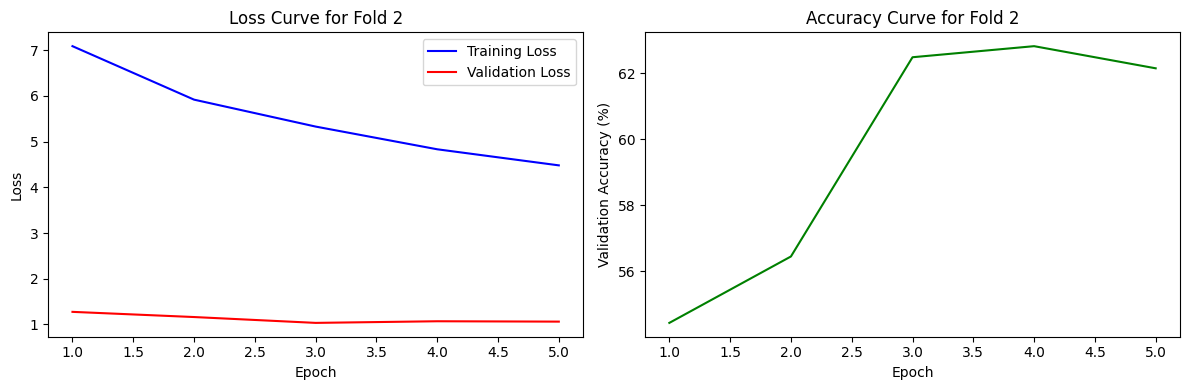

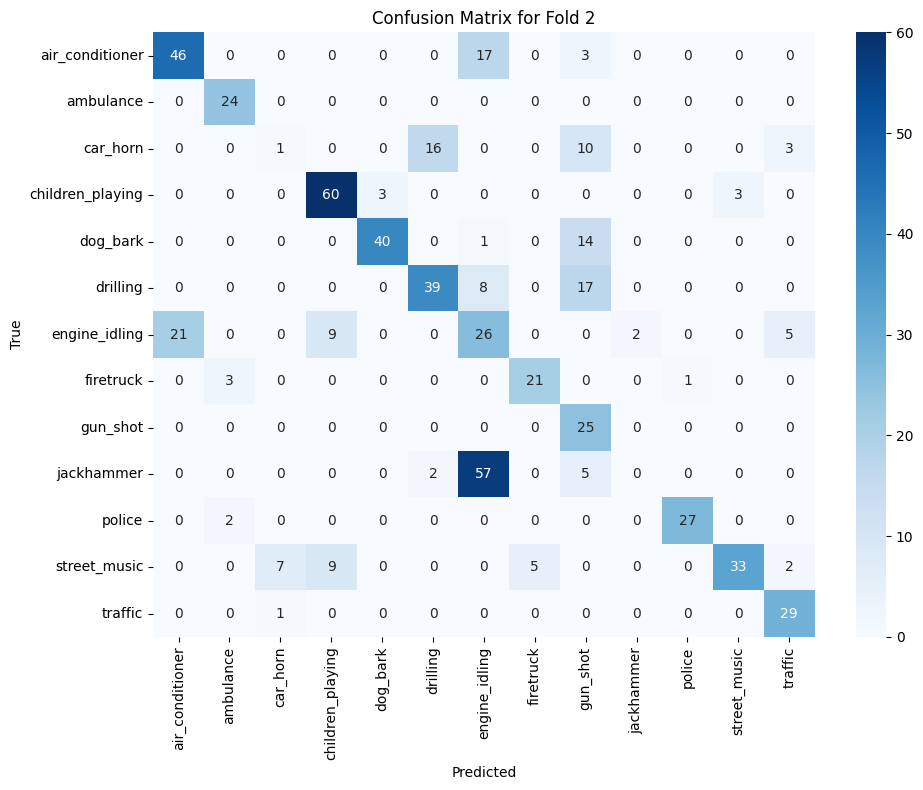

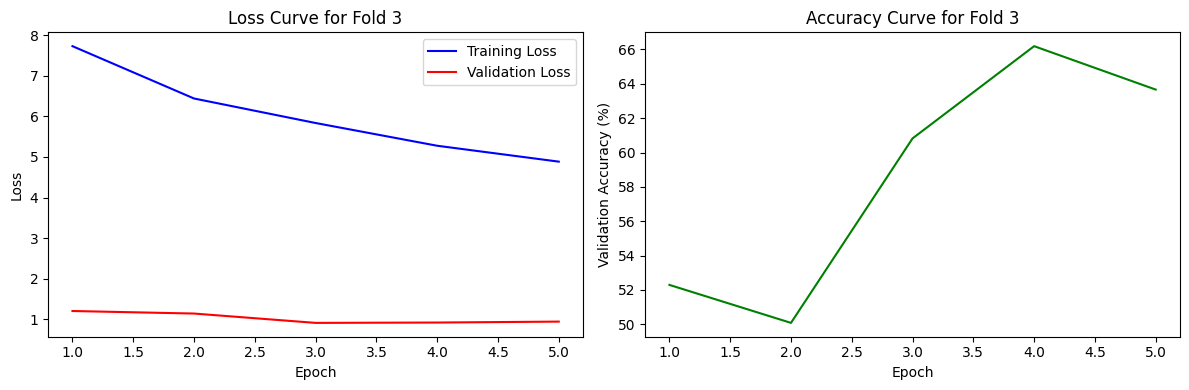

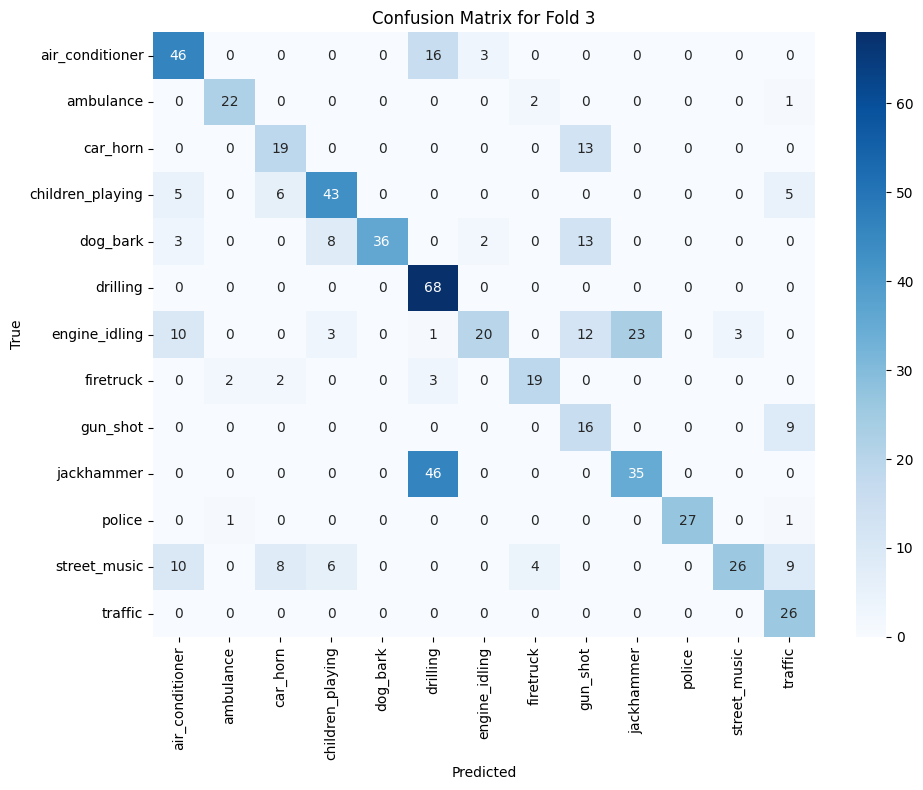

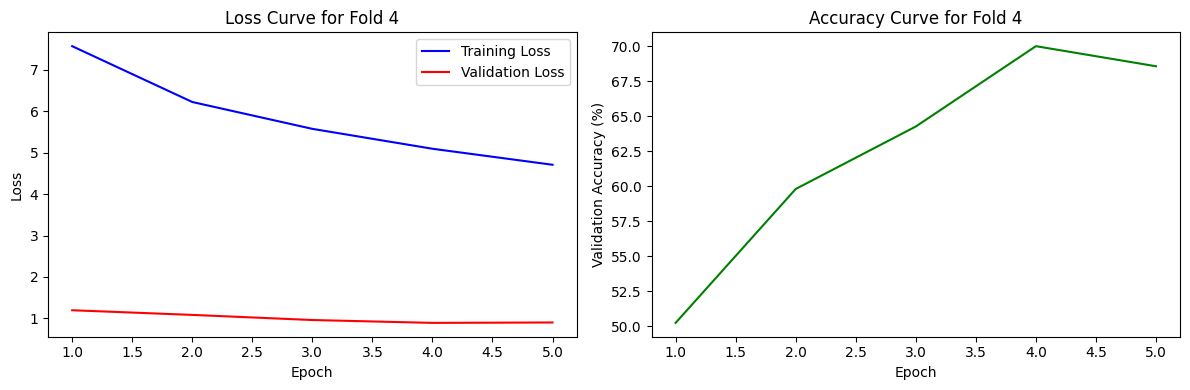

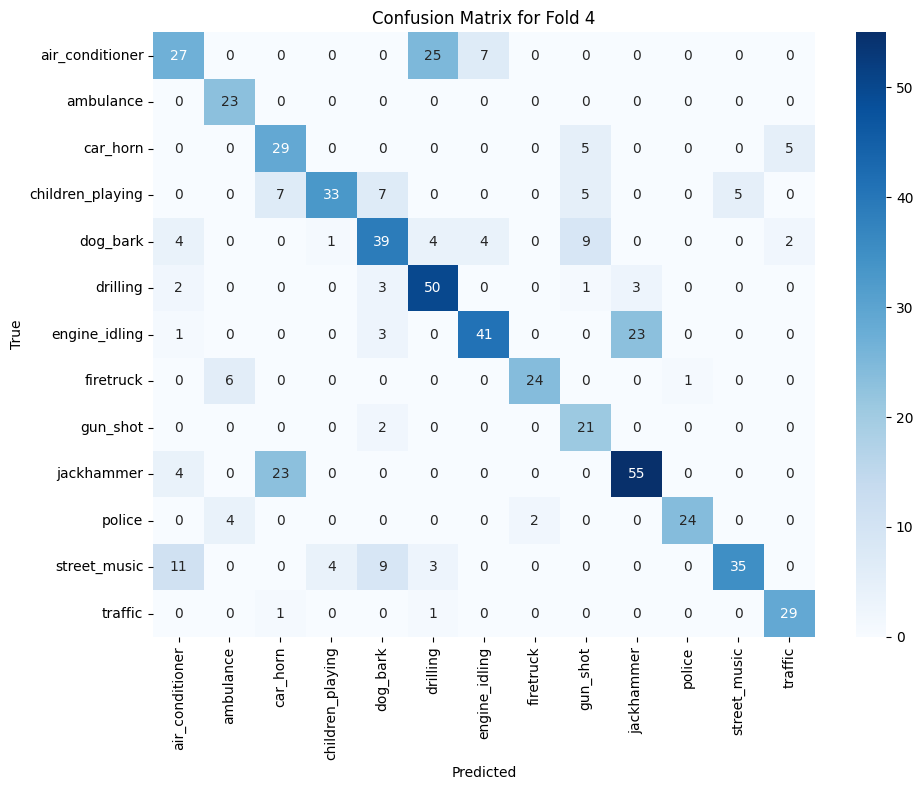

In [12]:
from sklearn.model_selection import StratifiedGroupKFold
train_df, test_df = train_test_split(pd.read_csv("/content/spectrograms_balanced_no_sirens.csv"), test_size=0.2, random_state=42)
train_df, valid_tdf = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['class'])
train_df.to_csv("./spectrograms_balanced.csv")

main(spec_csv = train_df, batch_size = 64, epochs = 5)

In [6]:
train_df.columns

Index(['spec_file_name', 'orig_file_name', 'fsID', 'fold', 'classID', 'class',
       'augmentation'],
      dtype='object')

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
from tqdm import tqdm
from torchvision import transforms

# Assuming MoCo, Classifier, and SpectrogramDataset classes are defined elsewhere

# Inference class for making predictions using a trained model
class SpectrogramClassifier:
    def __init__(self, checkpoint_path, class_names, device=None):
        if device is None:
            self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        else:
            self.device = device

        print(f"Using device: {self.device}")

        # Initialize model components
        backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        backbone.fc = nn.Identity()

        self.moco = MoCo(backbone).to(self.device)
        self.classifier = Classifier(input_dim=2048, num_classes=len(class_names)).to(self.device)
        self.class_names = class_names

        # Load checkpoint
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=self.device)

        self.moco.load_state_dict(checkpoint['moco'])
        self.classifier.load_state_dict(checkpoint['classifier'])

        # Set to evaluation mode
        self.moco.eval()
        self.classifier.eval()

        # Define transforms (similar to validation transforms)
        self.transform = transforms.Compose([
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def predict(self, img_path, verbose=True):
        """
        Predict class for a spectrogram image
        Args:
            img_path: Path to the spectrogram image
            verbose: Whether to print detailed information
        Returns:
            Class name, probability, and all class probabilities
        """
        # Load and transform the image
        img = Image.open(img_path).convert('RGB')
        img_tensor = self.transform(img).unsqueeze(0).to(self.device)

        # Get prediction
        with torch.no_grad():
            features = self.moco.get_features(img_tensor)
            logits = self.classifier(features)
            probabilities = F.softmax(logits, dim=1)[0]

        # Get predicted class and probability
        pred_idx = torch.argmax(probabilities).item()
        pred_class = self.class_names[pred_idx]
        confidence = probabilities[pred_idx].item() * 100

        if verbose:
            print(f"Prediction: {pred_class}")
            print(f"Confidence: {confidence:.2f}%")

            # Print top-3 predictions
            top3_values, top3_indices = torch.topk(probabilities, 3)
            print("\nTop 3 predictions:")
            for i in range(3):
                idx = top3_indices[i].item()
                prob = top3_values[i].item() * 100
                print(f"{self.class_names[idx]}: {prob:.2f}%")

        return pred_class, confidence, probabilities.cpu().numpy()

# Visualize prediction
def visualize_prediction(probs, img_path, class_names):
    """
    Visualize prediction with the spectrogram image
    Args:
        probs: Numpy array of class probabilities
        img_path: Path to the spectrogram image
        class_names: List of class names
    """
    # Load image
    img = Image.open(img_path).convert('RGB')

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot image
    ax1.imshow(img)
    ax1.set_title('Spectrogram')
    ax1.axis('off')

    # Plot probabilities
    sorted_idx = np.argsort(probs)[::-1]
    top_classes = [class_names[i] for i in sorted_idx[:5]]
    top_probs = [probs[i] * 100 for i in sorted_idx[:5]]

    ax2.barh(top_classes, top_probs, color='skyblue')
    ax2.set_xlabel('Probability (%)')
    ax2.set_title('Top Predictions')
    ax2.set_xlim(0, 100)

    plt.tight_layout()
    plt.show()

# Example function to predict and visualize a test case
def predict_and_visualize(img_path, model_path, class_names):
    """
    Make a prediction for a single image and visualize the result
    """
    # Create classifier
    classifier = SpectrogramClassifier(model_path, class_names)

    # Make prediction
    pred_class, confidence, probs = classifier.predict(img_path)

    # Visualize prediction
    visualize_prediction(probs, img_path, class_names)

# Test Case: Run prediction for a given image
def test_case():
    # Path to the trained model checkpoint and the test image
    model_checkpoint_path = '/content/results_moco_20250404_151233/checkpoint_4.pth.pth'
    test_image_path = 'path_to_test_image.png'

    # List of class names (you should replace this with your actual class names)
    class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5']  # Example class names

    # Run prediction and visualization
    predict_and_visualize(test_image_path, model_checkpoint_path, class_names)

# Run the test case

In [16]:
import pandas as pd
import torch
from tqdm import tqdm

# Assuming you have a SpectrogramClassifier class and other helper functions defined above

def predict_on_dataframe(df, model_path, class_names, image_dir='./spectrograms', save_results=True):
    """
    Predict classes for a set of images using a pre-trained model.

    Args:
        df: DataFrame containing the spectrogram file names and class names
        model_path: Path to the trained model checkpoint
        class_names: List of class names
        image_dir: Directory where spectrogram images are stored
        save_results: Whether to save the predictions to a CSV file

    Returns:
        predictions_df: DataFrame containing the predictions
    """
    # Create a SpectrogramClassifier object
    classifier = SpectrogramClassifier(model_path, class_names)

    # Initialize list to store results
    results = []

    # Iterate through the DataFrame and make predictions
    for _, row in tqdm(df.iterrows(), total=len(df)):
        # Get the spectrogram image and true class
        img_name = row['spec_file_name']
        true_class = row['class']
        fold = row['fold']

        # Full image path
        img_path = f"{image_dir}/fold{fold}/{img_name}"

        # Make prediction
        pred_class, confidence, probs = classifier.predict(img_path, verbose=False)

        # Store the result (class, confidence, probabilities)
        results.append({
            'spec_file_name': img_name,
            'true_class': true_class,
            'pred_class': pred_class,
            'confidence': confidence,
            'probabilities': probs.tolist()  # Convert tensor to list for saving
        })

    # Create DataFrame with predictions
    predictions_df = pd.DataFrame(results)

    # Optionally, save the results to a CSV file
    if save_results:
        predictions_df.to_csv('predictions.csv', index=False)

    return predictions_df

# Example usage
if __name__ == "__main__":

    class_names  = ['air_conditioner', 'ambulance', 'car_horn', 'children_playing',
       'dog_bark', 'drilling', 'engine_idling', 'firetruck', 'gun_shot',
       'jackhammer', 'police', 'street_music', 'traffic']  # Add all your classes here

    # Path to the trained model checkpoint
    model_checkpoint_path = '/content/results_moco_20250405_100149/fold_3_model.pth'  # Replace with your model checkpoint path

    # Run predictions on the DataFrame
    predictions_df = predict_on_dataframe(test_df, model_checkpoint_path, class_names)
        # Optionally print or inspect results
    print(predictions_df.head())

Using device: cuda:0
Loading checkpoint from /content/results_moco_20250405_100149/fold_3_model.pth


100%|██████████| 11584/11584 [04:06<00:00, 47.09it/s]


          spec_file_name       true_class       pred_class  confidence  \
0       159708-6-ts0.png         gun_shot         gun_shot   30.217132   
1  7798623703-10-sa1.png        ambulance        firetruck   66.275811   
2  7803268688-13-ts1.png          traffic          traffic   91.832584   
3        62837-7-sa1.png       jackhammer         car_horn   35.374427   
4        177621-0-n0.png  air_conditioner  air_conditioner   45.324981   

                                       probabilities  
0  [0.015028231777250767, 0.026471048593521118, 0...  
1  [0.00043900878517888486, 0.25279706716537476, ...  
2  [0.00105019670445472, 0.0018676287727430463, 0...  
3  [0.015069876797497272, 2.0496432625805028e-05,...  
4  [0.45324981212615967, 0.0006056557176634669, 0...  


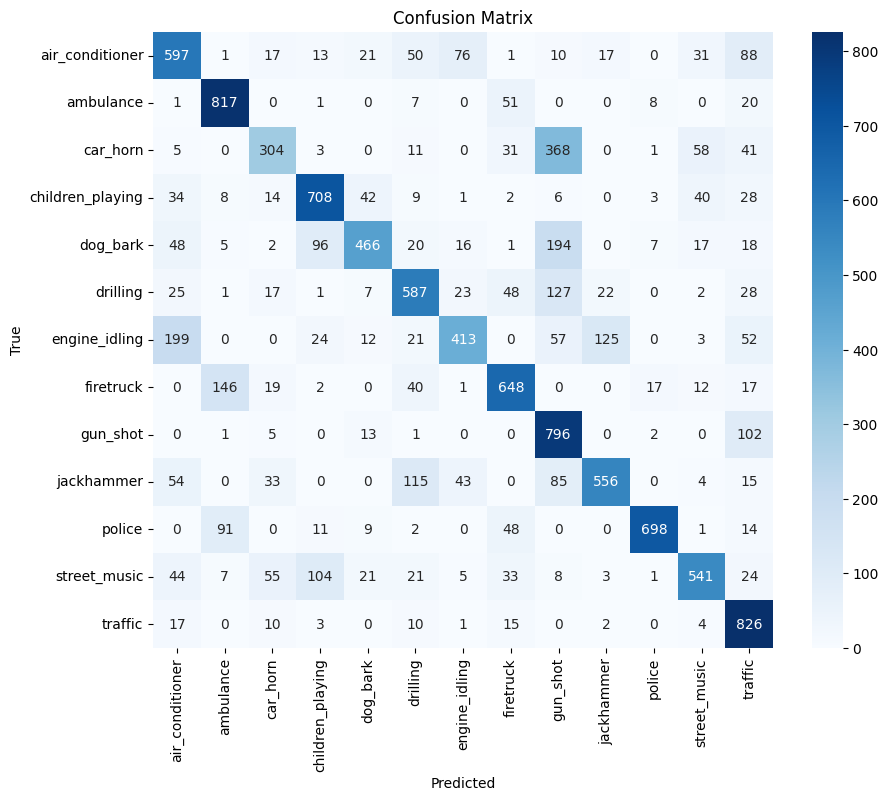

In [17]:
def plot_confusion_matrix(predictions_df, class_names):
    """
    Plot confusion matrix from predictions DataFrame.

    Args:
        predictions_df: DataFrame containing true and predicted classes
        class_names: List of class names
    """
    # Extract true and predicted labels from the DataFrame
    true_labels = predictions_df['true_class']
    pred_labels = predictions_df['pred_class']

    # Generate confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=class_names)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(predictions_df, class_names)

In [18]:
def calculate_top_n_accuracy_per_class(predictions_df, top_percent=1):
    """
    Calculate Top N% accuracy for each class based on maximum probabilities.

    Args:
        predictions_df: DataFrame containing predictions with 'pred_class', 'true_class', and 'probabilities' columns
        top_percent: The percentage (1, 5, 10) for Top N% accuracy

    Returns:
        DataFrame containing the Top N% accuracy for each class
    """
    top_n_accuracy = []

    # Group by class and calculate Top N% accuracy for each class
    for class_name, group in predictions_df.groupby('true_class'):
        # Number of samples for this class
        class_size = len(group)

        # Calculate how many samples to select for the top N% (round to nearest integer)
        top_n_count = max(1, int(class_size * top_percent / 100))  # At least one item

        # Sort by max probability in descending order
        group['max_prob'] = group['probabilities'].apply(lambda x: max(x))
        top_n_group = group.nlargest(top_n_count, 'max_prob')

        # Calculate the accuracy (how many predictions in the top N% are correct)
        correct_predictions = (top_n_group['pred_class'] == top_n_group['true_class']).sum()
        accuracy = correct_predictions / top_n_count * 100  # Convert to percentage

        # Append result to the list
        top_n_accuracy.append({
            'Class': class_name,
            f'Top {top_percent}% Accuracy': f"{accuracy:.2f}%"
        })

    # Create a DataFrame for results
    accuracy_df = pd.DataFrame(top_n_accuracy)

    # Sort by Class name if needed
    accuracy_df = accuracy_df.sort_values(by='Class', ascending=True)

    return accuracy_df

# Example usage
# Let's calculate Top 5% Accuracy
top_5_accuracy_df = calculate_top_n_accuracy_per_class(predictions_df, top_percent=5)

# Display the result for Top 5% Accuracy
print(top_5_accuracy_df.to_string(index=False))

# Similarly, you can compute for Top 10% if needed
top_10_accuracy_df = calculate_top_n_accuracy_per_class(predictions_df, top_percent=10)
print(top_10_accuracy_df.to_string(index=False))


           Class Top 5% Accuracy
 air_conditioner          73.91%
       ambulance         100.00%
        car_horn          92.68%
children_playing         100.00%
        dog_bark          93.18%
        drilling          95.45%
   engine_idling          88.89%
       firetruck          97.78%
        gun_shot         100.00%
      jackhammer         100.00%
          police         100.00%
    street_music         100.00%
         traffic         100.00%
           Class Top 10% Accuracy
 air_conditioner           83.70%
       ambulance          100.00%
        car_horn           91.46%
children_playing           98.88%
        dog_bark           96.63%
        drilling           97.73%
   engine_idling           85.56%
       firetruck           95.56%
        gun_shot          100.00%
      jackhammer          100.00%
          police          100.00%
    street_music           98.84%
         traffic          100.00%


In [19]:
import kagglehub

store = kagglehub.dataset_download("mmoreaux/audio-cats-and-dogs")

100%|██████████| 97.0M/97.0M [00:05<00:00, 17.4MB/s]

Extracting files...


FileNotFoundError: [Errno 2] No such file or directory: 'extra/dog_bark_0.png'

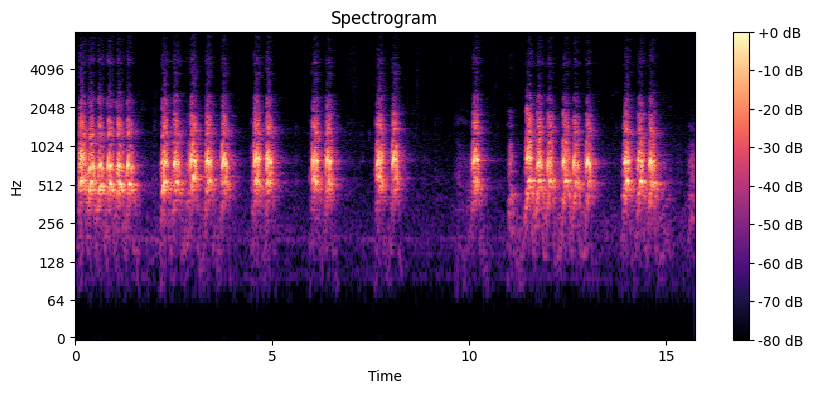

In [20]:
import librosa
df_extra=pd.read_csv(store+'/train_test_split.csv')
# sample =df_extra[df_extra['test_dog'] == 'dog_barking_97.wav']

def wav_to_spectrogram(wav_file, output_image_file="spectrogram.png"):
    """
    Convert a WAV file into a spectrogram image.

    Args:
        wav_file (str): Path to the WAV file.
        output_image_file (str): Path to save the output spectrogram image (default is "spectrogram.png").
    """
    y, sr = librosa.load(wav_file, sr=None)

    D = librosa.stft(y)

    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, x_axis='time', y_axis='log', sr=sr)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')

    # plt.savefig(output_image_file, bbox_inches='tight')
    # plt.close()

    # print(f"Spectrogram saved as {output_image_file}")


# wav_to_spectrogram(path+'/cats_dogs/'+sample['test_dog'][0], 'dog_bark.png')
paths =df_extra['test_dog'].dropna().apply(lambda x: store+'/cats_dogs/'+x)
extra_paths = []
for i,path in enumerate(paths.items()):
  wav_to_spectrogram(path[1], 'extra/dog_bark_'+str(i)+'.png')
  extra_paths.append('extra/dog_bark_'+str(i)+'.png')

In [21]:
classifier = SpectrogramClassifier('/content/results_moco_20250404_151233/checkpoint_4.pth', class_names)

classifier.predict('dog_bark.png')

Using device: cuda:0
Loading checkpoint from /content/results_moco_20250404_151233/checkpoint_4.pth


FileNotFoundError: [Errno 2] No such file or directory: '/content/results_moco_20250404_151233/checkpoint_4.pth'

In [22]:
true_labels = []
pred_labels = []

# Iterate over each path in extra_paths
for p in extra_paths:
    # Get the predicted class and probability from the classifier
    class_name = classifier.predict(p)[0]
    prob = classifier.predict(p)[1]

    # Get the true label from the path-to-label mapping
    true_class = 'dog_bark'  # Assuming each path has a corresponding true label

    # Append to the lists
    true_labels.append(true_class)
    pred_labels.append(class_name)

    # Optionally, print the class name and its predicted probability
    print(f"Predicted: {class_name}, True: {true_class}, Probability: {prob}")

# Now calculate the confusion matrix
cm = confusion_matrix(true_labels, pred_labels, labels=class_names)

Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]]


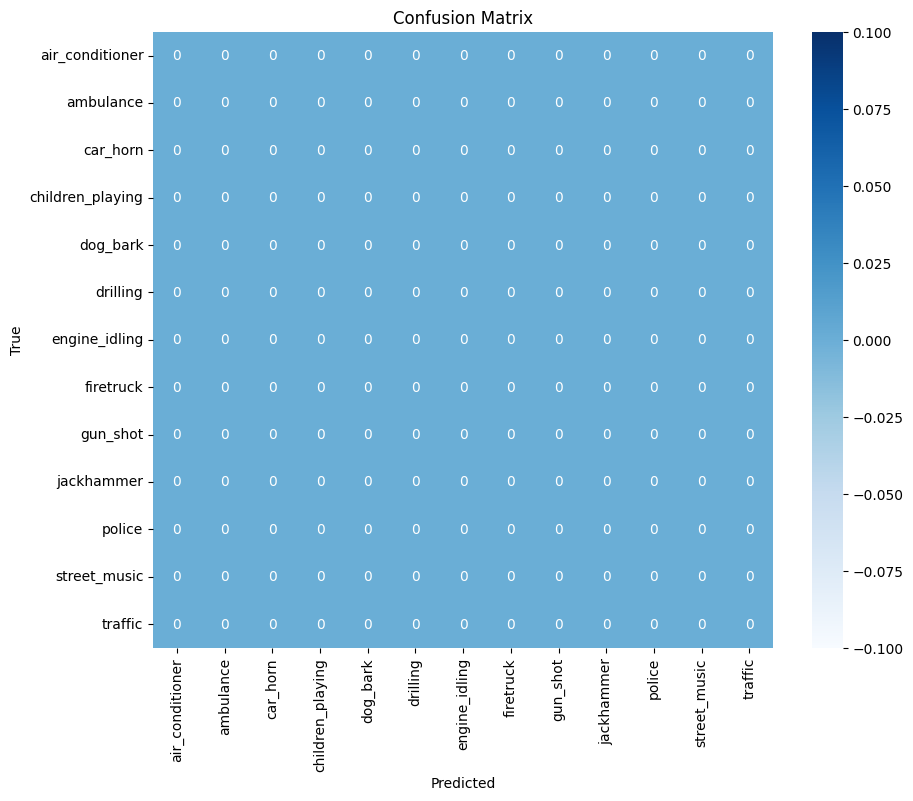


Classification Report:


In [23]:
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Optionally, print the classification report
print("\nClassification Report:")

In [90]:
from google.colab import files
files.download('results_moco.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>